# Ecommerce Capstone Project

### Importing required libraries 

In [1]:
#Importing warnings to ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from datetime import date, datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
import sklearn

### Reading Data
**As consumer electornics data has \N considering it as null while importing the  csv file**

In [3]:
consumer_electronics_df = pd.read_csv("./ConsumerElectronics.csv", na_values=['\\N', ' '])

In [4]:
consumer_electronics_df.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3.419301e+15,3.419301e+15,6400.0,1,NaN,NaN,COD,5,-1.012991e+18,-7.791756e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900.0,1,NaN,NaN,COD,7,-8.990325e+18,7.335411e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990.0,1,NaN,NaN,COD,10,-1.040443e+18,-7.477688e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690.0,1,NaN,NaN,Prepaid,4,-7.604961e+18,-5.835932e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618.0,1,NaN,NaN,Prepaid,6,2.894557e+18,5.347354e+17,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3


In [5]:
consumer_electronics_df.shape

(1648824, 20)

In [6]:
consumer_electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648824 entries, 0 to 1648823
Data columns (total 20 columns):
fsn_id                             1648824 non-null object
order_date                         1648824 non-null object
Year                               1648824 non-null int64
Month                              1648824 non-null int64
order_id                           1648824 non-null float64
order_item_id                      1648824 non-null float64
gmv                                1643920 non-null float64
units                              1648824 non-null int64
deliverybdays                      335852 non-null float64
deliverycdays                      335853 non-null float64
s1_fact.order_payment_type         1648824 non-null object
sla                                1648824 non-null int64
cust_id                            1643920 non-null float64
pincode                            1643920 non-null float64
product_analytic_super_category    1648824 non-null object
p

**Finding the percentage of  unique orders belonging to the required 3 categories** 

In [7]:
print("Percentage of unique orders for the 3 categories:",
      len(consumer_electronics_df.loc[(consumer_electronics_df['product_analytic_sub_category']=='GamingAccessory') | 
                 (consumer_electronics_df['product_analytic_sub_category']=='CameraAccessory') | 
                 (consumer_electronics_df['product_analytic_sub_category']=='HomeAudio')].drop_duplicates
          (subset = ["order_id"], keep = False))/len(consumer_electronics_df.loc[((consumer_electronics_df['product_analytic_sub_category']=='GamingAccessory') | 
                                                             (consumer_electronics_df['product_analytic_sub_category']=='CameraAccessory') | 
                                                             (consumer_electronics_df['product_analytic_sub_category']=='HomeAudio'))])*100)

Percentage of unique orders for the 3 categories: 81.95886392814697


**Finding total number of unique orders for all categories**

In [8]:
print("Percentage of unique orders for all the categories:",
      len(consumer_electronics_df.drop_duplicates(subset = ["order_id"], keep = False))/len(consumer_electronics_df)*100)

Percentage of unique orders for all the categories: 83.02159599811745


**Therefore dropping duplicates on basis of order date,order id,order item id and number of units**

In [9]:
consumer_electronics_df = consumer_electronics_df.drop_duplicates(subset = ["order_date", "order_id", "order_item_id" ,"units"], keep = 'first', inplace = False)

In [10]:
consumer_electronics_df.shape

(1536296, 20)

In [11]:
print("Number of duplicate records for all categories:", 1648824 - 1536296)

Number of duplicate records for all categories: 112528


### Data  type conversion due to type mismatch

In [12]:
consumer_electronics_df['order_datetime'] = pd.to_datetime(consumer_electronics_df['order_date'], format='%Y-%m-%d %H:%M:%S')
#Removing sceintific notation in the following collumns
consumer_electronics_df['cust_id']=  consumer_electronics_df['cust_id'].apply(lambda x: '{:.0f}'.format(x))
consumer_electronics_df['order_id']=  consumer_electronics_df['order_id'].apply(lambda x: '{:.0f}'.format(x))
consumer_electronics_df['order_item_id']=  consumer_electronics_df['order_item_id'].apply(lambda x: '{:.0f}'.format(x))
consumer_electronics_df['pincode']=  consumer_electronics_df['pincode'].apply(lambda x: '{:.0f}'.format(x))

### Data Preparation
**Creating order_date column from order_datetime column**

In [13]:
consumer_electronics_df['order_date'] = consumer_electronics_df['order_datetime'].dt.date

**As its mentioned to only use the data from date range -  July 2015 to June 2016, filtering out the other dates**

In [14]:
start_date = pd.to_datetime("2015-07-01").date()
end_date = pd.to_datetime("2016-06-30").date()
consumer_electronics_df = consumer_electronics_df.loc[(consumer_electronics_df['order_date']>=start_date) 
                                                      & (consumer_electronics_df['order_date']<=end_date)]

**As we need to create models aggregated weekly a new column "order_week" which contains week number as per order date is created**

In [15]:
consumer_electronics_df['order_week'] = consumer_electronics_df['order_datetime'].dt.week

In [16]:
consumer_electronics_df.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,...,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,order_datetime,order_week
0,ACCCX3S58G7B5F6P,2015-10-17,2015,10,3419300926147000,3419300926147000,6400.0,1,NaN,NaN,...,-1012991307785880064,-7791755829057349632,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,2015-10-17 15:11:54,42
1,ACCCX3S58G7B5F6P,2015-10-19,2015,10,1420830839915200,1420830839915200,6900.0,1,NaN,NaN,...,-8990324579055120384,7335411490974310400,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,2015-10-19 10:07:22,43
2,ACCCX3S5AHMF55FV,2015-10-20,2015,10,2421912925714800,2421912925714800,1990.0,1,NaN,NaN,...,-1040442942046599936,-7477687762286570496,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,2015-10-20 15:45:56,43
3,ACCCX3S5AHMF55FV,2015-10-14,2015,10,4416592101738400,4416592101738400,1690.0,1,NaN,NaN,...,-7604960843527140352,-5835931638776609792,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,2015-10-14 12:05:15,42
4,ACCCX3S5AHMF55FV,2015-10-17,2015,10,4419525153426400,4419525153426400,1618.0,1,NaN,NaN,...,2894557208345299968,534735360997241984,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,2015-10-17 21:25:03,42


**Finding and correcting null values by either dropping collumns or by imputation**

In [17]:
round(100*(consumer_electronics_df.isnull().sum()/len(consumer_electronics_df.index)),2).sort_values(ascending = False)

deliverycdays                      78.29
deliverybdays                      78.29
product_analytic_vertical           0.38
gmv                                 0.26
order_week                          0.00
order_date                          0.00
Year                                0.00
Month                               0.00
order_id                            0.00
order_item_id                       0.00
units                               0.00
s1_fact.order_payment_type          0.00
order_datetime                      0.00
sla                                 0.00
cust_id                             0.00
pincode                             0.00
product_analytic_super_category     0.00
product_analytic_category           0.00
product_analytic_sub_category       0.00
product_mrp                         0.00
product_procurement_sla             0.00
fsn_id                              0.00
dtype: float64

**As deliverybdays,deliverycdays consist of 79% null values ,dropping them is the correct option**

In [18]:
#Let's remove the columns deliverybdays & deliverycdays as there are 79% null values
consumer_electronics_df.drop(['deliverybdays', 'deliverycdays'], axis = 1, inplace = True)

In [19]:
round(100*(consumer_electronics_df.isnull().sum()/len(consumer_electronics_df.index)),2).sort_values(ascending = False)

product_analytic_vertical          0.38
gmv                                0.26
order_week                         0.00
s1_fact.order_payment_type         0.00
order_date                         0.00
Year                               0.00
Month                              0.00
order_id                           0.00
order_item_id                      0.00
units                              0.00
sla                                0.00
order_datetime                     0.00
cust_id                            0.00
pincode                            0.00
product_analytic_super_category    0.00
product_analytic_category          0.00
product_analytic_sub_category      0.00
product_mrp                        0.00
product_procurement_sla            0.00
fsn_id                             0.00
dtype: float64

**As product_analytic_vertical column is null in some rows, dropping the rows as they don't serve any purpose**

In [20]:
consumer_electronics_df = consumer_electronics_df.loc[~pd.isnull(consumer_electronics_df['product_analytic_vertical'])]

In [21]:
round(100*(consumer_electronics_df.isnull().sum()/len(consumer_electronics_df.index)),2).sort_values(ascending = False)

gmv                                0.26
order_week                         0.00
order_datetime                     0.00
order_date                         0.00
Year                               0.00
Month                              0.00
order_id                           0.00
order_item_id                      0.00
units                              0.00
s1_fact.order_payment_type         0.00
sla                                0.00
cust_id                            0.00
pincode                            0.00
product_analytic_super_category    0.00
product_analytic_category          0.00
product_analytic_sub_category      0.00
product_analytic_vertical          0.00
product_mrp                        0.00
product_procurement_sla            0.00
fsn_id                             0.00
dtype: float64

**As gmv is our dependent variable dropping rows that have null values in gmv collumn** 

In [22]:
consumer_electronics_df = consumer_electronics_df.loc[~pd.isnull(consumer_electronics_df['gmv'])]

In [23]:
round(100*(consumer_electronics_df.isnull().sum()/len(consumer_electronics_df.index)),2).sort_values(ascending = False)

order_week                         0.0
order_datetime                     0.0
order_date                         0.0
Year                               0.0
Month                              0.0
order_id                           0.0
order_item_id                      0.0
gmv                                0.0
units                              0.0
s1_fact.order_payment_type         0.0
sla                                0.0
cust_id                            0.0
pincode                            0.0
product_analytic_super_category    0.0
product_analytic_category          0.0
product_analytic_sub_category      0.0
product_analytic_vertical          0.0
product_mrp                        0.0
product_procurement_sla            0.0
fsn_id                             0.0
dtype: float64

**As there are no null values we can continue with our analysis**


**Checking the different modes of payment used** 

In [24]:
consumer_electronics_df['s1_fact.order_payment_type'].astype('category').value_counts()

COD        1102785
Prepaid     423105
Name: s1_fact.order_payment_type, dtype: int64

#### As seen above, we have only two types of payments i.e. COD & Prepaid

**Let's check order week along with order date for year 2016 to verify the correctness of order weeek for our analysis**

In [25]:
consumer_electronics_df.loc[(consumer_electronics_df.Year == 2016) & (consumer_electronics_df.Month==2)].loc[:,['order_date','order_week']].sort_values(by='order_date')

,order_date,order_week
649674,2016-02-01,5
782835,2016-02-01,5
662072,2016-02-01,5
689782,2016-02-01,5
652520,2016-02-01,5
652528,2016-02-01,5
680778,2016-02-01,5
707145,2016-02-01,5
772163,2016-02-01,5
727780,2016-02-01,5


**Therefore the order weeks need to be changed in order for them to be continuous  from 2015 for  our analysis**

In [26]:
def mapWeek(order_week,year):
    if((year == 2016) & (order_week <= 26)):
         return order_week+53
    else:
        return order_week

In [27]:
consumer_electronics_df['order_week'] = consumer_electronics_df.apply(lambda x: mapWeek(x['order_week'],x['Year']), axis = 1)

In [28]:
consumer_electronics_df.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,order_datetime,order_week
0,ACCCX3S58G7B5F6P,2015-10-17,2015,10,3419300926147000,3419300926147000,6400.0,1,COD,5,-1012991307785880064,-7791755829057349632,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,2015-10-17 15:11:54,42
1,ACCCX3S58G7B5F6P,2015-10-19,2015,10,1420830839915200,1420830839915200,6900.0,1,COD,7,-8990324579055120384,7335411490974310400,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,2015-10-19 10:07:22,43
2,ACCCX3S5AHMF55FV,2015-10-20,2015,10,2421912925714800,2421912925714800,1990.0,1,COD,10,-1040442942046599936,-7477687762286570496,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,2015-10-20 15:45:56,43
3,ACCCX3S5AHMF55FV,2015-10-14,2015,10,4416592101738400,4416592101738400,1690.0,1,Prepaid,4,-7604960843527140352,-5835931638776609792,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,2015-10-14 12:05:15,42
4,ACCCX3S5AHMF55FV,2015-10-17,2015,10,4419525153426400,4419525153426400,1618.0,1,Prepaid,6,2894557208345299968,534735360997241984,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,2015-10-17 21:25:03,42


**Now let's check if product mrp is 0 and drop the same as it makes no sense to keep it as is serves no purpose**

In [29]:
#Let's check if we have transactions where MRP of the product is 0
len(consumer_electronics_df.loc[consumer_electronics_df.product_mrp == 0])

4864

In [30]:
consumer_electronics_df = consumer_electronics_df.loc[consumer_electronics_df.product_mrp != 0]

In [31]:
#confirming that rows are dropped
len(consumer_electronics_df.loc[consumer_electronics_df.product_mrp == 0])

0

**Now let's check if gmv is 0 and drop the same for the following reasons**
1. imputing it with 1 doesn't affect analysis
2. imputing it with mrp x units is not a good idea 

In [32]:
len(consumer_electronics_df.loc[consumer_electronics_df.gmv == 0])

940

In [33]:
consumer_electronics_df = consumer_electronics_df.loc[~(consumer_electronics_df.gmv == 0)]

In [34]:
#Verifying if the values have been successfully imputed
consumer_electronics_df.loc[consumer_electronics_df['gmv'] == 0.0]

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,order_datetime,order_week


**Now Let's check if we have GMV greater than or equal to the MRP x Number of units sold and drop them if they are, as that shouldn't be practically possible**

In [35]:
consumer_electronics_df.loc[consumer_electronics_df.gmv > (consumer_electronics_df.product_mrp * consumer_electronics_df.units)]

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,order_datetime,order_week
511,ACCCX3SGJRUGH99Z,2015-10-06,2015,10,4409414274572400,4409414274572400,38839.0,1,Prepaid,6,-1617884985499729920,-5488422414876180480,CE,CameraAccessory,CameraAccessory,Lens,34980,0,2015-10-06 04:41:01,41
512,ACCCX3SGN4BGZGQY,2015-10-16,2015,10,2417955407141700,2417955407141700,30155.0,1,Prepaid,4,7810252194098679808,-3845369806734649856,CE,CameraAccessory,CameraAccessory,Lens,24696,1,2015-10-16 05:36:04,42
818,ACCCX3SUBDTT3GMA,2015-10-08,2015,10,1411811239304700,1411811239304700,450.0,1,COD,7,1094225417257330048,-4625296276251990016,CE,CameraAccessory,CameraAccessory,Lens,405,0,2015-10-08 23:12:54,41
819,ACCCX3SUBDTT3GMA,2015-10-22,2015,10,4423484217011800,4423484217011800,900.0,2,Prepaid,8,6138352773202599936,-6222871012507570176,CE,CameraAccessory,CameraAccessory,Lens,405,0,2015-10-22 11:23:26,43
820,ACCCX3SUBXAF4QRK,2015-10-07,2015,10,1410601049371400,1410601049371400,380.0,1,COD,5,-8616460973717909504,1948276093461929984,CE,CameraAccessory,CameraAccessory,Lens,285,-1,2015-10-07 13:31:33,41
821,ACCCX3SUBXAF4QRK,2015-10-09,2015,10,3412467299794200,3412467299794200,380.0,1,Prepaid,4,5925162382134450176,-6571638287790040064,CE,CameraAccessory,CameraAccessory,Lens,285,-1,2015-10-09 17:25:24,41
822,ACCCX3SUBXAF4QRK,2015-10-24,2015,10,1425542425134300,1425542425134300,380.0,1,COD,7,-4227013288478269952,2065649387808029952,CE,CameraAccessory,CameraAccessory,Lens,285,-1,2015-10-24 20:33:38,43
1412,ACCCYZFNBHJNG9GQ,2015-10-28,2015,10,3428740336100600,3428740336100600,16102.0,1,Prepaid,6,-8165496893828750336,2244843098184169984,CE,CameraAccessory,CameraAccessory,Lens,15775,2,2015-10-28 13:26:01,44
2061,ACCCZ34EDY5EYMJ6,2015-10-23,2015,10,2424454554421500,2424454554421500,749.0,1,COD,11,2574847208131049984,1184065665157469952,CE,GamingHardware,GamingAccessory,GamingAccessoryKit,699,1,2015-10-23 14:23:56,43
2192,ACCCZAKGAZZVYSJC,2015-10-17,2015,10,4419446046108400,4419446046108400,1390.0,1,COD,10,-5454213220725189632,5186887196113999872,CE,GamingHardware,GamingAccessory,GamingGun,999,-1,2015-10-17 19:11:57,42


#### Removing the rows where the GMV is greater than the number of units sold multiplied by the MRP of the product

In [36]:
consumer_electronics_df= consumer_electronics_df.loc[consumer_electronics_df.gmv <= (consumer_electronics_df.product_mrp * consumer_electronics_df.units)]

In [37]:
#checking the shape
consumer_electronics_df.shape

(1490019, 20)

**now let's look for and remove outliers in the columns in the dataset**

In [38]:
consumer_electronics_df.describe()

,Year,Month,gmv,units,sla,product_mrp,product_procurement_sla,order_week
count,1.490019e+06,1.490019e+06,1.490019e+06,1.490019e+06,1.490019e+06,1.490019e+06,1.490019e+06,1.490019e+06
mean,2.015556e+03,6.411632e+00,2.495538e+03,1.021619e+00,5.683975e+00,4.214486e+03,5.269346e+00,5.556354e+01
std,4.968865e-01,3.690315e+00,5.677618e+03,2.504660e-01,2.998176e+00,8.686505e+03,5.209425e+01,1.354709e+01
min,2.015000e+03,1.000000e+00,1.000000e+01,1.000000e+00,0.000000e+00,4.900000e+01,-1.000000e+00,2.700000e+01
25%,2.015000e+03,3.000000e+00,3.390000e+02,1.000000e+00,4.000000e+00,8.000000e+02,1.000000e+00,4.400000e+01
50%,2.016000e+03,6.000000e+00,7.500000e+02,1.000000e+00,6.000000e+00,1.599000e+03,2.000000e+00,5.600000e+01
75%,2.016000e+03,1.000000e+01,1.999000e+03,1.000000e+00,7.000000e+00,3.499000e+03,3.000000e+00,6.700000e+01
max,2.016000e+03,1.200000e+01,2.269470e+05,5.000000e+01,1.006000e+03,2.999990e+05,1.000000e+03,7.900000e+01


**Checking for outliers in sla**

In [39]:
consumer_electronics_df['sla'].value_counts()/len(consumer_electronics_df.index)*100

6       14.394984
5       14.179081
4       13.380970
7       12.222126
3       10.827043
8        9.393370
2        6.566426
9        5.954219
1        4.526922
10       3.502841
11       2.041518
12       1.170254
13       0.668448
0        0.356841
14       0.354492
15       0.193487
16       0.111140
17       0.053959
18       0.030872
19       0.018188
20       0.009799
21       0.006913
25       0.004899
24       0.004564
22       0.004497
23       0.003893
26       0.003758
27       0.002886
28       0.002349
30       0.002081
29       0.001342
31       0.000805
32       0.000604
35       0.000470
38       0.000470
33       0.000403
42       0.000336
39       0.000336
34       0.000268
44       0.000201
41       0.000201
40       0.000201
61       0.000201
36       0.000201
37       0.000134
45       0.000134
239      0.000067
184      0.000067
175      0.000067
145      0.000067
68       0.000067
1004     0.000067
60       0.000067
52       0.000067
51       0.000067
47       0

In [40]:
len(consumer_electronics_df.loc[consumer_electronics_df.sla>30])/len(consumer_electronics_df)

5.8388517193404915e-05

**Only 0.0058% of the data has sla more than 30 days**
**Therefore let's cap it to 30 days as thats the maximum practical value**

In [41]:
consumer_electronics_df = consumer_electronics_df.loc[consumer_electronics_df.sla<=30]

In [42]:
consumer_electronics_df.shape

(1489932, 20)

**product_procurement_sla has negative value thus let's remove those records**

In [43]:
consumer_electronics_df = consumer_electronics_df.loc[consumer_electronics_df.product_procurement_sla>=0]

**Lets check for outliers in product_procurement_sla**

In [44]:
consumer_electronics_df['product_procurement_sla'].value_counts()/len(consumer_electronics_df.index)*100

2       34.043203
3       19.386683
1       19.342379
5       13.973453
4        7.662434
0        2.678575
6        1.010862
7        0.779668
15       0.426847
14       0.333542
1000     0.284962
13       0.033719
8        0.030985
9        0.005959
12       0.003996
10       0.002734
Name: product_procurement_sla, dtype: float64

#### As we see above, the number of rows have product procuremnt sla greater than 15 are very less and also there is no value after 15. thus let's cap it to 15 days

In [45]:
consumer_electronics_df = consumer_electronics_df.loc[consumer_electronics_df.product_procurement_sla<=15]

In [46]:
consumer_electronics_df.shape

(1422440, 20)

**filtering  the dataset  for the 3  sub-categories which are required for analysis**

In [47]:
# Filtering the data for the 3 categories
consumer_electronics_df= consumer_electronics_df[(consumer_electronics_df['product_analytic_sub_category']=='GamingAccessory')|
       (consumer_electronics_df['product_analytic_sub_category']=='CameraAccessory')|(consumer_electronics_df['product_analytic_sub_category']=='HomeAudio')]

In [48]:
# checking the length of the data present now
consumer_electronics_df.shape

(497561, 20)

**Therefore we  now  have 4,97,561 rows of data for the three categories used for analysis**

**Now let's see the outliers in column gmv for each sub-category** 

In [49]:
#Seeing the trend in the dataset & the outliers
consumer_electronics_df.describe()

,Year,Month,gmv,units,sla,product_mrp,product_procurement_sla,order_week
count,497561.000000,497561.000000,497561.000000,497561.000000,497561.000000,497561.000000,497561.000000,497561.000000
mean,2015.580580,6.204186,1268.510002,1.025587,5.888470,2497.172984,2.635916,55.949996
std,0.493465,3.663982,2377.020413,0.251929,2.688981,4705.444523,1.656838,13.525343
min,2015.000000,1.000000,10.000000,1.000000,0.000000,99.000000,0.000000,27.000000
25%,2015.000000,3.000000,295.000000,1.000000,4.000000,766.000000,2.000000,45.000000
50%,2016.000000,6.000000,545.000000,1.000000,6.000000,1200.000000,2.000000,57.000000
75%,2016.000000,10.000000,1499.000000,1.000000,7.000000,2800.000000,3.000000,67.000000
max,2016.000000,12.000000,148050.000000,39.000000,30.000000,180000.000000,15.000000,79.000000


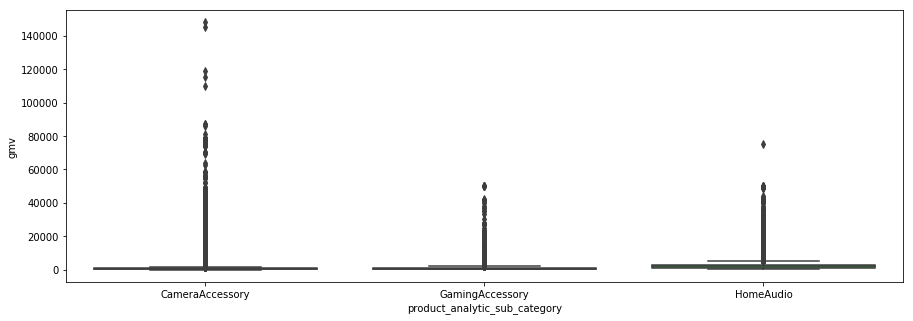

In [50]:
#Let's check outliers in gmv individaully for the three categories
plt.figure(figsize = (15,5))
sns.boxplot(y = 'gmv',data = consumer_electronics_df, x = 'product_analytic_sub_category')

**We  can now observe a large number of outliers in the category CameraAccessory & also some  outliers in the other two categories. This needs to be handled**

**Capping the values to 0.95 quantile**

In [51]:
consumer_electronics_df.loc[(consumer_electronics_df.product_analytic_sub_category=='CameraAccessory')]['gmv'].quantile(0.95)

6079.0

In [52]:
consumer_electronics_df.loc[(consumer_electronics_df.product_analytic_sub_category=='HomeAudio')]['gmv'].quantile(0.95)

4706.249999999913

In [53]:
# Gaming Accessory - capping value for gmv for outlier removal
consumer_electronics_df.loc[(consumer_electronics_df.product_analytic_sub_category=='GamingAccessory')]['gmv'].quantile(0.95)

2890.0

**Now let's create the box plot for checking the outliers after capping the gmv to 95 percentile for each of the sub-categories**

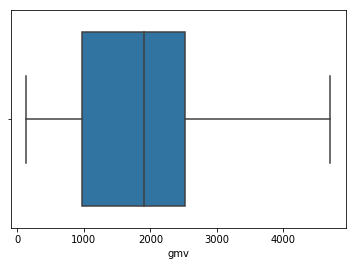

In [54]:
sns.boxplot(consumer_electronics_df.loc[(consumer_electronics_df.product_analytic_sub_category=='HomeAudio') & (consumer_electronics_df.gmv<4706)]['gmv'])

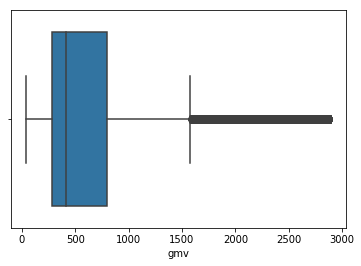

In [55]:
sns.boxplot(consumer_electronics_df.loc[(consumer_electronics_df.product_analytic_sub_category=='GamingAccessory') & (consumer_electronics_df.gmv<2890)]['gmv'])

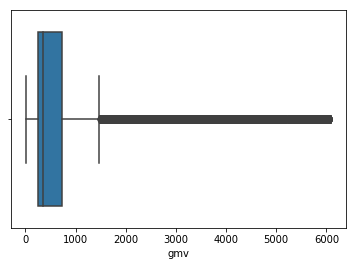

In [56]:
## plotting the box plot for checking the outliers for camera accessory  data after capping it to 95 percentile
sns.boxplot(consumer_electronics_df.loc[(consumer_electronics_df.product_analytic_sub_category=='CameraAccessory') & (consumer_electronics_df.gmv<6079)]['gmv'])

**Thus we can see even after capping the values we find outliers in the dataset. We will consider this as premium products as dropping rows will lead to loss of data. Thus we'll cap the values to 0.95 percentile**

In [57]:
camera_data = consumer_electronics_df.loc[(consumer_electronics_df.product_analytic_sub_category=='CameraAccessory') & (consumer_electronics_df.gmv<6079)]
gaming_data = consumer_electronics_df.loc[(consumer_electronics_df.product_analytic_sub_category=='GamingAccessory') & (consumer_electronics_df.gmv<3000)]
homeaudio_data = consumer_electronics_df.loc[(consumer_electronics_df.product_analytic_sub_category=='HomeAudio') & (consumer_electronics_df.gmv<4706)]

In [58]:
## checking the shape of the 3 categories
print(camera_data.shape)
print(gaming_data.shape)
print(homeaudio_data.shape)

(199598, 20)
(172870, 20)
(100755, 20)


In [59]:
## concatenating the three categories to a single dataframe data
consumer_electronics_df = pd.concat([camera_data, gaming_data, homeaudio_data], axis = 0)

#### Therefore, we've successfully removed the prominent outliers from each of the 3 categories

**Let's now drop the columns which give us no relevant information for analysis**

In [60]:
consumer_electronics_df.drop(['fsn_id','order_item_id','pincode','product_analytic_super_category','product_analytic_category'], 
        inplace = True, axis = 1)

**Let's now convert  data types for Year, Month & order_week to int**

In [61]:

consumer_electronics_df['Year'] = consumer_electronics_df['Year'].astype('int')
consumer_electronics_df['Month'] = consumer_electronics_df['Month'].astype('int')
consumer_electronics_df['order_week'] = consumer_electronics_df['order_week'].astype('int')

## Exploratory Data Analyisis and KPI Engineering

**Let's visualize the number of transactions under each sub-category**

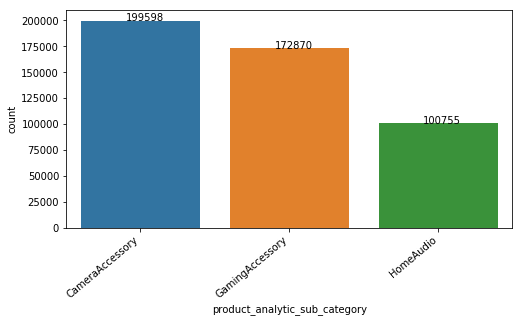

In [62]:
## No of transactions by Sub-Category
plt.figure(figsize = (8,4))
ax = sns.countplot(consumer_electronics_df['product_analytic_sub_category'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
sns.set_context(font_scale = 1.4)
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+20))

**Thus the maximum number of transaction were from Camera Accessory category followed by Gaming Accessory and lastly Home Audio**

**Let's now visualize the total revenue for each of the sub-categories**

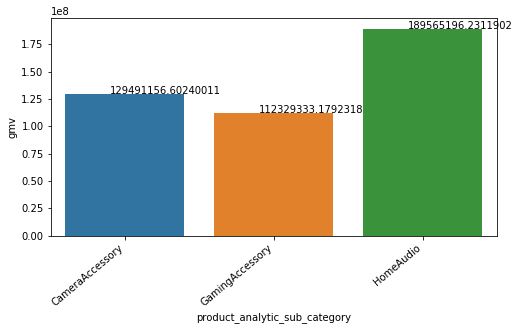

In [63]:
total_revenue= consumer_electronics_df.groupby('product_analytic_sub_category')['gmv'].sum().reset_index()
plt.figure(figsize = (8,4))
ax = sns.barplot(x='product_analytic_sub_category', y='gmv', data=total_revenue)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
sns.set_context(font_scale = 1.4)
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+20))

#### The maximum revenue from transacations are for Home Audio followed by Camera Accessory & lastly Gamming Accessory
**Let's now check the corelation of the different variables to check for multi-colinearity**

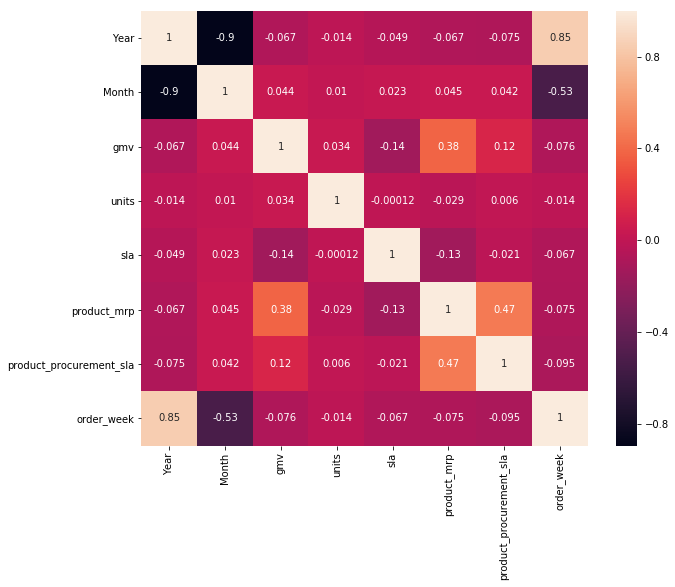

In [64]:
plt.figure(figsize = (10,8))
sns.heatmap(consumer_electronics_df.corr(), annot=True)

#### As we see above, there is a high correlation b/w 
- Month & Year
- Month & order_week

#### Medium correlation b/w
- product_mrp & GMV

**Let's now visualize the total revenue for each of the sub-categories (total gmv) vs Payment Type**

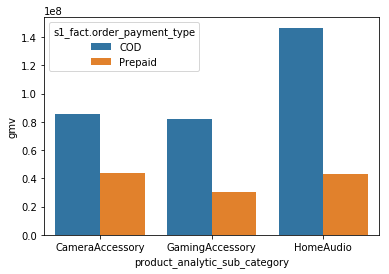

In [65]:
revenue_by_payment_type = consumer_electronics_df.groupby(["s1_fact.order_payment_type","product_analytic_sub_category"])['gmv'].sum().reset_index()
sns.barplot(x='product_analytic_sub_category', y='gmv', hue="s1_fact.order_payment_type", data=revenue_by_payment_type)

- For COD orders,the  maximum revenue is from Home Audio followed by Camera Accessory and lastly Gaming Accessory
- For Prepaid order's, maximum revenue is from Camera Accessory, followed by Home audio and lastly Gaming accessory

**Let's now visualize the total number of orders for each of the sub-categories vs Payment Type**

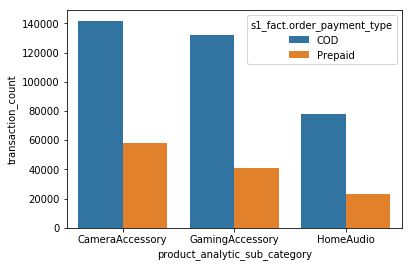

In [66]:
norders_by_Payment_type = consumer_electronics_df.groupby(["s1_fact.order_payment_type","product_analytic_sub_category"])['gmv'].count().reset_index().rename(columns={'gmv':'transaction_count'})
sns.barplot(x='product_analytic_sub_category', y='transaction_count', hue="s1_fact.order_payment_type", data=norders_by_Payment_type)

- Maximum number of orders are for Camera Accessory followed by Gaming Accessory and lastly  Home Audio  for both type of trasactions 

#### Creating the data set for each  sub-category

In [67]:
gaming_data = consumer_electronics_df[(consumer_electronics_df['product_analytic_sub_category']=='GamingAccessory')].drop('product_analytic_sub_category', axis = 1)
camera_data = consumer_electronics_df[(consumer_electronics_df['product_analytic_sub_category']=='CameraAccessory')].drop('product_analytic_sub_category', axis = 1)
homeaudio_data = consumer_electronics_df[(consumer_electronics_df['product_analytic_sub_category']=='HomeAudio')].drop('product_analytic_sub_category', axis = 1)

In [68]:
print(gaming_data.shape)
print(camera_data.shape)
print(homeaudio_data.shape)

(172870, 14)
(199598, 14)
(100755, 14)


### Creating the KPIs

**Function to take  dataframe of order dates and provide total special and payment dates for each week** 

In [69]:
def createDFFromDict(listOfValues, desiredColumnName):
    df = pd.DataFrame(listOfValues)
    df[desiredColumnName] = pd.to_datetime(df[desiredColumnName]).dt.date
    df["total_"+desiredColumnName+"s"] = 1
    df['order_week'] = pd.to_datetime(df[desiredColumnName]).dt.week
    df['year'] = pd.to_datetime(df[desiredColumnName]).dt.year
    df['order_week'] = df.apply(lambda x: mapWeek(x['order_week'],x['year']), axis = 1)
    df = df.groupby('order_week').sum()
    df["is_"+desiredColumnName] = 1
    df.drop('year', axis = 1, inplace = True)
    return df

In [70]:
def createKPIs(df):
#### KPI 1: Payment mode indicator
    df['payment_mode_indicator'] = df['s1_fact.order_payment_type'].apply(lambda x: 0 if x == "COD" else 1)
#### KPI 2: Selling price of each product in every transaction
    df['selling_price'] = df['gmv']/df['units']
#### KPI 3: Discount offered on  each of the products
    df['discount'] = np.round((df['product_mrp']-df['selling_price'])/df['product_mrp'],2)
    
    return df

In [71]:
def createWeeklyAggregatedCollumns():
#### KPI 4: Total Holidays
    holidays = {'holiday':["2016-01-01", "2016-02-16", "2016-02-14", "2016-03-17", "2016-04-03", "2016-04-06", 
            "2016-05-10", "2016-05-18", "2016-06-21", "2016-06-24", "2015-07-01", "2015-08-03", 
            "2015-09-07", "2015-10-12", "2015-10-31", "2015-11-11", "2015-12-25", "2015-12-26"]}
    holiday_df = createDFFromDict(holidays,"holiday")

#### KPI 5: total Special sale days
    special_sale_days = {'special_sale_day':["2015-07-18","2015-07-19","2015-08-15",
                  "2015-08-16","2015-08-17","2015-08-28",
                  "2015-08-29","2015-08-30","2015-10-15",
                  "2015-10-16","2015-10-17","2015-11-07","2015-11-08","2015-11-09","2015-11-10",
                  "2015-10-11","2015-10-12","2015-11-13","2015-11-14","2015-12-25","2015-12-26",
                  "2015-12-27","2015-12-28","2015-12-29","2015-12-30","2016-01-01","2016-01-02",
                  "2016-01-03","2016-01-20","2016-01-21","2016-01-22","2016-02-01","2016-02-02",
                  "2016-02-20","2016-02-21","2016-02-14","2016-02-15","2016-03-07","2016-03-08",
                  "2016-03-09","2016-05-25","2016-05-26","2016-05-27"]}
    special_sale_day_df = createDFFromDict(special_sale_days,'special_sale_day')

#### KPI 6: total pay days
    #Creating order_day column
    pay_days = {'pay_day':["2015-07-01","2015-07-15","2015-08-01","2015-08-15",
                "2015-09-01","2015-09-15","2015-10-01","2015-10-15","2015-11-01",
                "2015-11-15","2015-12-01","2015-12-15","2016-01-01","2016-01-15",
                "2016-02-01","2016-02-15","2016-03-01","2016-03-15","2016-04-01",
                "2016-04-15","2016-05-01","2016-05-15","2016-06-01","2016-06-15"]}
    pay_days_df = createDFFromDict(pay_days,'pay_day')
    final_df = pd.concat([holiday_df, special_sale_day_df, pay_days_df],axis = 1)
    return final_df.fillna(0).astype('int')

In [72]:
createWeeklyAggregatedCollumns()

,total_holidays,is_holiday,total_special_sale_days,is_special_sale_day,total_pay_days,is_pay_day
order_week,,,,,,
27,1,1,0,0,1,1
29,0,0,2,1,1,1
31,0,0,0,0,1,1
32,1,1,0,0,0,0
33,0,0,2,1,1,1
34,0,0,1,1,0,0
35,0,0,3,1,0,0
36,0,0,0,0,1,1
37,1,1,0,0,0,0


In [73]:
createWeeklyAggregatedCollumns().head()

,total_holidays,is_holiday,total_special_sale_days,is_special_sale_day,total_pay_days,is_pay_day
order_week,,,,,,
27,1,1,0,0,1,1
29,0,0,2,1,1,1
31,0,0,0,0,1,1
32,1,1,0,0,0,0
33,0,0,2,1,1,1


**Now let's Add the KPIs to the dataframes of each sub-category**

In [74]:
gaming_data_with_KPIs = createKPIs(gaming_data)
camera_data_with_KPIs = createKPIs(camera_data)
homeaudio_data_with_KPIs = createKPIs(homeaudio_data)

In [75]:
print(homeaudio_data_with_KPIs.shape)
print(gaming_data_with_KPIs.shape)
print(camera_data_with_KPIs.shape)

(100755, 17)
(172870, 17)
(199598, 17)


In [76]:
gaming_data_with_KPIs.head()

,order_date,Year,Month,order_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,product_analytic_vertical,product_mrp,product_procurement_sla,order_datetime,order_week,payment_mode_indicator,selling_price,discount
1599,2015-10-14,2015,10,1416985339691600,2750.0,1,COD,7,9041577304631719936,GamePad,3999,5,2015-10-14 22:54:54,42,0,2750.0,0.31
1600,2015-10-15,2015,10,1417669228375400,2899.0,1,Prepaid,5,8973831124140309504,GamePad,3999,5,2015-10-15 20:19:38,42,1,2899.0,0.28
1601,2015-10-17,2015,10,1419414998353400,2609.0,1,Prepaid,5,-4824142736471789568,GamePad,3999,5,2015-10-17 18:21:43,42,1,2609.0,0.35
1602,2015-10-26,2015,10,1427167582532600,2772.0,1,Prepaid,5,-3305365297260279808,GamePad,3999,5,2015-10-26 17:49:39,44,1,2772.0,0.31
1603,2015-10-16,2015,10,4417730112316700,2750.0,1,Prepaid,7,2297791966161220096,GamePad,3999,5,2015-10-16 04:02:08,42,1,2750.0,0.31


In [77]:
camera_data_with_KPIs.head()

,order_date,Year,Month,order_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,product_analytic_vertical,product_mrp,product_procurement_sla,order_datetime,order_week,payment_mode_indicator,selling_price,discount
2,2015-10-20,2015,10,2421912925714800,1990.0,1,COD,10,-1040442942046599936,CameraTripod,2099,3,2015-10-20 15:45:56,43,0,1990.0,0.05
3,2015-10-14,2015,10,4416592101738400,1690.0,1,Prepaid,4,-7604960843527140352,CameraTripod,2099,3,2015-10-14 12:05:15,42,1,1690.0,0.19
4,2015-10-17,2015,10,4419525153426400,1618.0,1,Prepaid,6,2894557208345299968,CameraTripod,2099,3,2015-10-17 21:25:03,42,1,1618.0,0.23
5,2015-10-17,2015,10,3419188825145600,3324.0,1,Prepaid,5,-7641546361891739648,CameraTripod,4044,5,2015-10-17 12:07:24,42,1,3324.0,0.18
6,2015-10-16,2015,10,3418428515041500,3695.0,1,Prepaid,6,-71561404148106600,CameraTripod,4044,5,2015-10-16 14:59:57,42,1,3695.0,0.09


In [78]:
homeaudio_data_with_KPIs.head()

,order_date,Year,Month,order_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,product_analytic_vertical,product_mrp,product_procurement_sla,order_datetime,order_week,payment_mode_indicator,selling_price,discount
2870,2015-10-08,2015,10,1411753777965600,3700.0,1,COD,3,8628124667745449984,HomeAudioSpeaker,4599,0,2015-10-08 21:34:04,41,0,3700.0,0.20
2871,2015-10-11,2015,10,2414104375842400,3700.0,1,COD,5,5684936202558919680,HomeAudioSpeaker,4599,0,2015-10-11 16:54:52,41,0,3700.0,0.20
2872,2015-10-08,2015,10,4411629266828400,3700.0,1,COD,3,-1123729755469779968,HomeAudioSpeaker,4599,0,2015-10-08 18:06:04,41,0,3700.0,0.20
5960,2015-10-01,2015,10,2405684398213000,2159.0,1,Prepaid,6,8509075186971020288,HomeAudioSpeaker,2800,5,2015-10-01 21:02:49,40,1,2159.0,0.23
5961,2015-10-26,2015,10,3427126275487100,2159.0,1,COD,5,349030327610672000,HomeAudioSpeaker,2800,5,2015-10-26 16:41:40,44,0,2159.0,0.23


###  Creating KPIs for Product Analytical Vertical

In [79]:
# Creating KPIs for product analytical vertical
prd_vert_CA = camera_data_with_KPIs.groupby(['order_week','product_analytic_vertical'])['units'].sum().reset_index()
CA_prdvr_KPI = prd_vert_CA.pivot_table(index='order_week', columns='product_analytic_vertical', values='units', aggfunc=np.sum).fillna("0").reset_index()
cols = CA_prdvr_KPI.columns
CA_prdvr_KPI[cols] = CA_prdvr_KPI[cols].apply(pd.to_numeric, errors='coerce')
camera_data_with_KPIs = camera_data_with_KPIs.drop(['product_analytic_vertical'],axis=1)

In [80]:
#Counting products sold in each vertical
prd_vrt_units_sold = prd_vert_CA.groupby('product_analytic_vertical')['units'].sum().reset_index().sort_values(by=['units'],ascending=False)
prd_vrt_units_sold.head()

,product_analytic_vertical,units
15,Flash,48003
3,CameraBattery,35974
12,CameraTripod,31268
17,Lens,22800
2,CameraBag,15279


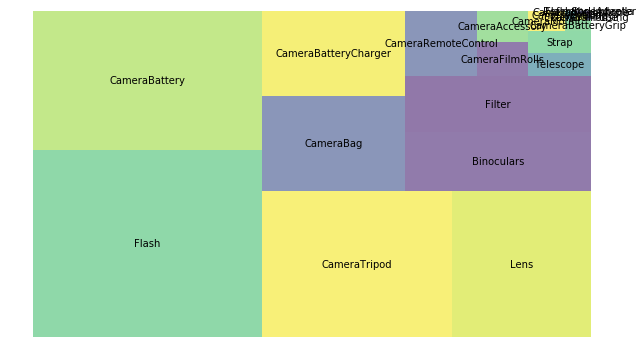

In [81]:
import squarify
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 6.0)
 
squarify.plot(sizes=prd_vrt_units_sold['units'], label=prd_vrt_units_sold['product_analytic_vertical'], alpha=.6 )
plt.axis('off')
plt.show()

#### As we see the highest sold item is Flash followed by Camera Battery and Camera Tripod

In [82]:
# Creating KPIs for product analytical vertical
prd_vert_GA = gaming_data_with_KPIs.groupby(['order_week','product_analytic_vertical'])['units'].sum().reset_index()
GA_prdvr_KPI = prd_vert_GA.pivot_table(index='order_week', columns='product_analytic_vertical', values='units', aggfunc=np.sum).fillna("0")
cols = GA_prdvr_KPI.columns
GA_prdvr_KPI[cols] = GA_prdvr_KPI[cols].apply(pd.to_numeric, errors='coerce')
gaming_data_with_KPIs = gaming_data_with_KPIs.drop(['product_analytic_vertical'],axis=1)


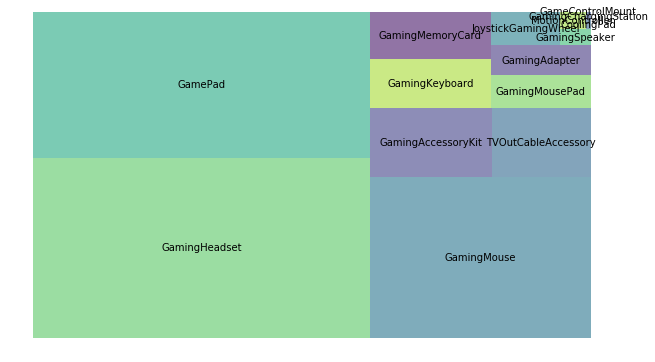

In [83]:
#Creating number of products sold for each vertical & plotting
prd_vrt_units_sold = prd_vert_GA.groupby('product_analytic_vertical')['units'].sum().reset_index().sort_values(by=['units'],ascending=False)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 6.0)
 
squarify.plot(sizes=prd_vrt_units_sold['units'], label=prd_vrt_units_sold['product_analytic_vertical'], alpha=.6 )
plt.axis('off')
plt.show()

#### As we see the highest sold item is Gaming Headset followed by Game Pad and Gaming Mouse

In [84]:
# Creating KPIs for product analytical vertical
prd_vert_HA = homeaudio_data_with_KPIs.groupby(['order_week','product_analytic_vertical'])['units'].sum().reset_index()
HA_prdvr_KPI = prd_vert_HA.pivot_table(index='order_week', columns='product_analytic_vertical', values='units', aggfunc=np.sum).fillna("0").reset_index()
cols = HA_prdvr_KPI.columns
HA_prdvr_KPI[cols] = HA_prdvr_KPI[cols].apply(pd.to_numeric, errors='coerce')
homeaudio_data_with_KPIs = homeaudio_data_with_KPIs.drop(['product_analytic_vertical'],axis=1)

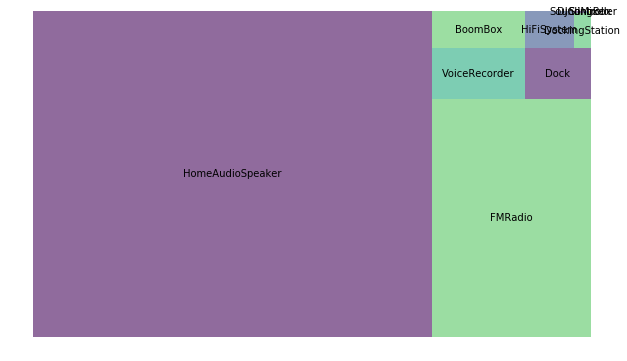

In [85]:
#Creating number of products sold for each vertical & plotting
prd_vrt_units_sold = prd_vert_HA.groupby('product_analytic_vertical')['units'].sum().reset_index().sort_values(by=['units'],ascending=False)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 6.0)
 
squarify.plot(sizes=prd_vrt_units_sold['units'], label=prd_vrt_units_sold['product_analytic_vertical'], alpha=.6 )
plt.axis('off')
plt.show()

#### As we see the highest sold item isHome Audio Speaker followed by FMRadio & VoiceRecorder

**KPI 7 : Product Premiumness**

In [86]:
def createProductPremiumness(df,cut_off):
    df['premium_product'] = df['gmv'].apply(lambda  x:1 if (x >cut_off) else 0)
    return df

In [87]:
camera_data_with_KPIs['gmv'].describe()

count    199598.00000
mean        648.75979
std         781.57022
min          10.00000
25%         248.00000
50%         349.00000
75%         739.00000
max        6078.00000
Name: gmv, dtype: float64

**Therefore the cut-off value for camera acccessory is 739(75% percentile)**

In [88]:
camera_data_with_KPIs = createProductPremiumness(camera_data_with_KPIs,739.0)

In [89]:
camera_data_with_KPIs.head()

,order_date,Year,Month,order_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,product_mrp,product_procurement_sla,order_datetime,order_week,payment_mode_indicator,selling_price,discount,premium_product
2,2015-10-20,2015,10,2421912925714800,1990.0,1,COD,10,-1040442942046599936,2099,3,2015-10-20 15:45:56,43,0,1990.0,0.05,1
3,2015-10-14,2015,10,4416592101738400,1690.0,1,Prepaid,4,-7604960843527140352,2099,3,2015-10-14 12:05:15,42,1,1690.0,0.19,1
4,2015-10-17,2015,10,4419525153426400,1618.0,1,Prepaid,6,2894557208345299968,2099,3,2015-10-17 21:25:03,42,1,1618.0,0.23,1
5,2015-10-17,2015,10,3419188825145600,3324.0,1,Prepaid,5,-7641546361891739648,4044,5,2015-10-17 12:07:24,42,1,3324.0,0.18,1
6,2015-10-16,2015,10,3418428515041500,3695.0,1,Prepaid,6,-71561404148106600,4044,5,2015-10-16 14:59:57,42,1,3695.0,0.09,1


In [90]:
gaming_data_with_KPIs['gmv'].describe()

count    172870.000000
mean        649.790786
std         580.402575
min          39.000000
25%         279.000000
50%         420.000000
75%         806.000000
max        2999.000000
Name: gmv, dtype: float64

**Therefore the cut-off value for gaming accesory is 806(75% percentile)**

In [91]:
gaming_data_with_KPIs = createProductPremiumness(gaming_data_with_KPIs,806.0)

In [92]:
gaming_data_with_KPIs.head()

,order_date,Year,Month,order_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,product_mrp,product_procurement_sla,order_datetime,order_week,payment_mode_indicator,selling_price,discount,premium_product
1599,2015-10-14,2015,10,1416985339691600,2750.0,1,COD,7,9041577304631719936,3999,5,2015-10-14 22:54:54,42,0,2750.0,0.31,1
1600,2015-10-15,2015,10,1417669228375400,2899.0,1,Prepaid,5,8973831124140309504,3999,5,2015-10-15 20:19:38,42,1,2899.0,0.28,1
1601,2015-10-17,2015,10,1419414998353400,2609.0,1,Prepaid,5,-4824142736471789568,3999,5,2015-10-17 18:21:43,42,1,2609.0,0.35,1
1602,2015-10-26,2015,10,1427167582532600,2772.0,1,Prepaid,5,-3305365297260279808,3999,5,2015-10-26 17:49:39,44,1,2772.0,0.31,1
1603,2015-10-16,2015,10,4417730112316700,2750.0,1,Prepaid,7,2297791966161220096,3999,5,2015-10-16 04:02:08,42,1,2750.0,0.31,1


In [93]:
homeaudio_data_with_KPIs['gmv'].describe()

count    100755.000000
mean       1881.447037
std         976.982316
min         129.000000
25%         975.000000
50%        1899.000000
75%        2525.000000
max        4704.000000
Name: gmv, dtype: float64

**Therefore the cut-off value for camera acccessory is 2525.0(75% percentile)**

In [94]:
homeaudio_data_with_KPIs = createProductPremiumness(homeaudio_data_with_KPIs,2525.0)

In [95]:
homeaudio_data_with_KPIs.head()

,order_date,Year,Month,order_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,product_mrp,product_procurement_sla,order_datetime,order_week,payment_mode_indicator,selling_price,discount,premium_product
2870,2015-10-08,2015,10,1411753777965600,3700.0,1,COD,3,8628124667745449984,4599,0,2015-10-08 21:34:04,41,0,3700.0,0.20,1
2871,2015-10-11,2015,10,2414104375842400,3700.0,1,COD,5,5684936202558919680,4599,0,2015-10-11 16:54:52,41,0,3700.0,0.20,1
2872,2015-10-08,2015,10,4411629266828400,3700.0,1,COD,3,-1123729755469779968,4599,0,2015-10-08 18:06:04,41,0,3700.0,0.20,1
5960,2015-10-01,2015,10,2405684398213000,2159.0,1,Prepaid,6,8509075186971020288,2800,5,2015-10-01 21:02:49,40,1,2159.0,0.23,0
5961,2015-10-26,2015,10,3427126275487100,2159.0,1,COD,5,349030327610672000,2800,5,2015-10-26 16:41:40,44,0,2159.0,0.23,0


### KPI 8: Including NPS & Stock Index. Creating them separately & merging with 3 dataframes

In [96]:
#Reading media data from the excel file
nps_df = pd.read_excel("./Media data and other information.xlsx", sheet_name = 'Monthly NPS Score', header = 1).T.reset_index()

# resetting index
nps_df.reset_index(drop=True, inplace=True)

# renaming columns
nps_df.columns = ['DT', 'NPS', 'Stock Index']
nps_df

,DT,NPS,Stock Index
0,July'15,54.599588,1177.0
1,Aug'15,59.987101,1206.0
2,Sept'15,46.925419,1101.0
3,Oct'15,44.398389,1210.0
4,Nov'15,47.000000,1233.0
5,Dec'15,45.800000,1038.0
6,Jan'16,47.093031,1052.0
7,Feb'16,50.327406,1222.0
8,Mar'16,49.020550,1015.0
9,Apr'16,51.827605,1242.0


In [97]:
nps_df['Year']=[2015,2015,2015,2015,2015,2015,2016,2016,2016,2016,2016,2016]
nps_df['Month']=[7,8,9,10,11,12,1,2,3,4,5,6]

In [98]:
nps_df.drop('DT',axis=1,inplace=True)

In [99]:
nps_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
NPS            12 non-null float64
Stock Index    12 non-null float64
Year           12 non-null int64
Month          12 non-null int64
dtypes: float64(2), int64(2)
memory usage: 464.0 bytes


**Adding NPS KPI to each of the dataframes**

In [100]:
gaming_data_with_KPIs = pd.merge(nps_df,gaming_data_with_KPIs,on=['Month','Year'],how='inner')
camera_data_with_KPIs = pd.merge(nps_df,camera_data_with_KPIs,on=['Month','Year'],how='inner')
homeaudio_data_with_KPIs = pd.merge(nps_df,homeaudio_data_with_KPIs,on=['Month','Year'],how='inner')

In [101]:
# Creating dataframes for plots for each of the category
GamingAccessory_data_with_KPIs_for_plot = gaming_data_with_KPIs
GamingAccessory_data_with_KPIs_for_plot['product_analytic_sub_category'] = "Gaming Accessory"
CameraAccessory_data_with_KPIs_for_plot = camera_data_with_KPIs
CameraAccessory_data_with_KPIs_for_plot['product_analytic_sub_category'] = "Camera Accessory"
HomeAudio_data_with_KPIs_for_plot = homeaudio_data_with_KPIs
HomeAudio_data_with_KPIs_for_plot['product_analytic_sub_category'] = "Home Audio"

all_data_with_kpi = pd.concat([GamingAccessory_data_with_KPIs_for_plot, CameraAccessory_data_with_KPIs_for_plot, HomeAudio_data_with_KPIs_for_plot], axis = 0)

In [102]:
all_data_with_kpi.head()

,NPS,Stock Index,Year,Month,order_date,order_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,product_mrp,product_procurement_sla,order_datetime,order_week,payment_mode_indicator,selling_price,discount,premium_product,product_analytic_sub_category
0,54.599588,1177.0,2015,7,2015-07-10,169460596,2800.0,1,Prepaid,9,8996931547933859840,3999,5,2015-07-10 22:22:38,28,1,2800.0,0.30,1,Gaming Accessory
1,54.599588,1177.0,2015,7,2015-07-20,173845985,2700.0,1,COD,7,1095002556734790016,3999,5,2015-07-20 09:47:28,30,0,2700.0,0.32,1,Gaming Accessory
2,54.599588,1177.0,2015,7,2015-07-26,176570219,2679.0,1,Prepaid,5,-8900627232445830144,3999,5,2015-07-26 20:26:01,30,1,2679.0,0.33,1,Gaming Accessory
3,54.599588,1177.0,2015,7,2015-07-08,168513415,2789.0,1,Prepaid,7,6515060272718419968,3999,5,2015-07-08 23:17:31,28,1,2789.0,0.30,1,Gaming Accessory
4,54.599588,1177.0,2015,7,2015-07-17,172787973,2884.0,1,COD,6,-7661168602558889984,3999,5,2015-07-17 20:47:03,29,0,2884.0,0.28,1,Gaming Accessory


### Weekly Agrregation of Data

### Gaming Accessory

In [103]:
#GamingAccessory Data - Aggregating weekly some features being summed up & for some taking mean
GamingAccessory_data_sum = gaming_data_with_KPIs[['gmv','units','order_week']].groupby('order_week').sum()
GamingAccessory_data_mean = gaming_data_with_KPIs[['sla','product_procurement_sla','order_week',
                                                            'product_mrp','selling_price',"NPS",'discount',]].groupby('order_week').mean()
GamingAccessory_data_count = gaming_data_with_KPIs[['order_id','order_week','premium_product']].groupby('order_week').count().rename(columns={'order_id':'total_transactions','premium_product':'total_premiumness'})

final_gaming_data = pd.concat([GamingAccessory_data_sum, GamingAccessory_data_mean,GamingAccessory_data_count], axis = 1).reset_index()

In [104]:
#Merging with the weekly aggregate collumns
final_gaming_data = pd.merge(final_gaming_data, createWeeklyAggregatedCollumns().reset_index(), on = 'order_week', how = 'left').fillna(0)
final_gaming_data.head()

,order_week,gmv,units,sla,product_procurement_sla,product_mrp,selling_price,NPS,discount,total_transactions,total_premiumness,total_holidays,is_holiday,total_special_sale_days,is_special_sale_day,total_pay_days,is_pay_day
0,27,2.234400e+04,24,3.458333,3.208333,3504.125000,931.000000,54.599588,0.316250,24,24,1.0,1.0,0.0,0.0,1.0,1.0
1,28,1.931187e+06,2791,5.367141,3.238024,1682.665793,702.495135,54.599588,0.419663,2672,2672,0.0,0.0,0.0,0.0,0.0,0.0
2,29,1.614474e+06,2714,5.268874,2.715785,1646.805006,639.854000,54.599588,0.450262,2477,2477,0.0,0.0,2.0,1.0,1.0,1.0
3,30,1.748798e+06,2240,5.453665,2.589212,2144.942370,793.871139,54.599588,0.396985,2169,2169,0.0,0.0,0.0,0.0,0.0,0.0
4,31,1.336692e+06,1636,5.696372,3.225334,5294.440484,832.935710,54.603017,0.462120,1571,1571,0.0,0.0,0.0,0.0,1.0,1.0


In [105]:
#Merging with Product Analytical Vertical KPI
final_gaming_data = pd.merge(final_gaming_data,GA_prdvr_KPI,on=['order_week'],how='left')
final_gaming_data.shape

(53, 32)

In [106]:
final_gaming_data.columns

Index(['order_week', 'gmv', 'units', 'sla', 'product_procurement_sla',
       'product_mrp', 'selling_price', 'NPS', 'discount', 'total_transactions',
       'total_premiumness', 'total_holidays', 'is_holiday',
       'total_special_sale_days', 'is_special_sale_day', 'total_pay_days',
       'is_pay_day', 'CoolingPad', 'GameControlMount', 'GamePad',
       'GamingAccessoryKit', 'GamingAdapter', 'GamingChargingStation',
       'GamingHeadset', 'GamingKeyboard', 'GamingMemoryCard', 'GamingMouse',
       'GamingMousePad', 'GamingSpeaker', 'JoystickGamingWheel',
       'MotionController', 'TVOutCableAccessory'],
      dtype='object')

### Camera Accessory

In [107]:
#Camera data  - Aggregating weekly some features being summed up & for some taking mean
CameraAccessory_data_sum = camera_data_with_KPIs[['gmv','units','order_week']].groupby('order_week').sum()
CameraAccessory_data_mean = camera_data_with_KPIs[['sla','product_procurement_sla','order_week','product_mrp',
                                                            'selling_price','discount','NPS']].groupby('order_week').mean()
CameraAccessory_data_count = camera_data_with_KPIs[['order_id','order_week','premium_product']].groupby('order_week').count().rename(columns={'order_id':'total_transactions','premium_product':'total_premiumness'})
final_camera_data = pd.concat([CameraAccessory_data_sum, CameraAccessory_data_mean,CameraAccessory_data_count], axis = 1).reset_index()

In [108]:
#Merging with the weekly aggregate KPIs i.e. total_paydays, total_holidays, is_payday, is_holiday, total_special_days, is_special_day
final_camera_data = pd.merge(final_camera_data, createWeeklyAggregatedCollumns().reset_index(), on = 'order_week', how = 'left').fillna(0)
final_camera_data.shape

(52, 17)

In [109]:
#Merging with Product Analytical Vertical KPI
final_camera_data = pd.merge(final_camera_data,CA_prdvr_KPI,on=['order_week'],how='left')
final_camera_data.shape

(52, 39)

In [110]:
final_camera_data.columns

Index(['order_week', 'gmv', 'units', 'sla', 'product_procurement_sla',
       'product_mrp', 'selling_price', 'discount', 'NPS', 'total_transactions',
       'total_premiumness', 'total_holidays', 'is_holiday',
       'total_special_sale_days', 'is_special_sale_day', 'total_pay_days',
       'is_pay_day', 'Binoculars', 'CameraAccessory', 'CameraBag',
       'CameraBattery', 'CameraBatteryCharger', 'CameraBatteryGrip',
       'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone',
       'CameraMount', 'CameraRemoteControl', 'CameraTripod', 'ExtensionTube',
       'Filter', 'Flash', 'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella',
       'Softbox', 'Strap', 'Telescope'],
      dtype='object')

### Home Audio

In [111]:
# Home Audio data
HomeAudio_data_sum = homeaudio_data_with_KPIs[['gmv','units','order_week']].groupby('order_week').sum()
HomeAudio_data_mean = homeaudio_data_with_KPIs[['sla','product_procurement_sla','order_week','product_mrp','selling_price','discount','NPS']].groupby('order_week').mean()
HomeAudio_data_count = homeaudio_data_with_KPIs[['order_id','order_week','premium_product']].groupby('order_week').count().rename(columns={'order_id':'total_transactions','premium_product':'total_premiumness'})
final_home_audio_data = pd.concat([HomeAudio_data_sum, HomeAudio_data_mean,HomeAudio_data_count], axis = 1).reset_index()

In [112]:
#Merging with the weekly aggregate KPIs i.e. total_paydays, total_holidays, is_payday, is_holiday, total_special_days, is_special_day
final_home_audio_data = pd.merge(final_home_audio_data, createWeeklyAggregatedCollumns().reset_index(), on = 'order_week', how = 'left').fillna(0)
final_home_audio_data.shape

(50, 17)

In [113]:
#Merging with Product Analytical Vertical KPI
final_home_audio_data = pd.merge(final_home_audio_data,HA_prdvr_KPI,on=['order_week'],how='left')
final_home_audio_data.shape

(50, 27)

In [114]:
final_home_audio_data.columns

Index(['order_week', 'gmv', 'units', 'sla', 'product_procurement_sla',
       'product_mrp', 'selling_price', 'discount', 'NPS', 'total_transactions',
       'total_premiumness', 'total_holidays', 'is_holiday',
       'total_special_sale_days', 'is_special_sale_day', 'total_pay_days',
       'is_pay_day', 'BoomBox', 'DJController', 'Dock', 'DockingStation',
       'FMRadio', 'HiFiSystem', 'HomeAudioSpeaker', 'SlingBox', 'SoundMixer',
       'VoiceRecorder'],
      dtype='object')

In [115]:
print("Shape of Gaming Accessory DF",final_gaming_data.shape)
print("Shape of Camera Accessory DF",final_camera_data.shape)
print("Shape of Home Audio DF",final_home_audio_data.shape)

Shape of Gaming Accessory DF (53, 32)
Shape of Camera Accessory DF (52, 39)
Shape of Home Audio DF (50, 27)


### KPI 9: Media Investment data - Creating separately & merging with the 3 dataframes of each category

In [116]:
# Reading the media data from the provided file
media_investment = pd.read_excel("./Media data and other information.xlsx", sheet_name = 'Media Investment', header = 2)
media_investment

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
NaN,2015.0,7.0,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,NaN,NaN
NaN,2015.0,8.0,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,NaN,NaN
NaN,2015.0,9.0,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,NaN,NaN
NaN,2015.0,10.0,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,NaN,NaN
NaN,2015.0,11.0,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,NaN,NaN
NaN,2015.0,12.0,106.745312,5.397502,3.063360,56.705419,1.067307,22.503756,6.826938,11.181030,NaN,NaN
NaN,2016.0,1.0,74.196000,4.380000,0.456000,4.200000,0.900000,22.900000,7.370000,4.200000,2.70,27.090000
NaN,2016.0,2.0,48.052000,2.586008,1.912651,11.725555,0.596771,19.892366,6.465019,4.873630,NaN,NaN
NaN,2016.0,3.0,100.024621,9.300000,2.100000,41.590000,0.370000,18.437818,6.217667,5.193591,0.87,15.945545
NaN,2016.0,4.0,56.848241,5.205196,0.871892,24.308354,0.034876,16.514510,5.693456,4.219958,NaN,NaN


In [117]:
#Formatting the dataframe in the required format i.e. removing the extra rows & columns
media_investment = media_investment.iloc[:-4].reset_index()
media_investment.drop('index', inplace = True, axis = 1)

In [118]:
#Converting columns year & month in int type
media_investment['Year']  = media_investment['Year'] .astype('int')
media_investment['Month']  = media_investment['Month'] .astype('int')

In [119]:
#Filling NaN values as 0 assuming that the investment done in respective area was 0
media_investment  = media_investment.fillna(0)

In [120]:
#Checking the final media_investment DF
media_investment

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,2015,7,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,0.00,0.000000
1,2015,8,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.00,0.000000
2,2015,9,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,0.00,0.000000
3,2015,10,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,0.00,0.000000
4,2015,11,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,0.00,0.000000
5,2015,12,106.745312,5.397502,3.063360,56.705419,1.067307,22.503756,6.826938,11.181030,0.00,0.000000
6,2016,1,74.196000,4.380000,0.456000,4.200000,0.900000,22.900000,7.370000,4.200000,2.70,27.090000
7,2016,2,48.052000,2.586008,1.912651,11.725555,0.596771,19.892366,6.465019,4.873630,0.00,0.000000
8,2016,3,100.024621,9.300000,2.100000,41.590000,0.370000,18.437818,6.217667,5.193591,0.87,15.945545
9,2016,4,56.848241,5.205196,0.871892,24.308354,0.034876,16.514510,5.693456,4.219958,0.00,0.000000


In [121]:
#Creating a mapping of the Months & no of weeks in order to find the media data weekly for each of the months
number_of_weeks = {'Month':[1,2,3,4,5,6,7,8,9,10,11,12], 'number_of_weeks':[4,4,5,4,4,5,4,4,5,4,4,5]}
number_of_weeks_df = pd.DataFrame(number_of_weeks)
number_of_weeks_df

,Month,number_of_weeks
0,1,4
1,2,4
2,3,5
3,4,4
4,5,4
5,6,5
6,7,4
7,8,4
8,9,5
9,10,4


In [122]:
#Merging the media_investment data with DF containing the mapping of months & no of weeks in that month
media_investment = pd.merge(media_investment,number_of_weeks_df, on = 'Month', how = 'inner')
media_investment

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other,number_of_weeks
0,2015,7,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,0.00,0.000000,4
1,2015,8,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.00,0.000000,4
2,2015,9,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,0.00,0.000000,5
3,2015,10,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,0.00,0.000000,4
4,2015,11,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,0.00,0.000000,4
5,2015,12,106.745312,5.397502,3.063360,56.705419,1.067307,22.503756,6.826938,11.181030,0.00,0.000000,5
6,2016,1,74.196000,4.380000,0.456000,4.200000,0.900000,22.900000,7.370000,4.200000,2.70,27.090000,4
7,2016,2,48.052000,2.586008,1.912651,11.725555,0.596771,19.892366,6.465019,4.873630,0.00,0.000000,4
8,2016,3,100.024621,9.300000,2.100000,41.590000,0.370000,18.437818,6.217667,5.193591,0.87,15.945545,5
9,2016,4,56.848241,5.205196,0.871892,24.308354,0.034876,16.514510,5.693456,4.219958,0.00,0.000000,4


In [123]:
# Calculating the final media_investments weekly by dividing the value in a month with the respecitve number_of_weeks in the month
media_investment['TV']  = media_investment['TV']/media_investment['number_of_weeks']
media_investment['Digital']  = media_investment['Digital']/media_investment['number_of_weeks']
media_investment['Sponsorship']  = media_investment['Sponsorship']/media_investment['number_of_weeks']
media_investment['Content Marketing']  = media_investment['Content Marketing']/media_investment['number_of_weeks']
media_investment['Online marketing']  = media_investment['Online marketing']/media_investment['number_of_weeks']
media_investment[' Affiliates']  = media_investment[' Affiliates']/media_investment['number_of_weeks']
media_investment['SEM']  = media_investment['SEM']/media_investment['number_of_weeks']
media_investment['Radio']  = media_investment['Radio']/media_investment['number_of_weeks']
media_investment['Other']  = media_investment['Other']/media_investment['number_of_weeks']

In [124]:
# Checking the media investment data
media_investment

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other,number_of_weeks
0,2015,7,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.000,0.000000,4
1,2015,8,5.064306,0.001610,0.319518,0.265833,0.000002,0.032311,0.018421,0.628382,0.000,0.000000,4
2,2015,9,96.254380,0.775901,0.271306,12.557530,0.122058,3.275998,1.007653,1.240430,0.000,0.000000,5
3,2015,10,170.156297,1.536178,3.155620,21.168133,0.861019,6.092944,1.743428,7.981753,0.000,0.000000,4
4,2015,11,51.216220,1.055157,0.318867,3.543029,0.042158,4.890394,1.648942,1.305508,0.000,0.000000,4
5,2015,12,106.745312,1.079500,0.612672,11.341084,0.213461,4.500751,1.365388,2.236206,0.000,0.000000,5
6,2016,1,74.196000,1.095000,0.114000,1.050000,0.225000,5.725000,1.842500,1.050000,0.675,6.772500,4
7,2016,2,48.052000,0.646502,0.478163,2.931389,0.149193,4.973092,1.616255,1.218407,0.000,0.000000,4
8,2016,3,100.024621,1.860000,0.420000,8.318000,0.074000,3.687564,1.243533,1.038718,0.174,3.189109,5
9,2016,4,56.848241,1.301299,0.217973,6.077088,0.008719,4.128627,1.423364,1.054990,0.000,0.000000,4


In [125]:
# Getting unique order_week, month & year present in the original DF
order_week_data = consumer_electronics_df[['order_week',"Month","Year"]].drop_duplicates(keep = 'first', subset = None).reset_index().drop('index', axis = 1).sort_values(by = 'order_week')
order_week_data = order_week_data.sort_values(by = ['order_week','Month']).drop_duplicates(keep = 'last', subset = 'order_week')
order_week_data

,order_week,Month,Year
53,27,7,2015
51,28,7,2015
49,29,7,2015
52,30,7,2015
55,31,8,2015
60,32,8,2015
61,33,8,2015
62,34,8,2015
15,35,8,2015
58,36,9,2015


In [126]:
# Merging the media_investment_data with the order_week_data to add order_week into this DF for final merging with other DF containing the KPIs
media_investment_weekly = pd.merge(order_week_data, media_investment, on = ["Month","Year"], how = "inner").drop('number_of_weeks', axis =1)
media_investment_weekly.head()

,order_week,Month,Year,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,27,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
1,28,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
2,29,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
3,30,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
4,31,8,2015,5.064306,0.001610,0.319518,0.265833,0.000002,0.032311,0.018421,0.628382,0.0,0.0


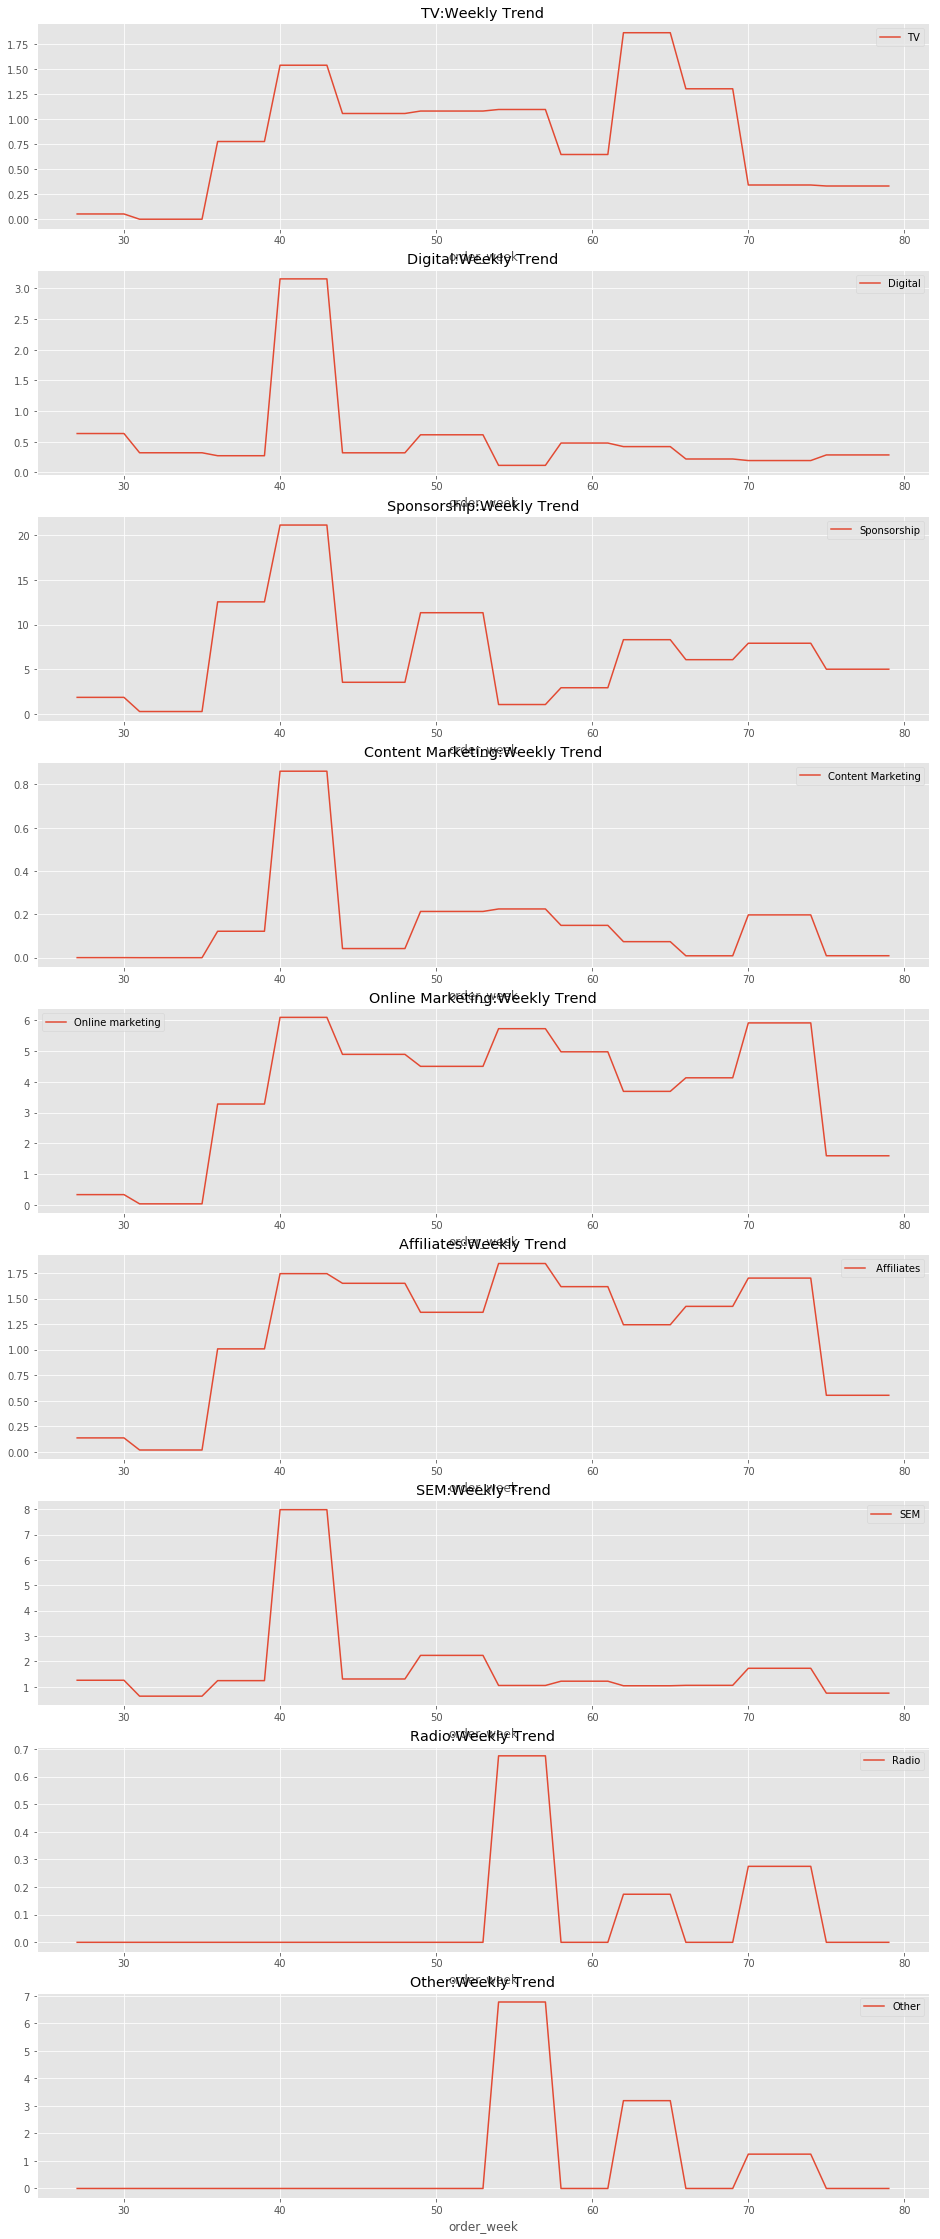

In [127]:
# Lets Analyze the Weekly Spends on different channels
fig = plt.figure(figsize=(16,40))

ax1 = fig.add_subplot(911)
ax1.set_title('TV:Weekly Trend')
ax2 = fig.add_subplot(912)
ax2.set_title('Digital:Weekly Trend')
ax3 = fig.add_subplot(913)
ax3.set_title('Sponsorship:Weekly Trend')
ax4 = fig.add_subplot(914)
ax4.set_title('Content Marketing:Weekly Trend')
ax5 = fig.add_subplot(915)
ax5.set_title('Online Marketing:Weekly Trend')
ax6 = fig.add_subplot(916)
ax6.set_title('Affiliates:Weekly Trend')
ax7 = fig.add_subplot(917)
ax7.set_title('SEM:Weekly Trend')
ax8 = fig.add_subplot(918)
ax8.set_title('Radio:Weekly Trend')
ax9 = fig.add_subplot(919)
ax9.set_title('Other:Weekly Trend')

media_investment_weekly.plot(x= 'order_week',y=['TV'],ax = ax1)
media_investment_weekly.plot(x= 'order_week',y=['Digital'],ax = ax2)
media_investment_weekly.plot(x= 'order_week',y=['Sponsorship'],ax = ax3)
media_investment_weekly.plot(x= 'order_week',y=['Content Marketing'],ax = ax4)
media_investment_weekly.plot(x= 'order_week',y=['Online marketing'],ax = ax5)
media_investment_weekly.plot(x= 'order_week',y=[' Affiliates'],ax = ax6)
media_investment_weekly.plot(x= 'order_week',y=['SEM'],ax = ax7)
media_investment_weekly.plot(x= 'order_week',y=['Radio'],ax = ax8)
media_investment_weekly.plot(x= 'order_week',y=['Other'],ax = ax9)

#### The maximum investments are done between week 39-45 for most channels & maximum investment was done through Sponsorship media

**KPI 9 : Adstock creation**
**Fucntion to create adstocks** 

In [128]:
def getAdStockValue(media_investment_weekly,col_name, adstock_rate):
    media_investment_weekly['week_carry_over_1_value'] = adstock_rate**1 * media_investment_weekly[col_name]
    media_investment_weekly['week_carry_over_2_value'] = adstock_rate**2 * media_investment_weekly[col_name]
    media_investment_weekly['week_carry_over_3_value'] = adstock_rate**3 * media_investment_weekly[col_name]
    media_investment_weekly['week_carry_over_4_value'] = adstock_rate**4 * media_investment_weekly[col_name]
    media_investment_weekly['week_carry_over_5_value'] = adstock_rate**5 * media_investment_weekly[col_name]
    for i in range(0, len(media_investment_weekly)):
        week1CarryOverValue  = media_investment_weekly.loc[i-1,["week_carry_over_1_value"]][0] if(i-1 > -1) else 0
        week2CarryOverValue  = media_investment_weekly.loc[i-2,["week_carry_over_2_value"]][0] if(i-2 > -1) else 0
        week3CarryOverValue  = media_investment_weekly.loc[i-3,["week_carry_over_3_value"]][0] if(i-3 > -1) else 0
        week4CarryOverValue  = media_investment_weekly.loc[i-4,["week_carry_over_4_value"]][0] if(i-4 > -1) else 0
        week5CarryOverValue  = media_investment_weekly.loc[i-5,["week_carry_over_5_value"]][0] if(i-5 > -1) else 0
        media_investment_weekly.loc[i,"adStock_"+col_name] = media_investment_weekly.loc[i,[col_name]][0] + week1CarryOverValue + week2CarryOverValue + week3CarryOverValue + week4CarryOverValue + week5CarryOverValue
    return media_investment_weekly[["order_week","adStock_"+col_name]]

In [129]:
#Creating adstocks for each of the investments by calling the above created function
adStock_TV = getAdStockValue(media_investment_weekly[['TV','order_week']],"TV", 0.5)[["adStock_TV"]]
adStock_digital = getAdStockValue(media_investment_weekly[['Digital','order_week']],"Digital", 0.5)[["adStock_Digital"]]
adStock_sponsorship = getAdStockValue(media_investment_weekly[['Sponsorship','order_week']],"Sponsorship", 0.5)[["adStock_Sponsorship"]]
adStock_content_marketing = getAdStockValue(media_investment_weekly[['Content Marketing','order_week']],"Content Marketing", 0.5)[["adStock_Content Marketing"]]
adStock_online_marketing = getAdStockValue(media_investment_weekly[['Online marketing','order_week']],"Online marketing", 0.5)[["adStock_Online marketing"]]
adStock_affiliates = getAdStockValue(media_investment_weekly[[' Affiliates','order_week']]," Affiliates", 0.5)[["adStock_ Affiliates"]]
adStock_SEM = getAdStockValue(media_investment_weekly[['SEM','order_week']],"SEM", 0.5)[["adStock_SEM"]]
adStock_radio = getAdStockValue(media_investment_weekly[['Radio','order_week']],"Radio", 0.5)[["adStock_Radio"]]
adStock_other = getAdStockValue(media_investment_weekly[['Other','order_week']],"Other", 0.5)

In [130]:
# Concatenating all individual adstocks to form the final DF containing all the adstock data
all_adstock = pd.concat([adStock_TV,adStock_digital,adStock_sponsorship, adStock_content_marketing, adStock_online_marketing, adStock_affiliates, adStock_SEM, adStock_radio, adStock_other], axis = 1)

In [131]:
#Exploring first few rows
all_adstock.head()

,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,order_week,adStock_Other
0,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,27,0.0
1,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,28,0.0
2,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,29,0.0
3,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.0,30,0.0
4,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,0.0,31,0.0


**Merging the adstock data with the media investment data on order week**

In [132]:
final_adstock_data = pd.merge(media_investment_weekly,all_adstock, on = "order_week", how = 'inner')

In [133]:
final_adstock_data

,order_week,Month,Year,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,...,Other,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other
0,27,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,...,0.000000,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.000000,0.000000
1,28,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,...,0.000000,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.000000,0.000000
2,29,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,...,0.000000,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.000000,0.000000
3,30,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,...,0.000000,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.000000,0.000000
4,31,8,2015,5.064306,0.001610,0.319518,0.265833,0.000002,0.032311,0.018421,...,0.000000,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,0.000000,0.000000
5,32,8,2015,5.064306,0.001610,0.319518,0.265833,0.000002,0.032311,0.018421,...,0.000000,0.027648,0.776115,1.267609,0.000112,0.204007,0.091763,1.531288,0.000000,0.000000
6,33,8,2015,5.064306,0.001610,0.319518,0.265833,0.000002,0.032311,0.018421,...,0.000000,0.014593,0.697681,0.870676,0.000054,0.129130,0.062165,1.374402,0.000000,0.000000
7,34,8,2015,5.064306,0.001610,0.319518,0.265833,0.000002,0.032311,0.018421,...,0.000000,0.008065,0.658465,0.672209,0.000025,0.091691,0.047366,1.295959,0.000000,0.000000
8,35,8,2015,5.064306,0.001610,0.319518,0.265833,0.000002,0.032311,0.018421,...,0.000000,0.004801,0.638856,0.572975,0.000010,0.072972,0.039966,1.256738,0.000000,0.000000
9,36,9,2015,96.254380,0.775901,0.271306,12.557530,0.122058,3.275998,1.007653,...,0.000000,0.777460,0.580839,12.815056,0.122060,3.307299,1.025499,1.849175,0.000000,0.000000


In [134]:
final_adstock_data.drop(['Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', ' Affiliates', 'SEM', 'Radio', 'Other'],inplace = True, axis = 1)

In [135]:
#Checking the first few rows
final_adstock_data.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,0.0
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,0.0
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.0,0.0
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,0.0,0.0


**Let's now visualise the correlations b/w the adstocks to check for colinearity**

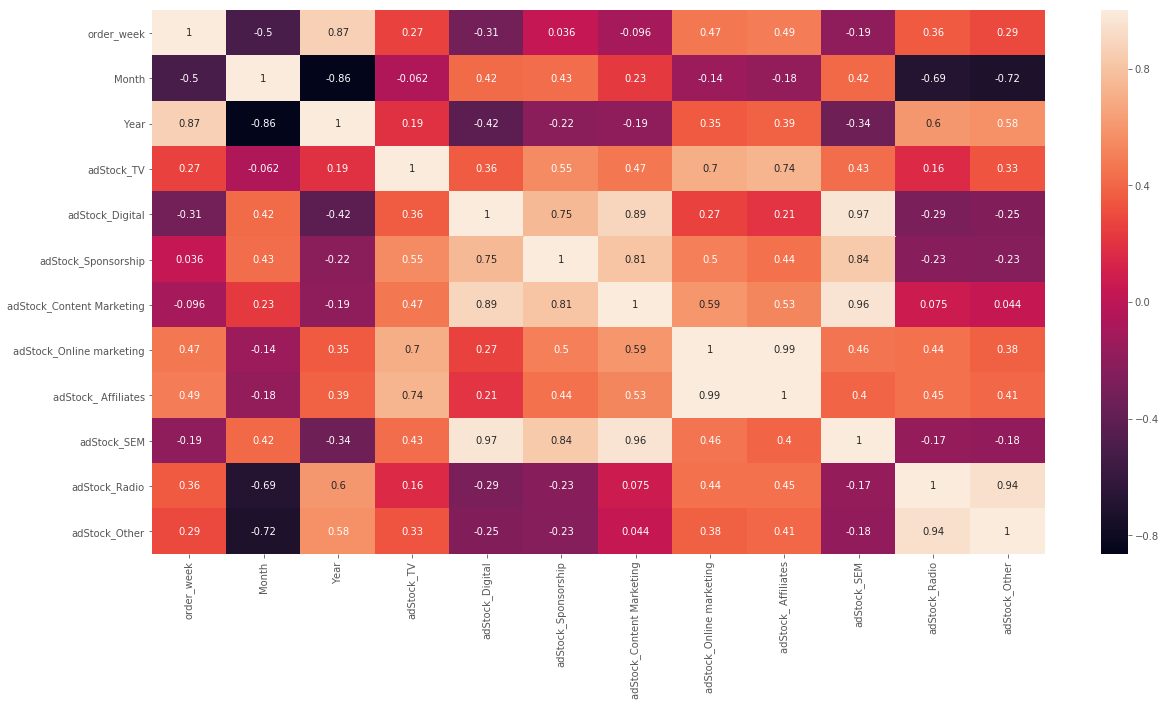

In [136]:

plt.figure(figsize = (20,10))
sns.heatmap(final_adstock_data.corr(), annot = True)

**As we see above, there is high correlation b/w**

- order_week & month, year & month, order_week & year
- adStock_Affiliates & adStock_Online marketing
- adStock_Other & adStock_Radio
- adStock_Digital & adStock_SEM
- adStock_Content Marketing & adStock_SEM
- Month & adstock_radio, Month & adstock_others
- adStock_TV & adStock_affiliates
- adStock_Sponsorship & adStock_Content Marketing

In [137]:
#Preparing final_data for 3 categories by adding the adstock data
final_camera_data = pd.merge(final_adstock_data,final_camera_data, on = "order_week", how = 'right')
final_gaming_data = pd.merge(final_adstock_data,final_gaming_data, on = "order_week", how = 'right')
final_home_audio_data = pd.merge(final_adstock_data,final_home_audio_data, on = "order_week", how = 'right')

In [138]:
#Checking the shape of the final dataframes
print("Shape of Gaming Accessory DF",final_gaming_data.shape)
print("Shape of Camera Accessory DF",final_camera_data.shape)
print("Shape of Home Audio DF",final_home_audio_data.shape)

Shape of Gaming Accessory DF (53, 43)
Shape of Camera Accessory DF (52, 50)
Shape of Home Audio DF (50, 38)


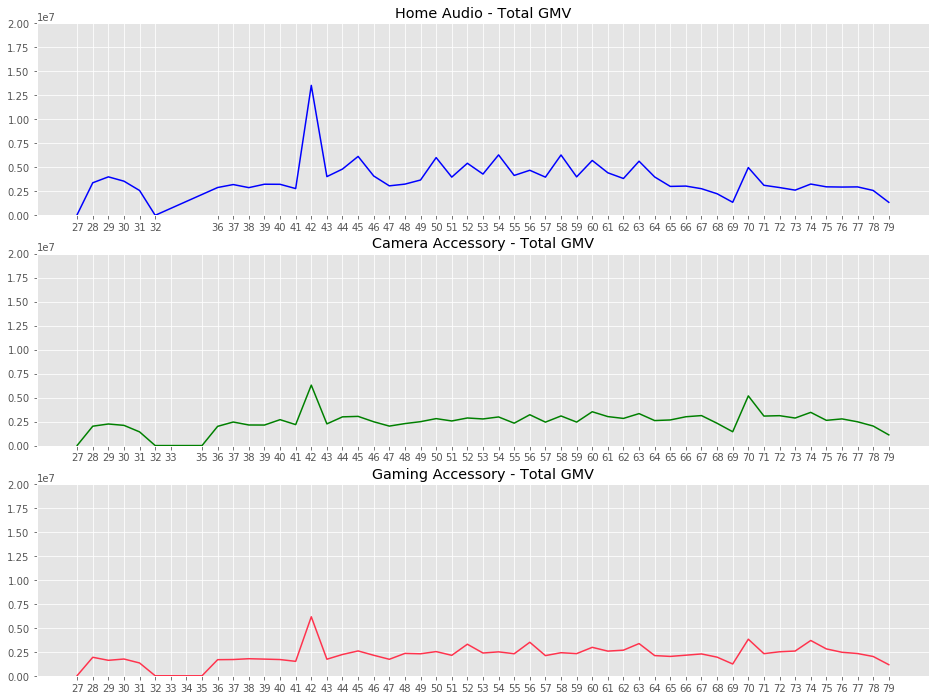

In [139]:
## Total GMV vs Week
fig, axes= plt.subplots(nrows=3, ncols=1,figsize=(16,12))

# subplot 1
ax1 = plt.subplot(3,1,1)
ax1.set_ylim(0,20000000)
ax1 = plt.title('Home Audio - Total GMV')
ax1 = plt.plot(final_home_audio_data['order_week'],final_home_audio_data['gmv'],color='blue')
plt.xticks(final_home_audio_data['order_week'])

# subplot 2
ax2 = plt.subplot(3,1,2)
ax2.set_ylim(0,20000000)
ax2 = plt.title('Camera Accessory - Total GMV')
ax2 = plt.plot(final_camera_data['order_week'],final_camera_data['gmv'],color='g')
plt.xticks(final_camera_data['order_week'])

# subplot 3
ax3 = plt.subplot(3,1,3)
ax3.set_ylim(0,20000000)
ax3 = plt.title('Gaming Accessory - Total GMV')
ax3 = plt.plot(final_gaming_data['order_week'],final_gaming_data['gmv'],color=(1.0,0.2,0.3))
plt.xticks(final_gaming_data['order_week'])

plt.show()


#### Highest GMV seems to be around week 42 for all categories with the maximum gmv for HomeAudio

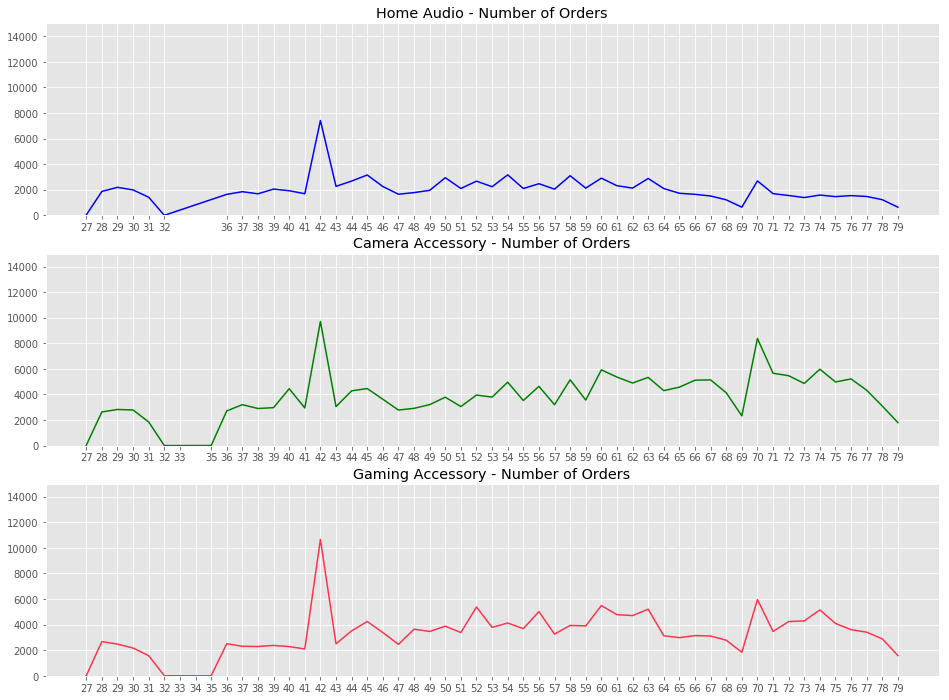

In [140]:
## No of Orders vs Week
fig, axes= plt.subplots(nrows=3, ncols=1,figsize=(16,12))

# subplot 1
ax1 = plt.subplot(3,1,1)
ax1.set_ylim(0,15000)
ax1 = plt.title('Home Audio - Number of Orders')
ax1 = plt.plot(final_home_audio_data['order_week'],final_home_audio_data['total_transactions'],color='blue')
plt.xticks(final_home_audio_data['order_week'])

# subplot 2
ax2 = plt.subplot(3,1,2)
ax2.set_ylim(0,15000)
ax2 = plt.title('Camera Accessory - Number of Orders')
ax2 = plt.plot(final_camera_data['order_week'],final_camera_data['total_transactions'],color='g')
plt.xticks(final_camera_data['order_week'])

# subplot 3
ax3 = plt.subplot(3,1,3)
ax3.set_ylim(0,15000)
ax3 = plt.title('Gaming Accessory - Number of Orders')
ax3 = plt.plot(final_gaming_data['order_week'],final_gaming_data['total_transactions'],color=(1.0,0.2,0.3))
plt.xticks(final_gaming_data['order_week'])

plt.show()

#### Highest number of transactions are around week 42 with maximum transactions for Gaming Accessory

In [141]:
## Holiday week vs Average GMV
Holiday_week_sale_HA = final_home_audio_data.groupby('is_holiday')[['gmv']].mean().reset_index()
Holiday_week_sale_CA = final_camera_data.groupby('is_holiday')[['gmv']].mean().reset_index()
Holiday_week_sale_GA = final_gaming_data.groupby('is_holiday')[['gmv']].mean().reset_index()

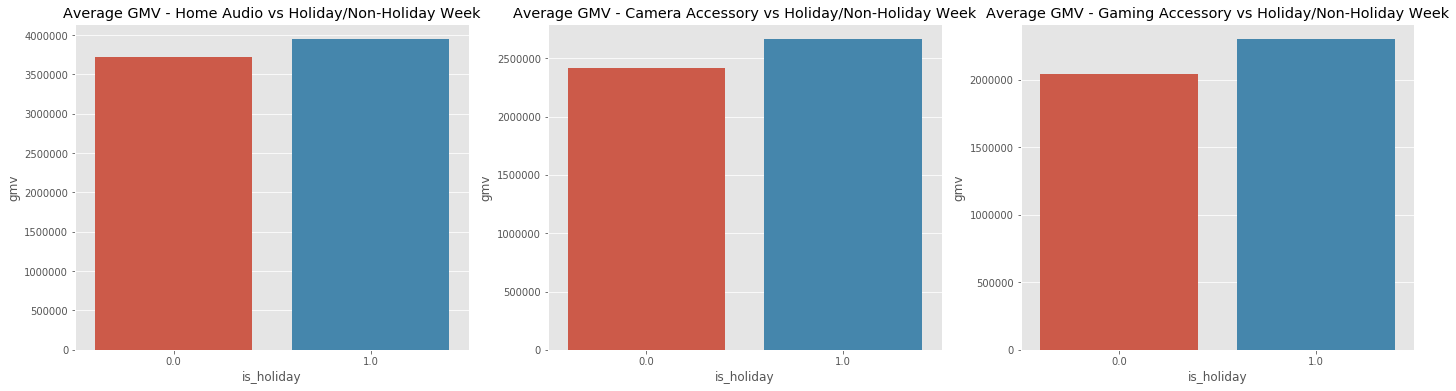

In [142]:
# increase figure size 
plt.figure(figsize=(24,6))

# subplot 1: Average GMV - Home Audio vs Holiday/Non-Holiday Week
ax1 = plt.subplot(1, 3, 1)
# ax1.set_ylim(0,8000000)
ax1 = sns.barplot(x='is_holiday', y='gmv', data=Holiday_week_sale_HA)
ax1 = plt.title("Average GMV - Home Audio vs Holiday/Non-Holiday Week")

# subplot 3: Average GMV - Camera Accessory vs Holiday/Non-Holiday Week
ax2 = plt.subplot(1, 3, 2)
# ax2.set_ylim(0,8000000)
ax2 = sns.barplot(x='is_holiday', y='gmv', data=Holiday_week_sale_CA)
ax2 = plt.title("Average GMV - Camera Accessory vs Holiday/Non-Holiday Week")

# subplot 5: Average GMV - Gaming Accessory vs Holiday/Non-Holiday Week
ax3 = plt.subplot(1, 3, 3)
# ax3.set_ylim(0,8000000)
ax3 = sns.barplot(x='is_holiday', y='gmv', data=Holiday_week_sale_GA)
ax3 = plt.title("Average GMV - Gaming Accessory vs Holiday/Non-Holiday Week")

plt.show()

In [143]:
## Holiday week vs Average GMV
Holiday_week_sale_HA = final_home_audio_data.groupby('is_holiday')[['gmv']].sum().reset_index()
Holiday_week_sale_CA = final_camera_data.groupby('is_holiday')[['gmv']].sum().reset_index()
Holiday_week_sale_GA = final_gaming_data.groupby('is_holiday')[['gmv']].sum().reset_index()

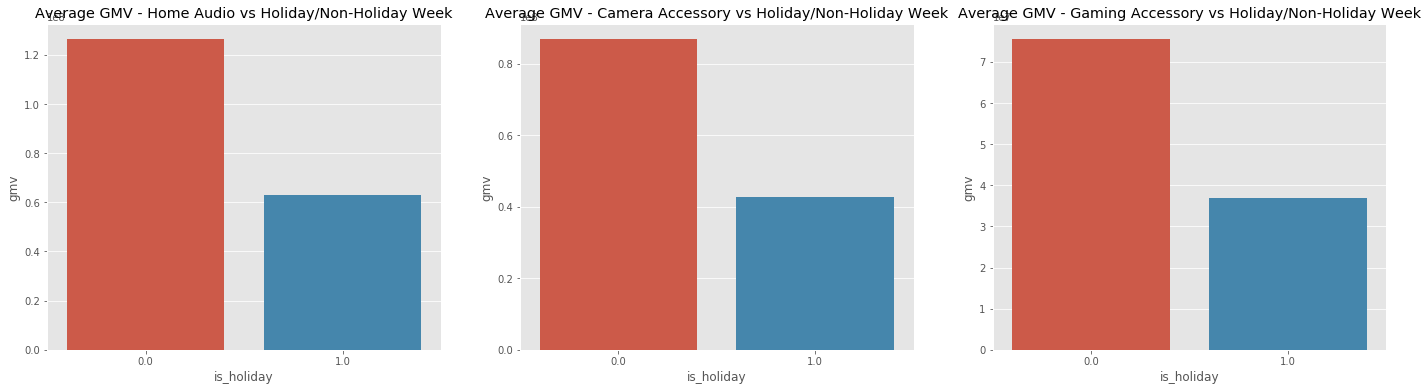

In [144]:
# increase figure size 
plt.figure(figsize=(24,6))

# subplot 1: Average GMV - Home Audio vs Holiday/Non-Holiday Week
ax1 = plt.subplot(1, 3, 1)
# ax1.set_ylim(0,8000000)
ax1 = sns.barplot(x='is_holiday', y='gmv', data=Holiday_week_sale_HA)
ax1 = plt.title("Average GMV - Home Audio vs Holiday/Non-Holiday Week")

# subplot 3: Average GMV - Camera Accessory vs Holiday/Non-Holiday Week
ax2 = plt.subplot(1, 3, 2)
# ax2.set_ylim(0,8000000)
ax2 = sns.barplot(x='is_holiday', y='gmv', data=Holiday_week_sale_CA)
ax2 = plt.title("Average GMV - Camera Accessory vs Holiday/Non-Holiday Week")

# subplot 5: Average GMV - Gaming Accessory vs Holiday/Non-Holiday Week
ax3 = plt.subplot(1, 3, 3)
# ax3.set_ylim(0,8000000)
ax3 = sns.barplot(x='is_holiday', y='gmv', data=Holiday_week_sale_GA)
ax3 = plt.title("Average GMV - Gaming Accessory vs Holiday/Non-Holiday Week")

plt.show()

#### From the above two graphs(mean and sum), overall, total gmv on weeks without holidays is more, however mean_gmv for weeks with holiday is higher.


In [145]:
## Speacial Sale week vs Average GMV
Special_week_sale_HA = final_home_audio_data.groupby('is_special_sale_day')[['gmv']].mean().reset_index()
Special_week_sale_CA = final_camera_data.groupby('is_special_sale_day')[['gmv']].mean().reset_index()
Special_week_sale_GA = final_gaming_data.groupby('is_special_sale_day')[['gmv']].mean().reset_index()

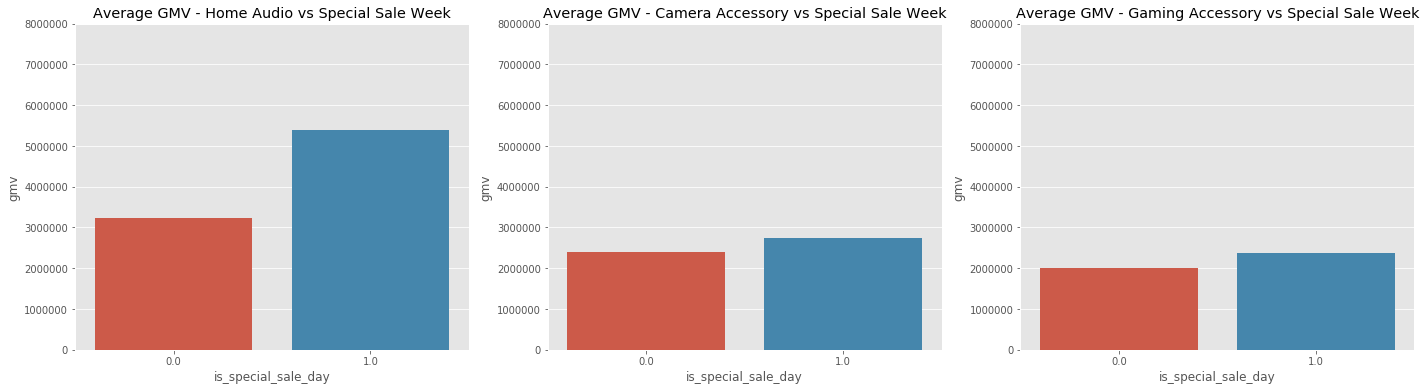

In [146]:
# increase figure size 
plt.figure(figsize=(24,6))

# subplot 1: Average GMV - Home Audio vs Special Sale Week
ax1 = plt.subplot(1, 3, 1)
ax1.set_ylim(0,8000000)
ax1 = sns.barplot(x='is_special_sale_day', y='gmv', data=Special_week_sale_HA)
ax1 = plt.title("Average GMV - Home Audio vs Special Sale Week")

# subplot 3: Average GMV - Camera Accessory vs Holiday/Non-Holiday Week
ax2 = plt.subplot(1, 3, 2)
ax2.set_ylim(0,8000000)
ax2 = sns.barplot(x='is_special_sale_day', y='gmv', data=Special_week_sale_CA)
ax2 = plt.title("Average GMV - Camera Accessory vs Special Sale Week")

# subplot 5: Average GMV - Gaming Accessory vs Holiday/Non-Holiday Week
ax3 = plt.subplot(1, 3, 3)
ax3.set_ylim(0,8000000)
ax3 = sns.barplot(x='is_special_sale_day', y='gmv', data=Special_week_sale_GA)
ax3 = plt.title("Average GMV - Gaming Accessory vs Special Sale Week")

plt.show()

In [147]:
## Pay day week vs Average GMV
PayDay_week_sale_HA = final_home_audio_data.groupby('is_pay_day')[['gmv']].mean().reset_index()
PayDay_week_sale_CA = final_camera_data.groupby('is_pay_day')[['gmv']].mean().reset_index()
PayDay_week_sale_GA = final_gaming_data.groupby('is_pay_day')[['gmv']].mean().reset_index()

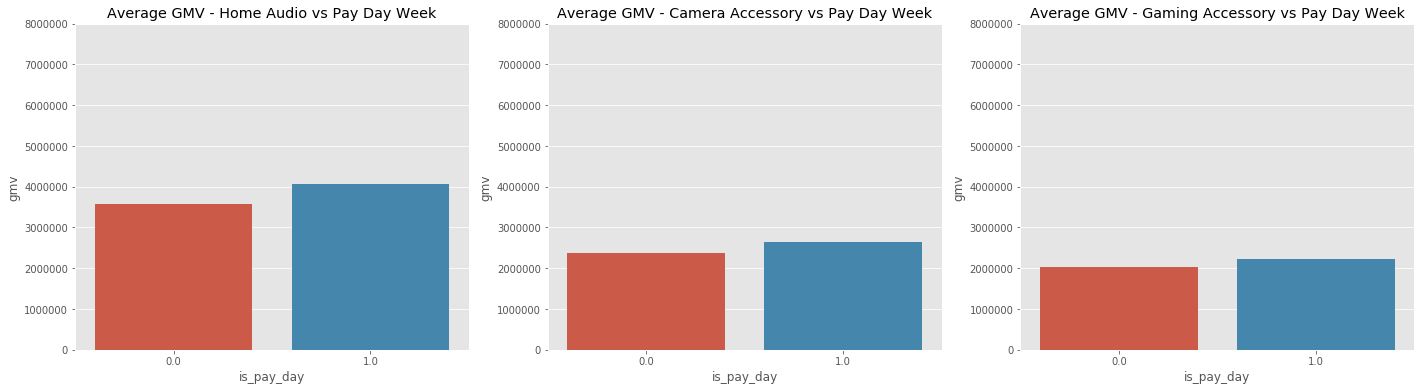

In [148]:
# increase figure size 
plt.figure(figsize=(24,6))

# subplot 1: Average GMV - Home Audio vs Pay Day Week
ax1 = plt.subplot(1, 3, 1)
ax1.set_ylim(0,8000000)
ax1 = sns.barplot(x='is_pay_day', y='gmv', data=PayDay_week_sale_HA)
ax1 = plt.title("Average GMV - Home Audio vs Pay Day Week")

# subplot 3: Average GMV - Camera Accessory vs Pay Day Week
ax2 = plt.subplot(1, 3, 2)
ax2.set_ylim(0,8000000)
ax2 = sns.barplot(x='is_pay_day', y='gmv', data=PayDay_week_sale_CA)
ax2 = plt.title("Average GMV - Camera Accessory vs Pay Day Week")

# subplot 5: Average GMV - Gaming Accessory vs Pay Day Week
ax3 = plt.subplot(1, 3, 3)
ax3.set_ylim(0,8000000)
ax3 = sns.barplot(x='is_pay_day', y='gmv', data=PayDay_week_sale_GA)
ax3 = plt.title("Average GMV - Gaming Accessory vs Pay Day Week")

plt.show()

In [149]:
## Pay Day week vs Total GMV
PayDay_week_sale_HA = final_home_audio_data.groupby('is_pay_day')[['gmv']].sum().reset_index()
PayDay_week_sale_CA = final_camera_data.groupby('is_pay_day')[['gmv']].sum().reset_index()
PayDay_week_sale_GA = final_gaming_data.groupby('is_pay_day')[['gmv']].sum().reset_index()

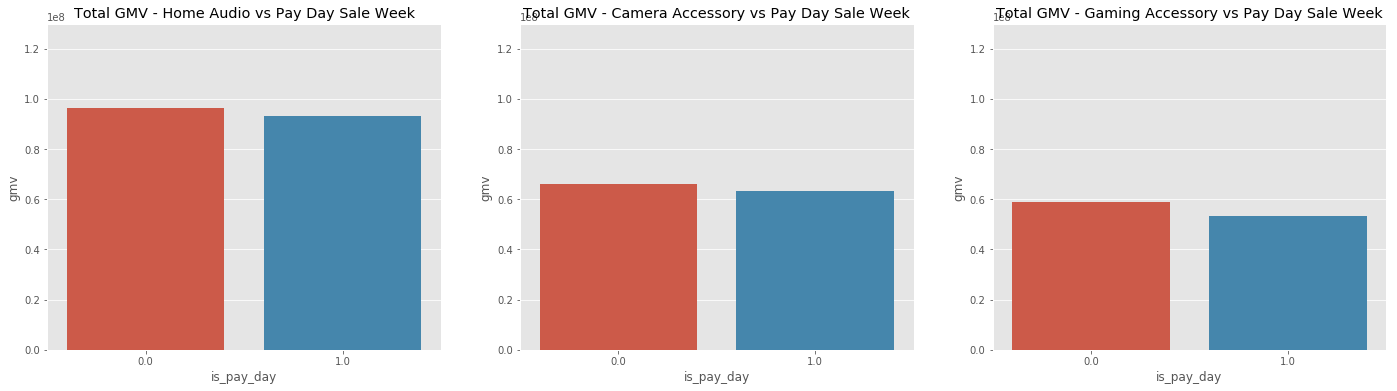

In [150]:
# increase figure size 
plt.figure(figsize=(24,6))

# subplot 1: Total GMV - Home Audio vs Pay Day Sale Week
ax1 = plt.subplot(1, 3, 1)
ax1.set_ylim(0,130000000)
ax1 = sns.barplot(x='is_pay_day', y='gmv', data=PayDay_week_sale_HA)
ax1 = plt.title("Total GMV - Home Audio vs Pay Day Sale Week")

# subplot 3: Total GMV - Camera Accessory vs Pay Day Sale Week
ax2 = plt.subplot(1, 3, 2)
ax2.set_ylim(0,130000000)
ax2 = sns.barplot(x='is_pay_day', y='gmv', data=PayDay_week_sale_CA)
ax2 = plt.title("Total GMV - Camera Accessory vs Pay Day Sale Week")

# subplot 5: Total GMV - Gaming Accessory vs Pay Day Sale Week
ax3 = plt.subplot(1, 3, 3)
ax3.set_ylim(0,130000000)
ax3 = sns.barplot(x='is_pay_day', y='gmv', data=PayDay_week_sale_GA)
ax3 = plt.title("Total GMV - Gaming Accessory vs Pay Day Sale Week")

plt.show()

#### From the above two graphs(mean and sum), overall, total gmv on weeks without holidays is more, however mean_gmv for weeks with holiday is higher

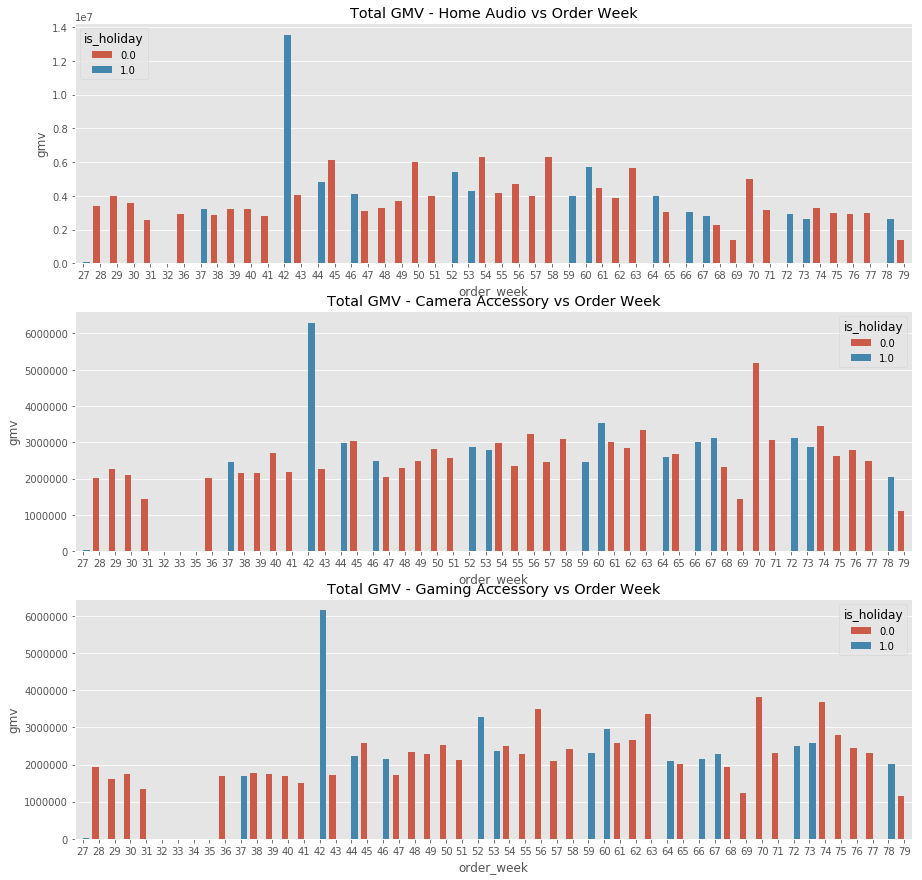

In [151]:
#Analyzing the total gmv over the weeks based upon whether the week contained a holiday or not for all the three categories
plt.figure(figsize = (15,15))
ax1 = plt.subplot(3, 1, 1)
ax1 = sns.barplot(x = 'order_week', y = 'gmv', data = final_home_audio_data, hue = 'is_holiday')
ax1 = plt.title("Total GMV - Home Audio vs Order Week")

ax1 = plt.subplot(3, 1, 2)
ax1 = sns.barplot(x = 'order_week', y = 'gmv', data = final_camera_data, hue = 'is_holiday')
ax1 = plt.title("Total GMV - Camera Accessory vs Order Week")

ax1 = plt.subplot(3, 1, 3)
ax1 = sns.barplot(x = 'order_week', y = 'gmv', data = final_gaming_data, hue = 'is_holiday')
ax1 = plt.title("Total GMV - Gaming Accessory vs Order Week")


**Highest amoung of  sales can be seen in the 42nd week across all the 3 categories.**

**Analyzing the total gmv over the weeks based upon specialday present in week for all the three 
categories**

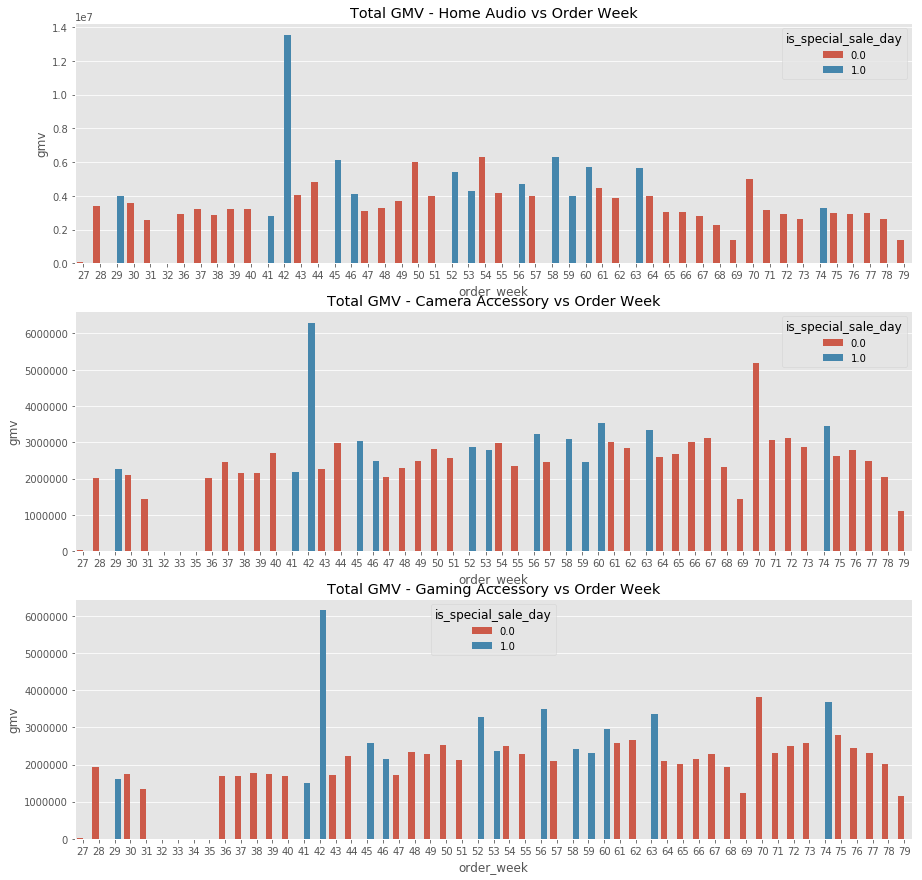

In [152]:

plt.figure(figsize = (15,15))
ax1 = plt.subplot(3, 1, 1)
ax1 = sns.barplot(x = 'order_week', y = 'gmv', data = final_home_audio_data, hue = 'is_special_sale_day')
ax1 = plt.title("Total GMV - Home Audio vs Order Week")

ax1 = plt.subplot(3, 1, 2)
ax1 = sns.barplot(x = 'order_week', y = 'gmv', data = final_camera_data, hue = 'is_special_sale_day')
ax1 = plt.title("Total GMV - Camera Accessory vs Order Week")

ax1 = plt.subplot(3, 1, 3)
ax1 = sns.barplot(x = 'order_week', y = 'gmv', data = final_gaming_data, hue = 'is_special_sale_day')
ax1 = plt.title("Total GMV - Gaming Accessory vs Order Week")


**Plot to see the trend b/w product_procurement_sla & NPS**

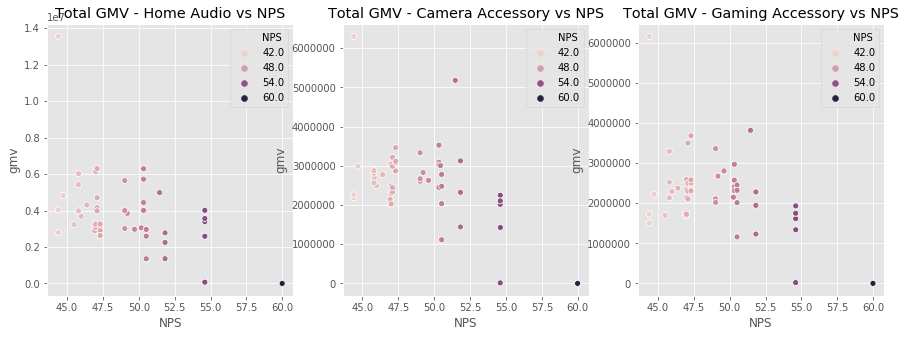

In [153]:
plt.figure(figsize = (15,5))
ax1 = plt.subplot(1, 3, 1)
ax1 = sns.scatterplot(x = 'NPS', y = 'gmv', data = final_home_audio_data, hue = 'NPS')
ax1 = plt.title("Total GMV - Home Audio vs NPS")

ax1 = plt.subplot(1, 3, 2)
ax1 = sns.scatterplot(x = 'NPS', y = 'gmv', data = final_camera_data, hue = 'NPS')
ax1 = plt.title("Total GMV - Camera Accessory vs NPS")

ax1 = plt.subplot(1, 3, 3)
ax1 = sns.scatterplot(x = 'NPS', y = 'gmv', data = final_gaming_data, hue = 'NPS')
ax1 = plt.title("Total GMV - Gaming Accessory vs NPS")


**A negative relation can be seen b/w the NPS & GMV for all the three categories**

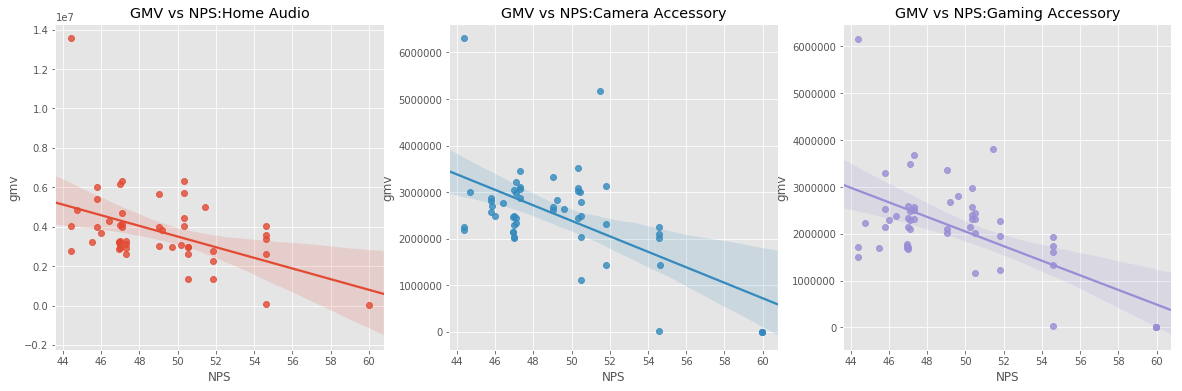

In [154]:
fig = plt.figure(figsize=(20,6))

ax1 = fig.add_subplot(131)
ax1.set_title('GMV vs NPS:Home Audio')
ax2 = fig.add_subplot(132)
ax2.set_title('GMV vs NPS:Camera Accessory')
ax3 = fig.add_subplot(133)
ax3.set_title('GMV vs NPS:Gaming Accessory')

sns.regplot(final_home_audio_data['NPS'],final_home_audio_data['gmv'],ax = ax1)
sns.regplot(final_camera_data['NPS'],final_camera_data['gmv'],ax = ax2)
sns.regplot(final_gaming_data['NPS'],final_gaming_data['gmv'],ax = ax3) 

##### A negative realtion can be seen b/w the NPS & GMV

### Climate Feature

In [155]:
climate_2015 = pd.read_csv('ONTARIO-2015.csv', skiprows=24)

climate_2015.head()


,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,2015-01-01,2015,1,1,†,0.0,NaN,-8.5,NaN,-4.3,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,2015,1,2,†,3.0,NaN,-3.0,NaN,0.0,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,2015,1,3,†,2.5,NaN,-4.0,NaN,-0.8,...,0.0,NaN,24.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,2015,1,4,†,2.5,NaN,0.0,NaN,1.3,...,1.0,NaN,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,2015,1,5,†,-10.0,NaN,-13.5,NaN,-11.8,...,3.0,NaN,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [156]:
# Skipping the first 24 rows while reading the data to ignore the metadata

climate_2016 = pd.read_csv('ONTARIO-2016.csv', skiprows=24)

climate_2016.head()

,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,2016-01-01,2016,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,2016,1,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,2016,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,2016,1,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-05,2016,1,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [157]:
# Dropping the columns with all nulls

climate_2015.dropna(axis=1, thresh=1, inplace=True)

climate_2015.reset_index(drop=True, inplace=True)

climate_2016.dropna(axis=1, thresh=1, inplace=True)

climate_2016.reset_index(drop=True, inplace=True)

climate_2016.head(10)

,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),...,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag
0,2016-01-01,2016,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,2016,1,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,2016,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,2016,1,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-05,2016,1,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2016-01-06,2016,1,6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2016-01-07,2016,1,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2016-01-08,2016,1,8,†,7.0,NaN,-14.0,NaN,-3.5,...,0.0,NaN,9.0,NaN,0.0,NaN,9.0,NaN,0.0,NaN
8,2016-01-09,2016,1,9,†,11.0,NaN,3.0,NaN,7.0,...,0.0,NaN,14.6,NaN,0.0,T,14.6,NaN,0.0,NaN
9,2016-01-10,2016,1,10,†,-1.5,NaN,-5.0,NaN,-3.3,...,0.0,NaN,0.0,NaN,7.0,NaN,7.0,NaN,0.0,T


In [158]:
# Dropping columns with only one distinct value

drop_cols = []

for col in climate_2015.columns:
    if 'Flag' in col:
        print(climate_2015[col].value_counts())
        print()
        drop_cols.append(col)

drop_cols.append('Data Quality')

climate_2015.drop(drop_cols, axis=1, inplace=True)

print(climate_2015.columns)

M    13
Name: Max Temp Flag, dtype: int64

M    39
Name: Min Temp Flag, dtype: int64

M    39
Name: Mean Temp Flag, dtype: int64

M    39
Name: Heat Deg Days Flag, dtype: int64

M    39
Name: Cool Deg Days Flag, dtype: int64

T    7
Name: Total Rain Flag, dtype: int64

T    9
Name: Total Snow Flag, dtype: int64

T    12
Name: Total Precip Flag, dtype: int64

T    2
Name: Snow on Grnd Flag, dtype: int64

Index(['Date/Time', 'Year', 'Month', 'Day', 'Max Temp (°C)', 'Min Temp (°C)',
       'Mean Temp (°C)', 'Heat Deg Days (°C)', 'Cool Deg Days (°C)',
       'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
       'Snow on Grnd (cm)'],
      dtype='object')


In [159]:
# Dropping columns with only one distinct value

drop_cols = []

for col in climate_2016.columns:
    if 'Flag' in col:
        print(climate_2016[col].value_counts())
        print()
        drop_cols.append(col)

drop_cols.append('Data Quality')

climate_2016.drop(drop_cols, axis=1, inplace=True)

print(climate_2016.columns)

M    1
Name: Max Temp Flag, dtype: int64

M    8
Name: Min Temp Flag, dtype: int64

M    8
Name: Mean Temp Flag, dtype: int64

M    8
Name: Heat Deg Days Flag, dtype: int64

M    8
Name: Cool Deg Days Flag, dtype: int64

T    3
Name: Total Rain Flag, dtype: int64

T    7
Name: Total Snow Flag, dtype: int64

T    7
Name: Total Precip Flag, dtype: int64

T    6
Name: Snow on Grnd Flag, dtype: int64

Index(['Date/Time', 'Year', 'Month', 'Day', 'Max Temp (°C)', 'Min Temp (°C)',
       'Mean Temp (°C)', 'Heat Deg Days (°C)', 'Cool Deg Days (°C)',
       'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
       'Snow on Grnd (cm)'],
      dtype='object')


In [160]:
# Formatting column names

climate_2015.columns = [col.replace(' (°C)','').strip() for col in climate_2015.columns]
climate_2016.columns = [col.replace(' (°C)','').strip() for col in climate_2016.columns]
climate_2015.columns

Index(['Date/Time', 'Year', 'Month', 'Day', 'Max Temp', 'Min Temp',
       'Mean Temp', 'Heat Deg Days', 'Cool Deg Days', 'Total Rain (mm)',
       'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)'],
      dtype='object')

In [161]:
# Dropping rows where all the columns have nulls

cols = ['Mean Temp',
 'Total Rain (mm)']

climate_2015.dropna(subset=cols, inplace=True)

climate_2015.reset_index(drop=True, inplace=True)

climate_2016.dropna(subset=cols, inplace=True)

climate_2016.reset_index(drop=True, inplace=True)

climate_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 13 columns):
Date/Time            190 non-null object
Year                 190 non-null int64
Month                190 non-null int64
Day                  190 non-null int64
Max Temp             190 non-null float64
Min Temp             190 non-null float64
Mean Temp            190 non-null float64
Heat Deg Days        190 non-null float64
Cool Deg Days        190 non-null float64
Total Rain (mm)      190 non-null float64
Total Snow (cm)      190 non-null float64
Total Precip (mm)    190 non-null float64
Snow on Grnd (cm)    190 non-null float64
dtypes: float64(9), int64(3), object(1)
memory usage: 19.4+ KB


In [162]:
climate_2015.head()

,Date/Time,Year,Month,Day,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm)
0,2015-01-01,2015,1,1,0.0,-8.5,-4.3,22.3,0.0,0.0,0.0,0.0,0.0
1,2015-01-02,2015,1,2,3.0,-3.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0
2,2015-01-03,2015,1,3,2.5,-4.0,-0.8,18.8,0.0,24.0,0.0,24.0,0.0
3,2015-01-04,2015,1,4,2.5,0.0,1.3,16.7,0.0,0.0,1.0,1.0,0.0
4,2015-01-05,2015,1,5,-10.0,-13.5,-11.8,29.8,0.0,0.0,3.0,3.0,1.0


In [163]:
import datetime

In [164]:
# Extracting week # from the date field and formatting it

climate_2015['order_week'] = climate_2015['Date/Time'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime("%V"))

climate_2015['order_week'] = climate_2015['order_week'].apply(lambda x: str(x).lstrip('0'))

climate_2015.head()

,Date/Time,Year,Month,Day,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),order_week
0,2015-01-01,2015,1,1,0.0,-8.5,-4.3,22.3,0.0,0.0,0.0,0.0,0.0,1
1,2015-01-02,2015,1,2,3.0,-3.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,1
2,2015-01-03,2015,1,3,2.5,-4.0,-0.8,18.8,0.0,24.0,0.0,24.0,0.0,1
3,2015-01-04,2015,1,4,2.5,0.0,1.3,16.7,0.0,0.0,1.0,1.0,0.0,1
4,2015-01-05,2015,1,5,-10.0,-13.5,-11.8,29.8,0.0,0.0,3.0,3.0,1.0,2


In [165]:
# Extracting week # from the date field and formatting it

climate_2016['order_week'] = climate_2016['Date/Time'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime("%V"))

climate_2016['order_week'] = climate_2016['order_week'].apply(lambda x: str(x).lstrip('0'))

climate_2016.head()

,Date/Time,Year,Month,Day,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),order_week
0,2016-01-08,2016,1,8,7.0,-14.0,-3.5,21.5,0.0,9.0,0.0,9.0,0.0,1
1,2016-01-09,2016,1,9,11.0,3.0,7.0,11.0,0.0,14.6,0.0,14.6,0.0,1
2,2016-01-10,2016,1,10,-1.5,-5.0,-3.3,21.3,0.0,0.0,7.0,7.0,0.0,1
3,2016-01-12,2016,1,12,-5.0,-12.0,-8.5,26.5,0.0,0.0,0.0,0.0,12.0,2
4,2016-01-14,2016,1,14,2.5,-10.5,-4.0,22.0,0.0,0.0,0.0,0.0,11.0,2


In [166]:
climate_2015['order_week'] = climate_2015['order_week'].astype(int)

In [167]:
climate_2016['order_week'] = climate_2016['order_week'].astype(int)

In [168]:
#Mapping order_week according to the new logic
climate_2016['order_week'] = climate_2016.apply(lambda x: mapWeek(x['order_week'],x['Year']), axis = 1)

In [169]:
climate_2016.head()

,Date/Time,Year,Month,Day,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),order_week
0,2016-01-08,2016,1,8,7.0,-14.0,-3.5,21.5,0.0,9.0,0.0,9.0,0.0,54
1,2016-01-09,2016,1,9,11.0,3.0,7.0,11.0,0.0,14.6,0.0,14.6,0.0,54
2,2016-01-10,2016,1,10,-1.5,-5.0,-3.3,21.3,0.0,0.0,7.0,7.0,0.0,54
3,2016-01-12,2016,1,12,-5.0,-12.0,-8.5,26.5,0.0,0.0,0.0,0.0,12.0,55
4,2016-01-14,2016,1,14,2.5,-10.5,-4.0,22.0,0.0,0.0,0.0,0.0,11.0,55


In [170]:


# Extracting July to Dec month's data

climate_2015 = climate_2015[climate_2015['Month'] >= 7]
climate_2015.reset_index(drop=True, inplace=True)

climate_2015.head()

,Date/Time,Year,Month,Day,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),order_week
0,2015-07-01,2015,7,1,24.5,17.0,20.8,0.0,2.8,0.0,0.0,0.0,0.0,27
1,2015-07-02,2015,7,2,24.0,14.0,19.0,0.0,1.0,0.0,0.0,0.0,0.0,27
2,2015-07-03,2015,7,3,25.0,10.0,17.5,0.5,0.0,0.0,0.0,0.0,0.0,27
3,2015-07-04,2015,7,4,26.0,11.0,18.5,0.0,0.5,0.0,0.0,0.0,0.0,27
4,2015-07-05,2015,7,5,28.0,14.0,21.0,0.0,3.0,0.0,0.0,0.0,0.0,27


In [171]:
# Extracting Jan to June month's data

climate_2016 = climate_2016[climate_2016['Month'] <= 6]
climate_2016.reset_index(drop=True, inplace=True)

climate_2016.head()

,Date/Time,Year,Month,Day,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),order_week
0,2016-01-08,2016,1,8,7.0,-14.0,-3.5,21.5,0.0,9.0,0.0,9.0,0.0,54
1,2016-01-09,2016,1,9,11.0,3.0,7.0,11.0,0.0,14.6,0.0,14.6,0.0,54
2,2016-01-10,2016,1,10,-1.5,-5.0,-3.3,21.3,0.0,0.0,7.0,7.0,0.0,54
3,2016-01-12,2016,1,12,-5.0,-12.0,-8.5,26.5,0.0,0.0,0.0,0.0,12.0,55
4,2016-01-14,2016,1,14,2.5,-10.5,-4.0,22.0,0.0,0.0,0.0,0.0,11.0,55


In [172]:
climate_2015.sort_values(by=['order_week'], ascending = True, inplace = True)


In [173]:
climate_2016.sort_values(by=['order_week'], ascending = True, inplace = True)

In [174]:
# Getting weekly data

climate_2015 = climate_2015.groupby(['order_week']).agg({'Max Temp':"max", 'Min Temp':"min", 'Mean Temp':"mean", 'Heat Deg Days':"mean", 'Cool Deg Days':"mean", 'Total Rain (mm)':"mean", 'Total Snow (cm)':"mean", 'Total Precip (mm)':"mean", 'Snow on Grnd (cm)':"mean"}).reset_index(drop=False)

climate_2015.head()

,order_week,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm)
0,27,28.0,10.0,19.360000,0.100000,1.460000,0.000000,0.0,0.000000,0.0
1,28,28.0,12.5,20.100000,0.283333,2.383333,4.416667,0.0,4.416667,0.0
2,29,33.0,11.0,23.183333,0.000000,5.183333,1.400000,0.0,1.400000,0.0
3,30,31.5,14.5,23.060000,0.000000,5.060000,1.080000,0.0,1.080000,0.0
4,31,33.5,16.0,24.566667,0.000000,6.566667,4.633333,0.0,4.633333,0.0


In [175]:
# Getting weekly data

climate_2016 = climate_2016.groupby(['order_week']).agg({'Max Temp':"max", 'Min Temp':"min", 'Mean Temp':"mean", 'Heat Deg Days':"mean", 'Cool Deg Days':"mean", 'Total Rain (mm)':"mean", 'Total Snow (cm)':"mean", 'Total Precip (mm)':"mean", 'Snow on Grnd (cm)':"mean"}).reset_index(drop=False)

climate_2016.head()

,order_week,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm)
0,54,11.0,-14.0,0.066667,17.933333,0.0,7.866667,2.333333,10.200000,0.000000
1,55,4.5,-12.0,-3.733333,21.733333,0.0,2.533333,0.000000,2.533333,10.333333
2,57,5.5,-9.0,-1.800000,19.800000,0.0,0.000000,0.000000,0.000000,0.000000
3,58,13.0,-5.5,3.200000,14.800000,0.0,3.400000,0.000000,3.400000,0.000000
4,59,5.0,-18.0,-7.266667,25.266667,0.0,0.000000,2.666667,2.666667,2.000000


**Checking duplicates**

In [176]:
climate_2015.duplicated().any()

False

In [177]:
climate_2016.duplicated().any()

False

In [178]:
climate_2015.isnull().values.any()

False

In [179]:
climate_2016.isnull().values.any()

False

In [180]:
climate = pd.concat([climate_2015, climate_2016], axis = 0)

climate.shape

(52, 10)

In [181]:
# Dropping redundant columns
climate_data=climate.drop('Max Temp',axis=1)
climate_data=climate_data.drop('Min Temp',axis=1)
climate_data=climate_data.drop('Heat Deg Days',axis=1)
climate_data=climate_data.drop('Cool Deg Days',axis=1)
climate_data=climate_data.drop('Total Snow (cm)',axis=1)
climate_data=climate_data.drop('Total Precip (mm)',axis=1)
climate_data=climate_data.drop('Snow on Grnd (cm)',axis=1)
climate_data.head()

,order_week,Mean Temp,Total Rain (mm)
0,27,19.360000,0.000000
1,28,20.100000,4.416667
2,29,23.183333,1.400000
3,30,23.060000,1.080000
4,31,24.566667,4.633333


**Final data Preparation for modeling for  the  3 categories**

In [182]:
final_camera_data_climate = pd.merge(final_camera_data,climate_data, on = "order_week", how = 'inner')
final_gaming_data_climate = pd.merge(final_gaming_data,climate_data, on = "order_week", how = 'inner')
final_home_audio_data_climate = pd.merge(final_home_audio_data,climate_data, on = "order_week", how = 'inner')

#### We're not including the climate data for modelling as its not a factor that can be controlled by the company.

## Data Modelling
**Function to calculate elasticity of the required KPIs**

In [183]:
#Function to calculate the elasticity of the important KPIs
def calculateElasticity(df_train, gmv, coefficient_df):
    elasticity = []
    for i in coefficient_df.feature:
        feature_mean = df_train[i].mean()
        elasticity.append((((coefficient_df.loc[coefficient_df['feature']==i]['coefficient'].mean())*feature_mean)/gmv.mean()))
    coefficient_df['elasticity'] = pd.Series(elasticity)
    return coefficient_df

## Building the Basic Linear Models

#### I. Camera Accessory - Basic Linear Model

In [184]:
# taking the final camera accessory data for basic linear mode
final_camera_data.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,...,CameraTripod,ExtensionTube,Filter,Flash,FlashShoeAdapter,Lens,ReflectorUmbrella,Softbox,Strap,Telescope
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,...,13.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,...,433.0,0.0,226.0,17.0,0.0,366.0,0.0,0.0,13.0,16.0
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,...,491.0,0.0,188.0,23.0,0.0,382.0,0.0,0.0,24.0,22.0
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,...,457.0,0.0,194.0,18.0,0.0,423.0,0.0,0.0,23.0,30.0
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,...,363.0,0.0,112.0,26.0,0.0,233.0,0.0,0.0,23.0,13.0


#### Let's drop the columns which cannot be controlled by the company

In [185]:
# dropping the uncontrolable factors=
df = final_camera_data.drop(['selling_price','units','product_mrp','total_transactions'], axis = 1)

In [186]:
# checking the number of columns in the dataset
len(df.columns)

46

In [187]:
# printing the columns
df.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_premiumness',
       'total_holidays', 'is_holiday', 'total_special_sale_days',
       'is_special_sale_day', 'total_pay_days', 'is_pay_day', 'Binoculars',
       'CameraAccessory', 'CameraBag', 'CameraBattery', 'CameraBatteryCharger',
       'CameraBatteryGrip', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing',
       'CameraMicrophone', 'CameraMount', 'CameraRemoteControl',
       'CameraTripod', 'ExtensionTube', 'Filter', 'Flash', 'FlashShoeAdapter',
       'Lens', 'ReflectorUmbrella', 'Softbox', 'Strap', 'Telescope'],
      dtype='object')

In [188]:
# splitting the data into test and train set
np.random.seed(0)
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)

In [189]:
scaler = MinMaxScaler()

In [190]:
# Apply scaler() to all the columns except the categorical variables
num_vars=['adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holidays',
       'total_special_sale_days',
       'total_pay_days',
       'Binoculars', 'CameraAccessory', 'CameraBag',
       'CameraBattery', 'CameraBatteryCharger', 'CameraBatteryGrip',
       'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone',
       'CameraMount', 'CameraRemoteControl', 'CameraTripod', 'ExtensionTube',
       'Filter', 'Flash', 'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella',
       'Softbox', 'Strap', 'Telescope']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [191]:
# assigning the x_train and y_train values
y_train = df_train.pop('gmv')
X_train = df_train

## RFE

In [192]:
# Running RFE with the output number of the variable equal to 20
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [193]:
# selecting  the top 20 features selected by rfe
col = X_train.columns[rfe.support_]
col

Index(['adStock_TV', 'adStock_Digital', 'adStock_Online marketing',
       'adStock_ Affiliates', 'adStock_SEM', 'adStock_Radio', 'adStock_Other',
       'sla', 'product_procurement_sla', 'NPS', 'Binoculars', 'CameraBattery',
       'CameraBatteryCharger', 'CameraFilmRolls', 'CameraMicrophone', 'Filter',
       'Flash', 'ReflectorUmbrella', 'Strap', 'Telescope'],
      dtype='object')

In [194]:
#checking  the features which are not included in the top 20 
X_train.columns[~rfe.support_]

Index(['order_week', 'Month', 'Year', 'adStock_Sponsorship',
       'adStock_Content Marketing', 'discount', 'total_premiumness',
       'total_holidays', 'is_holiday', 'total_special_sale_days',
       'is_special_sale_day', 'total_pay_days', 'is_pay_day',
       'CameraAccessory', 'CameraBag', 'CameraBatteryGrip', 'CameraEyeCup',
       'CameraHousing', 'CameraMount', 'CameraRemoteControl', 'CameraTripod',
       'ExtensionTube', 'FlashShoeAdapter', 'Lens', 'Softbox'],
      dtype='object')

In [195]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [196]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     199.9
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           8.29e-19
Time:                        19:14:44   Log-Likelihood:                 125.60
No. Observations:                  41   AIC:                            -209.2
Df Residuals:                      20   BIC:                            -173.2
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
5,adStock_SEM,5004.65
2,adStock_Digital,3555.79
3,adStock_Online marketing,2679.83
4,adStock_ Affiliates,2408.77
6,adStock_Radio,1566.53
7,adStock_Other,1500.77
0,const,549.55
1,adStock_TV,234.17
13,CameraBatteryCharger,23.97
15,CameraMicrophone,21.33


In [197]:
#removing the feature with highest p-values
X_train_new= X_train_rfe.drop(["CameraBatteryCharger"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     215.5
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           7.05e-20
Time:                        19:14:44   Log-Likelihood:                 125.10
No. Observations:                  41   AIC:                            -210.2
Df Residuals:                      21   BIC:                            -175.9
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
5,adStock_SEM,4578.06
2,adStock_Digital,3268.93
3,adStock_Online marketing,2436.39
4,adStock_ Affiliates,2249.87
6,adStock_Radio,1564.57
7,adStock_Other,1496.67
0,const,546.16
1,adStock_TV,226.77
10,NPS,14.23
19,Telescope,12.20


In [198]:
#removing the feature with highest p-values
X_train_new1 = X_train_new.drop(["NPS"], axis = 1)

X_train_lm = sm.add_constant(X_train_new1)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     221.7
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           9.76e-21
Time:                        19:14:44   Log-Likelihood:                 123.63
No. Observations:                  41   AIC:                            -209.3
Df Residuals:                      22   BIC:                            -176.7
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
5,adStock_SEM,3367.34
2,adStock_Digital,2381.04
3,adStock_Online marketing,2293.59
4,adStock_ Affiliates,2073.27
6,adStock_Radio,1198.73
7,adStock_Other,1146.46
0,const,523.80
1,adStock_TV,187.18
18,Telescope,11.68
11,CameraBattery,10.02


In [199]:
#removing the feature with highest p-values
X_train_new2 = X_train_new1.drop(["CameraMicrophone"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new2)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     219.4
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.17e-21
Time:                        19:14:44   Log-Likelihood:                 121.35
No. Observations:                  41   AIC:                            -206.7
Df Residuals:                      23   BIC:                            -175.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
5,adStock_SEM,2767.76
2,adStock_Digital,1999.06
3,adStock_Online marketing,1681.75
4,adStock_ Affiliates,1512.07
6,adStock_Radio,1164.16
7,adStock_Other,1107.41
0,const,504.77
1,adStock_TV,155.35
17,Telescope,11.00
11,CameraBattery,9.55


In [200]:
# dropping feature based on the highest p-value
X_train_new3 = X_train_new2.drop(["Telescope"], axis = 1)

X_train_lm = sm.add_constant(X_train_new3)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     216.4
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           5.46e-22
Time:                        19:14:44   Log-Likelihood:                 118.96
No. Observations:                  41   AIC:                            -203.9
Df Residuals:                      24   BIC:                            -174.8
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [201]:
#removing the feature with highest p-values
X_train_new4 = X_train_new3.drop(["ReflectorUmbrella"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new4)
 
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     171.2
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.27e-21
Time:                        19:14:44   Log-Likelihood:                 112.05
No. Observations:                  41   AIC:                            -192.1
Df Residuals:                      25   BIC:                            -164.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
5,adStock_SEM,2460.57
2,adStock_Digital,1795.34
3,adStock_Online marketing,1259.12
6,adStock_Radio,1137.83
4,adStock_ Affiliates,1125.10
7,adStock_Other,1079.66
0,const,476.12
1,adStock_TV,144.54
10,Binoculars,7.85
14,Flash,7.79


In [202]:
#removing the feature with highest p-values
X_train_new5 = X_train_new4.drop(["sla"], axis = 1)
# Add a constant
X_train_lm = sm.add_constant(X_train_new5)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     147.7
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           4.23e-21
Time:                        19:14:44   Log-Likelihood:                 106.86
No. Observations:                  41   AIC:                            -183.7
Df Residuals:                      26   BIC:                            -158.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
5,adStock_SEM,1507.33
2,adStock_Digital,1097.42
3,adStock_Online marketing,954.14
4,adStock_ Affiliates,807.28
6,adStock_Radio,711.74
7,adStock_Other,670.66
0,const,135.61
1,adStock_TV,84.85
9,Binoculars,7.83
13,Flash,7.79


In [203]:
#removing the feature with highest p-values
X_train_new6 = X_train_new5.drop(["product_procurement_sla"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new6)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     157.5
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           5.98e-22
Time:                        19:14:44   Log-Likelihood:                 105.91
No. Observations:                  41   AIC:                            -183.8
Df Residuals:                      27   BIC:                            -159.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
5,adStock_SEM,1123.96
2,adStock_Digital,815.11
3,adStock_Online marketing,802.82
4,adStock_ Affiliates,652.26
6,adStock_Radio,562.10
7,adStock_Other,531.45
1,adStock_TV,63.90
0,const,59.92
8,Binoculars,7.83
12,Flash,7.79


In [204]:
#removing the feature with highest p-values
X_train_new7= X_train_new6.drop(["CameraFilmRolls"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new7)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     166.3
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.02e-22
Time:                        19:14:44   Log-Likelihood:                 104.65
No. Observations:                  41   AIC:                            -183.3
Df Residuals:                      28   BIC:                            -161.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
5,adStock_SEM,1095.51
3,adStock_Online marketing,787.26
2,adStock_Digital,787.01
4,adStock_ Affiliates,638.86
6,adStock_Radio,550.70
7,adStock_Other,522.79
1,adStock_TV,63.03
0,const,56.18
8,Binoculars,7.82
11,Flash,6.77


In [205]:
#removing the feature with highest p-values
X_train_new8= X_train_new7.drop(["adStock_SEM"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new8)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     94.61
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.18e-19
Time:                        19:14:45   Log-Likelihood:                 90.860
No. Observations:                  41   AIC:                            -157.7
Df Residuals:                      29   BIC:                            -137.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
3,adStock_Online marketing,316.59
4,adStock_ Affiliates,251.80
5,adStock_Radio,207.36
6,adStock_Other,183.66
1,adStock_TV,23.80
0,const,12.83
7,Binoculars,7.81
11,Strap,5.92
10,Flash,5.67
8,CameraBattery,5.52


In [206]:
#removing the feature with highest p-values
X_train_new9= X_train_new8.drop(["adStock_Radio"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new9)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     107.7
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.10e-20
Time:                        19:14:45   Log-Likelihood:                 90.859
No. Observations:                  41   AIC:                            -159.7
Df Residuals:                      30   BIC:                            -140.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
4,adStock_ Affiliates,182.29
3,adStock_Online marketing,165.05
0,const,12.49
9,Flash,5.63
10,Strap,5.45
6,Binoculars,5.40
1,adStock_TV,4.88
8,Filter,4.56
2,adStock_Digital,4.24
7,CameraBattery,3.91


In [207]:
#removing the feature with highest p-values
X_train_new10= X_train_new9.drop(["Flash"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new10)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     122.4
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.11e-21
Time:                        19:14:45   Log-Likelihood:                 90.660
No. Observations:                  41   AIC:                            -161.3
Df Residuals:                      31   BIC:                            -144.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
4,adStock_ Affiliates,175.44
3,adStock_Online marketing,158.62
0,const,11.07
1,adStock_TV,4.83
6,Binoculars,4.70
8,Filter,4.54
2,adStock_Digital,3.76
7,CameraBattery,3.58
9,Strap,2.74
5,adStock_Other,1.51


In [208]:
#removing the feature with highest p-values
X_train_new11= X_train_new10.drop(["adStock_TV"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new11)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     138.2
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.38e-22
Time:                        19:14:45   Log-Likelihood:                 90.100
No. Observations:                  41   AIC:                            -162.2
Df Residuals:                      32   BIC:                            -146.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
2,adStock_Online marketing,93.03
3,adStock_ Affiliates,86.79
0,const,10.83
5,Binoculars,4.70
7,Filter,4.45
6,CameraBattery,3.39
8,Strap,2.70
1,adStock_Digital,2.35
4,adStock_Other,1.48


In [209]:
#removing the feature with highest p-values
X_train_new12= X_train_new11.drop(["adStock_Other"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train_new12)

lr1 = sm.OLS(y_train, X_train_lm1).fit()

lr1.params
print(lr1.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1 .values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     155.6
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.13e-23
Time:                        19:14:45   Log-Likelihood:                 89.195
No. Observations:                  41   AIC:                            -162.4
Df Residuals:                      33   BIC:                            -148.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
2,adStock_Online marketing,92.97
3,adStock_ Affiliates,86.10
0,const,10.78
4,Binoculars,4.43
6,Filter,4.36
5,CameraBattery,3.39
7,Strap,2.68
1,adStock_Digital,2.23


In [210]:
#removing the feature with highest vif as all the p-values were in the acceptable range.
X_train_new13= X_train_new12.drop(["adStock_ Affiliates"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new13)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     173.5
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           5.09e-24
Time:                        19:14:45   Log-Likelihood:                 87.702
No. Observations:                  41   AIC:                            -161.4
Df Residuals:                      34   BIC:                            -149.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,10.30
3,Binoculars,4.42
5,Filter,4.32
4,CameraBattery,3.34
6,Strap,2.65
2,adStock_Online marketing,1.83
1,adStock_Digital,1.79


In [211]:
#removing the feature with highest p-values
X_train_new14= X_train_new13.drop(["adStock_Digital"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new14)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     198.9
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.16e-24
Time:                        19:14:45   Log-Likelihood:                 86.219
No. Observations:                  41   AIC:                            -160.4
Df Residuals:                      35   BIC:                            -150.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,10.14
4,Filter,4.22
2,Binoculars,4.16
3,CameraBattery,3.34
5,Strap,2.07
1,adStock_Online marketing,1.68


##### Selecting this as our first model for evaluation as all the p-values & VIFs are in the acceptable range

In [212]:
# Dropping feature based on the highest p-value
X_train_new15= X_train_new14.drop(["adStock_Online marketing"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train_new15)

lr2 = sm.OLS(y_train, X_train_lm2).fit()

lr2.params
print(lr2.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2 .values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     217.6
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.11e-24
Time:                        19:14:45   Log-Likelihood:                 83.029
No. Observations:                  41   AIC:                            -156.1
Df Residuals:                      36   BIC:                            -147.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0197      0.016      1.231

,Features,VIF
0,const,9.03
3,Filter,4.09
1,Binoculars,3.98
2,CameraBattery,3.15
4,Strap,1.73


##### Selecting this as our second model for evaluation as all the p-values & VIFs are in the acceptable range & there is not much drop in the value of adjusted R-square

In [213]:
# Dropping another feature to see if the model is able to explain the variance with one less feature or not based upon minimum loss in adjusted r-squared
X_train_new16= X_train_new15.drop(["CameraBattery"], axis = 1)
 # Add a constant
X_train_lm3 = sm.add_constant(X_train_new16)
    # Create a first fitted model
lr3 = sm.OLS(y_train, X_train_lm3).fit()

lr3.params
print(lr3.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm3 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm3 .values, i) for i in range(X_train_lm3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     223.7
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           9.30e-24
Time:                        19:14:45   Log-Likelihood:                 77.408
No. Observations:                  41   AIC:                            -146.8
Df Residuals:                      37   BIC:                            -140.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0441      0.016      2.733      0.0

,Features,VIF
0,const,7.18
1,Binoculars,3.91
2,Filter,3.27
3,Strap,1.38


##### Selecting this as our third model for evaluation as all the p-values & VIFs are in the acceptable range & there is not much drop in the value of adjusted R-square

In [214]:
# Dropping another feature to see if the model is able to explain the variance with one less feature or not based upon minimum loss in adjusted r-squared
X_train_new17= X_train_new16.drop(["Binoculars"], axis = 1)
 # Add a constant
X_train_lm4 = sm.add_constant(X_train_new17)
    # Create a first fitted model
lr4 = sm.OLS(y_train, X_train_lm4).fit()

lr4.params
print(lr4.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm4 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm4 .values, i) for i in range(X_train_lm4.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     222.1
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.08e-21
Time:                        19:14:45   Log-Likelihood:                 68.984
No. Observations:                  41   AIC:                            -132.0
Df Residuals:                      38   BIC:                            -126.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0523      0.019      2.691      0.0

,Features,VIF
0,const,7.08
1,Filter,1.11
2,Strap,1.11


##### Selecting this as our fourth model for evaluation as all the p-values & VIFs are in the acceptable range & there is not much drop in the value of adjusted R-square

In [215]:
# k-fold CV - adjusted R-squared
lm = LinearRegression()
#Checking performance of top 4 models finding Adjusted R-squared
x_trains = [X_train_lm, X_train_lm2, X_train_lm3, X_train_lm4]
for i in range(0,len(x_trains)):
    x_test = df[x_trains[i].drop('const',axis = 1).columns]
    x_test = sm.add_constant(x_test)
    y_test = df['gmv']
    scores = cross_val_score(lm, x_test, y_test , scoring='r2', cv=5)
    print("lr model",i+1,"r2_score", scores.mean())

lr model 1 r2_score 0.5671595846317571
lr model 2 r2_score 0.4742062650940855
lr model 3 r2_score 0.41555786604494804
lr model 4 r2_score 0.3736566495627497


In [216]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [217]:
# k-fold CV
lm = LinearRegression()
# scores = cross_val_score(lm, X_train_lm4, y_train, scoring='r2', cv=5)
# scores

#Checking performance of top 4 models finding Adjusted R-squared
x_trains = [X_train_lm, X_train_lm2, X_train_lm3, X_train_lm4]
for i in range(0,len(x_trains)):
    x_test = df[x_trains[i].drop('const',axis = 1).columns]
    x_test = sm.add_constant(x_test)
    y_test = df['gmv']
    scores = cross_val_score(lm, x_trains[i], y_train , scoring='neg_mean_squared_error', cv=10)
    print("lr model",i+1,"MSE", -scores.mean())

lr model 1 MSE 0.0018071001396917073
lr model 2 MSE 0.002366523396743714
lr model 3 MSE 0.0034810533940532427
lr model 4 MSE 0.004558406628348934


##### Based upon the above adjusted r-squared from cross-validation & MSE, the first model seems the best model with accuracy of 56%

### Model Evaluation

In [218]:
y_test = df_test.pop('gmv')
X_test = df_test

In [219]:
X_test.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'sla', 'product_procurement_sla',
       'discount', 'NPS', 'total_premiumness', 'total_holidays', 'is_holiday',
       'total_special_sale_days', 'is_special_sale_day', 'total_pay_days',
       'is_pay_day', 'Binoculars', 'CameraAccessory', 'CameraBag',
       'CameraBattery', 'CameraBatteryCharger', 'CameraBatteryGrip',
       'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone',
       'CameraMount', 'CameraRemoteControl', 'CameraTripod', 'ExtensionTube',
       'Filter', 'Flash', 'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella',
       'Softbox', 'Strap', 'Telescope'],
      dtype='object')

In [220]:
X_test.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,...,CameraTripod,ExtensionTube,Filter,Flash,FlashShoeAdapter,Lens,ReflectorUmbrella,Softbox,Strap,Telescope
6,33,8,2015,0.000000,0.387803,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
32,60,2,2016,0.440584,0.588921,0.211609,0.718614,0.866206,0.972552,0.329271,...,0.969427,0.0,0.692308,0.686877,0.0,0.626277,0.0,0.0,0.767442,0.460317
38,66,4,2016,0.990971,0.300736,0.617353,0.191557,0.671023,0.790947,0.230894,...,0.713376,0.4,0.720000,0.627544,0.0,0.600000,0.0,0.5,0.720930,0.666667
35,63,3,2016,1.000000,0.579623,0.611897,0.418960,0.681721,0.785803,0.251681,...,0.791083,1.0,1.000000,0.657861,0.0,0.681752,1.0,0.0,0.976744,0.746032
33,61,2,2016,0.422372,0.644730,0.222695,0.696666,0.857921,0.963873,0.336290,...,0.960510,0.6,0.649231,0.879168,0.0,0.551825,0.0,0.5,0.976744,0.682540


In [221]:
X_test = X_test[X_train_lm1.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test

,const,adStock_Digital,adStock_Online marketing,adStock_ Affiliates,Binoculars,CameraBattery,Filter,Strap
6,1.0,0.387803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
32,1.0,0.588921,0.866206,0.972552,0.876866,1.000000,0.692308,0.767442
38,1.0,0.300736,0.671023,0.790947,0.925373,0.746073,0.720000,0.720930
35,1.0,0.579623,0.681721,0.785803,0.910448,0.749346,1.000000,0.976744
33,1.0,0.644730,0.857921,0.963873,0.985075,0.545812,0.649231,0.976744
51,1.0,0.214785,0.277200,0.326371,0.417910,0.165576,0.335385,0.465116
5,1.0,0.483964,0.006601,0.009083,0.000000,0.000000,0.000000,0.000000
26,1.0,0.399872,0.877653,0.952215,0.858209,0.363874,0.695385,0.604651
25,1.0,1.000000,0.770804,0.808525,0.861940,0.419503,0.784615,0.651163
45,1.0,0.000000,1.000000,1.000000,1.000000,0.496073,0.640000,1.000000


In [222]:
# Making predictions using the final model
y_pred = lr1.predict(X_test)

Text(0, 0.5, 'y_pred')

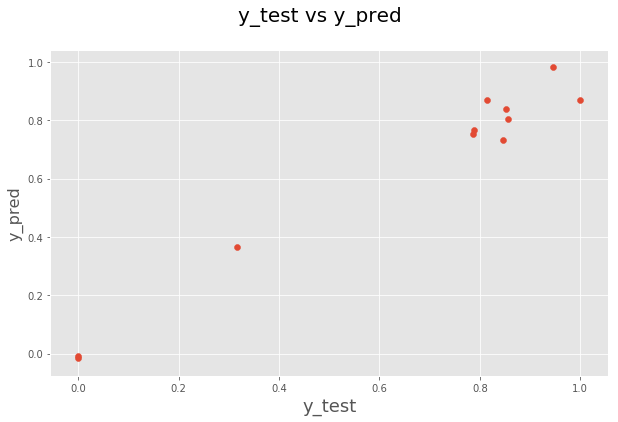

In [223]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

### Elasticity - Camera Accessory - Basic Linear Model

In [224]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr1.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm1, y_train, coefficients_df)

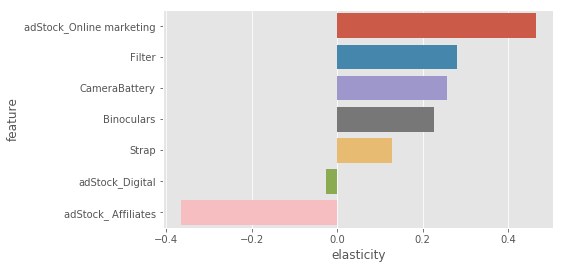

In [225]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### II. Gaming Accessory - Basic Linear Model

In [226]:
# Creating df1 by dropping the features which the company cannot control
df1= final_gaming_data.drop(['selling_price','units','product_mrp','total_transactions'], axis = 1)

In [227]:
#Checking the columns
df1.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'NPS', 'discount', 'total_premiumness',
       'total_holidays', 'is_holiday', 'total_special_sale_days',
       'is_special_sale_day', 'total_pay_days', 'is_pay_day', 'CoolingPad',
       'GameControlMount', 'GamePad', 'GamingAccessoryKit', 'GamingAdapter',
       'GamingChargingStation', 'GamingHeadset', 'GamingKeyboard',
       'GamingMemoryCard', 'GamingMouse', 'GamingMousePad', 'GamingSpeaker',
       'JoystickGamingWheel', 'MotionController', 'TVOutCableAccessory'],
      dtype='object')

In [228]:
#Doing the test train split
np.random.seed(0)
df1_train, df1_test = train_test_split(df1, train_size = 0.8, test_size = 0.2, random_state = 100)

In [229]:
#Scaling the features
scaler=MinMaxScaler()

# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars1=['adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holidays',
       'total_special_sale_days',
       'total_pay_days',
       'CoolingPad', 'GameControlMount', 'GamePad', 'GamingAccessoryKit',
       'GamingAdapter', 'GamingChargingStation', 'GamingHeadset',
       'GamingKeyboard', 'GamingMemoryCard', 'GamingMouse', 'GamingMousePad',
       'GamingSpeaker', 'JoystickGamingWheel', 'MotionController',
       'TVOutCableAccessory']
df1_train[num_vars1] = scaler.fit_transform(df1_train[num_vars1])
df1_test[num_vars1] = scaler.fit_transform(df1_test[num_vars1])

In [230]:
# assiging the values for x_train & y_train
y_train1 = df1_train.pop('gmv')
X_train1 = df1_train

## RFE

In [231]:
# Running RFE with the output number of the variable equal to 20
lm = LinearRegression()
lm.fit(X_train1, y_train1)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train1, y_train1)

In [232]:
## selecting the top 20 rfe features
col = X_train1.columns[rfe.support_]
col

Index(['Year', 'adStock_TV', 'adStock_Digital', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'NPS', 'total_holidays', 'is_holiday',
       'GamePad', 'GamingAccessoryKit', 'GamingHeadset', 'GamingMemoryCard',
       'GamingMouse', 'GamingSpeaker', 'JoystickGamingWheel',
       'MotionController'],
      dtype='object')

In [233]:
## checking the columns excluded by rfe
X_train1.columns[~rfe.support_]

Index(['order_week', 'Month', 'adStock_Sponsorship', 'sla',
       'product_procurement_sla', 'discount', 'total_premiumness',
       'total_special_sale_days', 'is_special_sale_day', 'total_pay_days',
       'is_pay_day', 'CoolingPad', 'GameControlMount', 'GamingAdapter',
       'GamingChargingStation', 'GamingKeyboard', 'GamingMousePad',
       'TVOutCableAccessory'],
      dtype='object')

In [234]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe1 = X_train1[col]

# Add a constant
X_train_lm1 = sm.add_constant(X_train_rfe1)
# Create a first fitted model
lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1 .values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     137.3
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           6.49e-18
Time:                        19:14:50   Log-Likelihood:                 118.75
No. Observations:                  42   AIC:                            -195.5
Df Residuals:                      21   BIC:                            -159.0
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,8.774629e+08
7,adStock_SEM,8.909730e+03
3,adStock_Digital,5.452830e+03
8,adStock_Radio,4.357210e+03
9,adStock_Other,4.244040e+03
5,adStock_Online marketing,1.604660e+03
6,adStock_ Affiliates,1.325360e+03
2,adStock_TV,5.534300e+02
4,adStock_Content Marketing,3.227700e+02
1,Year,5.395000e+01


In [235]:
# removing the feature with highest p-value
X_train1_new= X_train_rfe1.drop(["adStock_Online marketing"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train1_new)
  
lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     151.1
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           5.28e-19
Time:                        19:14:50   Log-Likelihood:                 118.70
No. Observations:                  42   AIC:                            -197.4
Df Residuals:                      22   BIC:                            -162.7
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,8.724485e+08
6,adStock_SEM,8.395770e+03
3,adStock_Digital,4.934500e+03
7,adStock_Radio,4.309530e+03
8,adStock_Other,4.202250e+03
2,adStock_TV,5.425100e+02
4,adStock_Content Marketing,2.850700e+02
5,adStock_ Affiliates,9.552000e+01
1,Year,5.364000e+01
18,JoystickGamingWheel,2.595000e+01


In [236]:
# removing the feature with highest p-values
X_train1_new1= X_train1_new.drop(["JoystickGamingWheel"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train1_new1)

lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     151.9
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.15e-19
Time:                        19:14:50   Log-Likelihood:                 116.76
No. Observations:                  42   AIC:                            -195.5
Df Residuals:                      23   BIC:                            -162.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,3.662845e+08
6,adStock_SEM,7.365640e+03
3,adStock_Digital,4.229900e+03
7,adStock_Radio,4.068200e+03
8,adStock_Other,4.000240e+03
2,adStock_TV,4.886900e+02
4,adStock_Content Marketing,2.790400e+02
5,adStock_ Affiliates,9.431000e+01
1,Year,2.252000e+01
10,total_holidays,2.123000e+01


In [237]:
# dropping feature on the basis of highest p-value
X_train1_new2= X_train1_new1.drop(["total_holidays"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train1_new2)

lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     136.8
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           9.66e-20
Time:                        19:14:50   Log-Likelihood:                 112.52
No. Observations:                  42   AIC:                            -189.0
Df Residuals:                      24   BIC:                            -157.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,2.353356e+08
6,adStock_SEM,6.026470e+03
3,adStock_Digital,3.483790e+03
7,adStock_Radio,3.301400e+03
8,adStock_Other,3.260580e+03
2,adStock_TV,3.864500e+02
4,adStock_Content Marketing,2.450300e+02
5,adStock_ Affiliates,8.486000e+01
9,NPS,1.505000e+01
1,Year,1.447000e+01


In [238]:
# removing feature on the basis of highest vif value  as all the p-values are in acceptable range
X_train1_new3= X_train1_new2.drop(["is_holiday"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train1_new3)
    # Create a first fitted model
lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     140.0
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.00e-20
Time:                        19:14:50   Log-Likelihood:                 110.90
No. Observations:                  42   AIC:                            -187.8
Df Residuals:                      25   BIC:                            -158.3
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,2.312249e+08
6,adStock_SEM,5.745570e+03
3,adStock_Digital,3.319270e+03
7,adStock_Radio,3.142070e+03
8,adStock_Other,3.097410e+03
2,adStock_TV,3.696500e+02
4,adStock_Content Marketing,2.397300e+02
5,adStock_ Affiliates,8.158000e+01
1,Year,1.422000e+01
9,NPS,1.421000e+01


In [239]:
# removing feature on the basis of highest p-value
X_train1_new4= X_train1_new3.drop(["Year"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train1_new4)
    
lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     143.5
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           4.30e-21
Time:                        19:14:50   Log-Likelihood:                 109.25
No. Observations:                  42   AIC:                            -186.5
Df Residuals:                      26   BIC:                            -158.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [240]:
# removing feature on the basis of highest p-value
X_train1_new5= X_train1_new4.drop(["adStock_Content Marketing"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train1_new5)
   
lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     153.0
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           5.82e-22
Time:                        19:14:50   Log-Likelihood:                 108.37
No. Observations:                  42   AIC:                            -186.7
Df Residuals:                      27   BIC:                            -160.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0163    

,Features,VIF
4,adStock_SEM,1144.51
2,adStock_Digital,948.01
5,adStock_Radio,905.64
6,adStock_Other,881.35
1,adStock_TV,98.08
0,const,64.06
3,adStock_ Affiliates,43.02
7,NPS,11.15
10,GamingHeadset,6.60
9,GamingAccessoryKit,5.02


In [241]:
# removing feature on the basis of highest p-value
X_train1_new6= X_train1_new5.drop(["NPS"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train1_new6)
    
lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     159.7
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.10e-22
Time:                        19:14:50   Log-Likelihood:                 106.96
No. Observations:                  42   AIC:                            -185.9
Df Residuals:                      28   BIC:                            -161.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0051    

,Features,VIF
4,adStock_SEM,450.40
5,adStock_Radio,439.70
6,adStock_Other,433.25
2,adStock_Digital,389.38
1,adStock_TV,54.71
0,const,44.38
3,adStock_ Affiliates,29.25
9,GamingHeadset,6.37
8,GamingAccessoryKit,4.99
10,GamingMemoryCard,4.34


In [242]:
# removing feature on the basis of highest p-value
X_train1_new7= X_train1_new6.drop(["adStock_Digital"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train1_new7)
    
lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     173.9
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.22e-23
Time:                        19:14:50   Log-Likelihood:                 106.34
No. Observations:                  42   AIC:                            -186.7
Df Residuals:                      29   BIC:                            -164.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0141    

,Features,VIF
4,adStock_Radio,144.68
5,adStock_Other,137.54
1,adStock_TV,29.14
2,adStock_ Affiliates,28.21
0,const,10.25
8,GamingHeadset,6.26
7,GamingAccessoryKit,4.92
10,GamingMouse,3.84
6,GamePad,3.64
11,GamingSpeaker,2.92


In [243]:
# removing feature on the basis of highest p-value
X_train1_new8= X_train1_new7.drop(["adStock_Other"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train1_new8)
    
lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     193.1
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.07e-24
Time:                        19:14:51   Log-Likelihood:                 106.00
No. Observations:                  42   AIC:                            -188.0
Df Residuals:                      30   BIC:                            -167.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0135    

,Features,VIF
0,const,10.17
2,adStock_ Affiliates,7.18
6,GamingAccessoryKit,4.76
1,adStock_TV,4.16
7,GamingHeadset,3.78
5,GamePad,3.64
9,GamingMouse,3.30
4,adStock_Radio,2.62
11,MotionController,2.52
8,GamingMemoryCard,2.27


In [244]:
# removing feature on the basis of highest p-value
X_train1_new9= X_train1_new8.drop(["adStock_SEM"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train1_new9)
   
lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     212.2
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.17e-25
Time:                        19:14:51   Log-Likelihood:                 105.31
No. Observations:                  42   AIC:                            -188.6
Df Residuals:                      31   BIC:                            -169.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0142    

,Features,VIF
0,const,10.13
2,adStock_ Affiliates,5.89
5,GamingAccessoryKit,4.76
1,adStock_TV,4.13
4,GamePad,3.63
6,GamingHeadset,3.18
10,MotionController,2.50
3,adStock_Radio,2.48
8,GamingMouse,2.33
7,GamingMemoryCard,2.26


In [245]:
# removing feature on the basis of highest p-value
X_train1_new10= X_train1_new9.drop(["GamingMemoryCard"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train1_new10)
    
lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     220.2
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           3.48e-26
Time:                        19:14:51   Log-Likelihood:                 103.24
No. Observations:                  42   AIC:                            -186.5
Df Residuals:                      32   BIC:                            -169.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0167    

,Features,VIF
0,const,9.97
2,adStock_ Affiliates,5.75
5,GamingAccessoryKit,4.67
1,adStock_TV,4.02
4,GamePad,3.61
6,GamingHeadset,3.17
7,GamingMouse,2.33
9,MotionController,2.23
8,GamingSpeaker,1.85
3,adStock_Radio,1.81


In [246]:
# removing feature on the basis of highest p-value
X_train1_new11= X_train1_new10.drop(["adStock_Radio"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train1_new11)

lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     182.8
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           4.66e-25
Time:                        19:14:51   Log-Likelihood:                 96.334
No. Observations:                  42   AIC:                            -174.7
Df Residuals:                      33   BIC:                            -159.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0185    

,Features,VIF
0,const,9.95
2,adStock_ Affiliates,5.02
4,GamingAccessoryKit,4.22
1,adStock_TV,3.93
3,GamePad,3.39
5,GamingHeadset,3.11
6,GamingMouse,2.29
8,MotionController,2.17
7,GamingSpeaker,1.72


In [247]:
# removing feature on the basis of highest p-value
X_train1_new12= X_train1_new11.drop(["adStock_ Affiliates"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train1_new12)
    
lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     214.5
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           3.21e-26
Time:                        19:14:51   Log-Likelihood:                 96.267
No. Observations:                  42   AIC:                            -176.5
Df Residuals:                      34   BIC:                            -162.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0176      0

,Features,VIF
0,const,9.56
3,GamingAccessoryKit,4.08
2,GamePad,3.33
4,GamingHeadset,2.51
5,GamingMouse,2.23
7,MotionController,2.17
1,adStock_TV,1.95
6,GamingSpeaker,1.44


In [248]:
# removing feature on the basis of highest p-value
X_train1_new13= X_train1_new12.drop(["MotionController"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train1_new13)
    
lr= sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     247.4
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           3.80e-27
Time:                        19:14:51   Log-Likelihood:                 95.437
No. Observations:                  42   AIC:                            -176.9
Df Residuals:                      35   BIC:                            -164.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0201      0

,Features,VIF
0,const,9.29
3,GamingAccessoryKit,3.45
2,GamePad,3.18
4,GamingHeadset,2.51
5,GamingMouse,2.23
1,adStock_TV,1.45
6,GamingSpeaker,1.44


In [249]:
# removing feature on the basis of highest p-value
X_train1_new14= X_train1_new13.drop(["adStock_TV"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train1_new14)
    
lr1= sm.OLS(y_train1, X_train_lm1).fit()

lr1.params
print(lr1.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     299.6
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.86e-28
Time:                        19:14:51   Log-Likelihood:                 95.049
No. Observations:                  42   AIC:                            -178.1
Df Residuals:                      36   BIC:                            -167.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0225      0

,Features,VIF
0,const,8.83
1,GamePad,3.10
2,GamingAccessoryKit,3.03
3,GamingHeadset,2.40
4,GamingMouse,2.22
5,GamingSpeaker,1.35


##### Selecting this as the first model as the VIFs & p-values are in the acceptable range

In [250]:
# Dropping the feature to see if the model is able to explain much variance with one less feature
X_train1_new15= X_train1_new14.drop(["GamingAccessoryKit"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train1_new15)

lr2= sm.OLS(y_train1, X_train_lm2).fit()

lr2.params
print(lr2.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     285.3
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.96e-27
Time:                        19:14:51   Log-Likelihood:                 88.928
No. Observations:                  42   AIC:                            -167.9
Df Residuals:                      37   BIC:                            -159.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0371      0.013      2.767

,Features,VIF
0,const,7.83
3,GamingMouse,2.22
2,GamingHeadset,2.14
1,GamePad,1.82
4,GamingSpeaker,1.35


##### Selecting this as the second model as the VIFs & p-values are in the acceptable range

In [251]:
# Dropping the feature to see if the model is able to explain much variance with one less feature
X_train1_new16= X_train1_new15.drop(["GamingSpeaker"], axis = 1)
 # Add a constant
X_train_lm3 = sm.add_constant(X_train1_new16)
    # Create a first fitted model
lr3= sm.OLS(y_train1, X_train_lm3).fit()

lr3.params
print(lr3.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm3.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm3.values, i) for i in range(X_train_lm3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     308.9
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.01e-26
Time:                        19:14:51   Log-Likelihood:                 84.172
No. Observations:                  42   AIC:                            -160.3
Df Residuals:                      38   BIC:                            -153.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0314      0.015      2.142

,Features,VIF
0,const,7.68
3,GamingMouse,2.06
2,GamingHeadset,1.81
1,GamePad,1.71


##### Selecting this as the third model as the VIFs & p-values are in the acceptable range

In [252]:
#Checking performance of top 3 models finding Adjusted R-squared
x_trains = [X_train_lm1, X_train_lm2, X_train_lm3]
for i in range(0,len(x_trains)):
    scores = cross_val_score(lm, x_trains[i], y_train1 , scoring='r2', cv=5)
    print("lr model",i+1,"r2_score", scores.mean())

lr model 1 r2_score 0.9377335563874419
lr model 2 r2_score 0.9141626387750058
lr model 3 r2_score 0.8897243136453243


In [253]:
#Checking performance of top 4 models finding MSE
x_trains = [X_train_lm1, X_train_lm2, X_train_lm3]
for i in range(0,len(x_trains)):
    scores = cross_val_score(lm, x_trains[i], y_train1 , scoring='neg_mean_squared_error', cv=5)
    print("lr model",i+1,"MSE", -scores.mean())

lr model 1 MSE 0.001865174806754378
lr model 2 MSE 0.0026909844942524246
lr model 3 MSE 0.00379531936237854


##### We select the model 2 as the best model as one less feature can still explain 88% variance of the model

### Model Evaluation

In [254]:
y_test = df1_test.pop('gmv')
X_test = df1_test

In [255]:
X_test.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'sla', 'product_procurement_sla',
       'NPS', 'discount', 'total_premiumness', 'total_holidays', 'is_holiday',
       'total_special_sale_days', 'is_special_sale_day', 'total_pay_days',
       'is_pay_day', 'CoolingPad', 'GameControlMount', 'GamePad',
       'GamingAccessoryKit', 'GamingAdapter', 'GamingChargingStation',
       'GamingHeadset', 'GamingKeyboard', 'GamingMemoryCard', 'GamingMouse',
       'GamingMousePad', 'GamingSpeaker', 'JoystickGamingWheel',
       'MotionController', 'TVOutCableAccessory'],
      dtype='object')

In [256]:
X_test.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,...,GamingChargingStation,GamingHeadset,GamingKeyboard,GamingMemoryCard,GamingMouse,GamingMousePad,GamingSpeaker,JoystickGamingWheel,MotionController,TVOutCableAccessory
25,52,12,2015,0.623447,0.505849,1.000000,0.865790,0.772951,0.797967,0.679923,...,1.0,0.856222,0.618056,1.000000,0.605735,0.720,0.236364,0.156627,0.823529,0.653631
48,75,6,2016,0.192129,0.056635,0.569889,0.429084,0.634075,0.643276,0.241883,...,0.0,0.512686,0.861111,0.108020,0.513142,0.464,1.000000,1.000000,0.352941,0.893855
52,79,6,2016,0.189369,0.111151,0.438248,0.050530,0.277200,0.319957,0.029384,...,0.0,0.220701,0.479167,0.013093,0.158303,0.128,0.145455,0.518072,0.647059,0.340782
37,64,3,2016,1.000000,0.290729,0.691260,0.347230,0.653390,0.742328,0.164123,...,0.0,0.361257,1.000000,0.076923,0.328554,0.448,0.145455,0.192771,0.529412,1.000000
6,33,8,2015,0.000000,0.200688,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000


In [257]:
X_test = X_test[X_train_lm1.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test

,const,GamePad,GamingAccessoryKit,GamingHeadset,GamingMouse,GamingSpeaker
25,1.0,1.000000,0.931193,0.856222,0.605735,0.236364
48,1.0,0.944306,1.000000,0.512686,0.513142,1.000000
52,1.0,0.348296,0.472477,0.220701,0.158303,0.145455
37,1.0,0.820449,0.972477,0.361257,0.328554,0.145455
6,1.0,0.000831,0.000000,0.000000,0.000000,0.000000
18,1.0,0.972569,0.977064,0.415224,1.000000,0.054545
20,1.0,0.600166,0.848624,0.326621,0.236559,0.018182
46,1.0,0.781380,0.912844,0.801853,0.367981,0.581818
5,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
31,1.0,0.719867,0.619266,0.643576,0.429510,0.381818


In [258]:
# Making predictions using the final model
y_pred = lr1.predict(X_test)

Text(0, 0.5, 'y_pred')

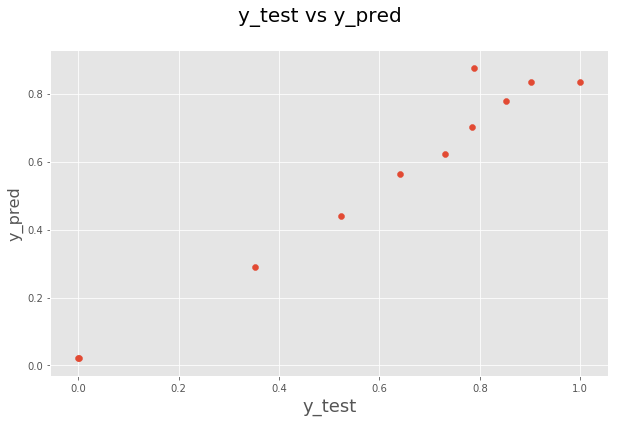

In [259]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

### Elasticity - Gaming Accessory - Basic Linear Model

In [260]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr2.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm1, y_train1, coefficients_df)

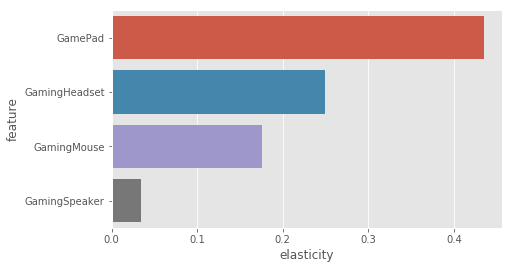

In [261]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### III. Home Audio - Basic Linear Model

In [262]:
# Dropping the unnecessary features which the company cannot control from the Home Audio data frame with KPIs
df2= final_home_audio_data.drop(['selling_price','units','product_mrp','total_transactions'], axis = 1)
df2.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_premiumness',
       'total_holidays', 'is_holiday', 'total_special_sale_days',
       'is_special_sale_day', 'total_pay_days', 'is_pay_day', 'BoomBox',
       'DJController', 'Dock', 'DockingStation', 'FMRadio', 'HiFiSystem',
       'HomeAudioSpeaker', 'SlingBox', 'SoundMixer', 'VoiceRecorder'],
      dtype='object')

In [263]:
#Doing the test-train split
np.random.seed(0)
df2_train, df2_test = train_test_split(df2, train_size = 0.8, test_size = 0.2, random_state = 100)

In [264]:
scaler=MinMaxScaler()

# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars2=['adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holidays',
       'total_special_sale_days',
       'total_pay_days', 'BoomBox',
       'DJController', 'Dock', 'DockingStation', 'FMRadio', 'HiFiSystem',
       'HomeAudioSpeaker', 'SlingBox', 'SoundMixer', 'VoiceRecorder']
df2_train[num_vars2] = scaler.fit_transform(df2_train[num_vars2])
df2_test[num_vars2] = scaler.fit_transform(df2_test[num_vars2])

In [265]:
# Splitting into X_train & y_train
y_train2 = df2_train.pop('gmv')
X_train2 = df2_train

#### RFE

In [266]:
# Running RFE with the output number of the variable equal to 20
lm = LinearRegression()
lm.fit(X_train2, y_train2)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train2, y_train2)

In [267]:
# selecting the top 20 features given by rfe
col = X_train2.columns[rfe.support_]
col

Index(['Year', 'adStock_TV', 'adStock_Digital', 'adStock_Sponsorship',
       'adStock_Content Marketing', 'adStock_Online marketing',
       'adStock_ Affiliates', 'adStock_SEM', 'adStock_Radio', 'adStock_Other',
       'product_procurement_sla', 'discount', 'NPS', 'BoomBox', 'DJController',
       'FMRadio', 'HiFiSystem', 'HomeAudioSpeaker', 'SoundMixer',
       'VoiceRecorder'],
      dtype='object')

In [268]:
# checking the features not selected in top 20
X_train2.columns[~rfe.support_]

Index(['order_week', 'Month', 'sla', 'total_premiumness', 'total_holidays',
       'is_holiday', 'total_special_sale_days', 'is_special_sale_day',
       'total_pay_days', 'is_pay_day', 'Dock', 'DockingStation', 'SlingBox'],
      dtype='object')

In [269]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe2 = X_train2[col]

# Add a constant
X_train_lm2 = sm.add_constant(X_train_rfe2)
# Create a first fitted model
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1187.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.54e-25
Time:                        19:14:56   Log-Likelihood:                 163.51
No. Observations:                  40   AIC:                            -285.0
Df Residuals:                      19   BIC:                            -249.6
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,5.152366e+08
8,adStock_SEM,6.435800e+03
3,adStock_Digital,4.596150e+03
10,adStock_Other,3.343800e+03
9,adStock_Radio,3.330620e+03
7,adStock_ Affiliates,3.048150e+03
6,adStock_Online marketing,2.554740e+03
5,adStock_Content Marketing,5.735500e+02
2,adStock_TV,4.600800e+02
4,adStock_Sponsorship,3.147700e+02


In [270]:
# removing the feature based on the highest p-value
X_train2_new= X_train_rfe2.drop(["adStock_ Affiliates"], axis = 1)
# Add a constant
X_train_lm2 = sm.add_constant(X_train2_new)
   
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1294.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           8.04e-27
Time:                        19:14:56   Log-Likelihood:                 163.19
No. Observations:                  40   AIC:                            -286.4
Df Residuals:                      20   BIC:                            -252.6
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,4.639621e+08
7,adStock_SEM,6.435050e+03
3,adStock_Digital,4.481370e+03
8,adStock_Radio,3.325900e+03
9,adStock_Other,3.259240e+03
5,adStock_Content Marketing,4.094100e+02
2,adStock_TV,2.871000e+02
6,adStock_Online marketing,1.320000e+02
4,adStock_Sponsorship,7.846000e+01
12,NPS,3.465000e+01


In [271]:
# removing the feature based on the highest p-value
X_train2_new1= X_train2_new.drop(["HiFiSystem"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train2_new1)
    
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1371.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           3.32e-28
Time:                        19:14:56   Log-Likelihood:                 162.29
No. Observations:                  40   AIC:                            -286.6
Df Residuals:                      21   BIC:                            -254.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,4.618482e+08
7,adStock_SEM,6.429010e+03
3,adStock_Digital,4.472120e+03
8,adStock_Radio,3.322460e+03
9,adStock_Other,3.257320e+03
5,adStock_Content Marketing,4.041900e+02
2,adStock_TV,2.870900e+02
6,adStock_Online marketing,1.290400e+02
4,adStock_Sponsorship,7.518000e+01
12,NPS,3.380000e+01


In [272]:
# removing the feature on the basis of highest p-value
X_train2_new2= X_train2_new1.drop(["SoundMixer"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train2_new2)
   
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1440.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.50e-29
Time:                        19:14:56   Log-Likelihood:                 161.20
No. Observations:                  40   AIC:                            -286.4
Df Residuals:                      22   BIC:                            -256.0
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,4.187530e+08
7,adStock_SEM,6.343390e+03
3,adStock_Digital,4.442900e+03
8,adStock_Radio,3.302670e+03
9,adStock_Other,3.239950e+03
5,adStock_Content Marketing,3.961000e+02
2,adStock_TV,2.814400e+02
6,adStock_Online marketing,1.279400e+02
4,adStock_Sponsorship,7.513000e+01
12,NPS,3.029000e+01


In [273]:
# removing the feature based on highest p-value
X_train2_new3= X_train2_new2.drop(["NPS"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train2_new3)
    # Create a first fitted model
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1543.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           5.52e-31
Time:                        19:14:56   Log-Likelihood:                 160.49
No. Observations:                  40   AIC:                            -287.0
Df Residuals:                      23   BIC:                            -258.3
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,3.820926e+08
7,adStock_SEM,3.079370e+03
3,adStock_Digital,2.339970e+03
8,adStock_Radio,1.321580e+03
9,adStock_Other,1.233710e+03
5,adStock_Content Marketing,3.478200e+02
2,adStock_TV,1.196400e+02
6,adStock_Online marketing,7.773000e+01
4,adStock_Sponsorship,7.437000e+01
1,Year,2.349000e+01


In [274]:
# removing the feature on the basis of highest p-value
X_train2_new4= X_train2_new3.drop(["product_procurement_sla"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train2_new4)
    
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1554.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           4.30e-32
Time:                        19:14:56   Log-Likelihood:                 158.49
No. Observations:                  40   AIC:                            -285.0
Df Residuals:                      24   BIC:                            -258.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,3.820525e+08
7,adStock_SEM,3.075660e+03
3,adStock_Digital,2.335470e+03
8,adStock_Radio,1.310120e+03
9,adStock_Other,1.212610e+03
5,adStock_Content Marketing,3.099200e+02
2,adStock_TV,1.142400e+02
4,adStock_Sponsorship,6.974000e+01
6,adStock_Online marketing,6.330000e+01
1,Year,2.349000e+01


In [275]:
# removing the features in the basis of highest p-values
X_train2_new5= X_train2_new4.drop(["adStock_Sponsorship"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train2_new5)
  
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1607.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.60e-33
Time:                        19:14:56   Log-Likelihood:                 156.97
No. Observations:                  40   AIC:                            -283.9
Df Residuals:                      25   BIC:                            -258.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,2.183017e+08
6,adStock_SEM,1.823730e+03
8,adStock_Other,1.072630e+03
7,adStock_Radio,1.019670e+03
3,adStock_Digital,8.534600e+02
4,adStock_Content Marketing,1.774600e+02
2,adStock_TV,1.138800e+02
5,adStock_Online marketing,2.799000e+01
1,Year,1.341000e+01
12,FMRadio,1.095000e+01


In [276]:
# removing column on the bsis of highest p-value
X_train2_new6= X_train2_new5.drop(["Year"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train2_new6)
   
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1752.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           8.50e-35
Time:                        19:14:56   Log-Likelihood:                 156.42
No. Observations:                  40   AIC:                            -284.8
Df Residuals:                      26   BIC:                            -261.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
5,adStock_SEM,896.83
7,adStock_Other,640.00
6,adStock_Radio,581.72
2,adStock_Digital,383.29
3,adStock_Content Marketing,137.31
1,adStock_TV,70.09
0,const,42.36
4,adStock_Online marketing,26.67
11,FMRadio,6.01
12,HomeAudioSpeaker,5.96


In [277]:
# dropping feature on the basis of highest vif values as all the p-values are in acceptable range
X_train2_new7= X_train2_new6.drop(["FMRadio"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train2_new7)
    
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1736.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.03e-35
Time:                        19:14:56   Log-Likelihood:                 153.88
No. Observations:                  40   AIC:                            -281.8
Df Residuals:                      27   BIC:                            -259.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
5,adStock_SEM,822.73
7,adStock_Other,571.59
6,adStock_Radio,519.49
2,adStock_Digital,366.49
3,adStock_Content Marketing,124.48
1,adStock_TV,64.31
0,const,39.14
4,adStock_Online marketing,23.71
11,HomeAudioSpeaker,4.93
9,BoomBox,3.41


In [278]:
# removinf feature on the basis of highest p-value
X_train2_new8= X_train2_new7.drop(["discount"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train2_new8)
   
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1762.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.02e-36
Time:                        19:14:56   Log-Likelihood:                 151.72
No. Observations:                  40   AIC:                            -279.4
Df Residuals:                      28   BIC:                            -259.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
5,adStock_SEM,796.79
7,adStock_Other,554.19
6,adStock_Radio,507.56
2,adStock_Digital,366.45
3,adStock_Content Marketing,107.44
1,adStock_TV,61.48
0,const,36.57
4,adStock_Online marketing,23.05
8,BoomBox,2.88
10,HomeAudioSpeaker,2.69


In [279]:
# removing features on the basis of highest p-value
X_train2_new9= X_train2_new8.drop(["DJController"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train2_new9)
    
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1791.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.15e-37
Time:                        19:14:56   Log-Likelihood:                 149.44
No. Observations:                  40   AIC:                            -276.9
Df Residuals:                      29   BIC:                            -258.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
5,adStock_SEM,786.00
7,adStock_Other,550.50
6,adStock_Radio,504.94
2,adStock_Digital,361.35
3,adStock_Content Marketing,106.80
1,adStock_TV,60.80
0,const,35.60
4,adStock_Online marketing,22.96
8,BoomBox,2.87
9,HomeAudioSpeaker,2.69


In [280]:
# removing feature on the basis of highest p-value
X_train2_new10= X_train2_new9.drop(["adStock_Digital"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train2_new10)
   
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1644.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           7.07e-38
Time:                        19:14:56   Log-Likelihood:                 144.95
No. Observations:                  40   AIC:                            -269.9
Df Residuals:                      30   BIC:                            -253.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
6,adStock_Other,112.53
5,adStock_Radio,95.01
4,adStock_SEM,76.92
2,adStock_Content Marketing,74.09
1,adStock_TV,18.77
3,adStock_Online marketing,18.04
0,const,17.14
7,BoomBox,2.84
8,HomeAudioSpeaker,2.64
9,VoiceRecorder,1.43


In [281]:
# removing feature on the basis of highest p-value
X_train2_new11= X_train2_new10.drop(["adStock_Radio"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train2_new11)
    
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1596.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.53e-38
Time:                        19:14:56   Log-Likelihood:                 141.35
No. Observations:                  40   AIC:                            -264.7
Df Residuals:                      31   BIC:                            -249.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
2,adStock_Content Marketing,55.64
4,adStock_SEM,55.40
0,const,16.07
3,adStock_Online marketing,4.41
5,adStock_Other,3.94
1,adStock_TV,2.91
6,BoomBox,2.62
7,HomeAudioSpeaker,2.25
8,VoiceRecorder,1.34


In [282]:
# removing feature on the basis of highest p-value
X_train2_new12= X_train2_new11.drop(["adStock_Other"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train2_new12)
    
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1818.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           9.72e-40
Time:                        19:14:56   Log-Likelihood:                 140.66
No. Observations:                  40   AIC:                            -265.3
Df Residuals:                      32   BIC:                            -251.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
2,adStock_Content Marketing,21.73
4,adStock_SEM,19.40
0,const,14.94
3,adStock_Online marketing,3.78
5,BoomBox,2.38
1,adStock_TV,2.25
6,HomeAudioSpeaker,2.13
7,VoiceRecorder,1.33


In [283]:
# removing feature on the basis of highest p-value
X_train2_new13= X_train2_new12.drop(["adStock_TV"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train2_new13)

lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2153.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.57e-41
Time:                        19:14:56   Log-Likelihood:                 140.34
No. Observations:                  40   AIC:                            -266.7
Df Residuals:                      33   BIC:                            -254.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
1,adStock_Content Marketing,20.90
3,adStock_SEM,18.04
0,const,14.80
2,adStock_Online marketing,2.73
4,BoomBox,2.36
5,HomeAudioSpeaker,2.13
6,VoiceRecorder,1.33


In [284]:
# removing feature on the basis of highest p-value
X_train2_new14= X_train2_new13.drop(["adStock_Online marketing"], axis = 1)
 # Add a constant
X_train_lm2_1 = sm.add_constant(X_train2_new14)

lr1 = sm.OLS(y_train2, X_train_lm2_1).fit()

lr1.params
print(lr1.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2_1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2_1.values, i) for i in range(X_train_lm2_1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2553.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           9.56e-43
Time:                        19:14:56   Log-Likelihood:                 139.51
No. Observations:                  40   AIC:                            -267.0
Df Residuals:                      34   BIC:                            -256.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
2,adStock_SEM,16.63
1,adStock_Content Marketing,16.12
0,const,7.99
4,HomeAudioSpeaker,1.90
3,BoomBox,1.80
5,VoiceRecorder,1.31


#### Selecting this as our first model based on the vif and p -values acceptable ranges

In [285]:
## removing features on the basis of features which give lesser drop in adj. r2 values 
X_train2_new15= X_train2_new14.drop(["adStock_Content Marketing"], axis = 1)
 # Add a constant
X_train_lm2_2 = sm.add_constant(X_train2_new15)

lr = sm.OLS(y_train2, X_train_lm2_2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2_2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2_2.values, i) for i in range(X_train_lm2_2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2931.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.14e-43
Time:                        19:14:56   Log-Likelihood:                 137.23
No. Observations:                  40   AIC:                            -264.5
Df Residuals:                      35   BIC:                            -256.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0200      0.004  

,Features,VIF
0,const,7.99
3,HomeAudioSpeaker,1.75
2,BoomBox,1.69
1,adStock_SEM,1.56
4,VoiceRecorder,1.24


In [286]:
# removing features to get lesser drop in adj r2 square value
X_train2_new16= X_train2_new15.drop(["adStock_SEM"], axis = 1)
 # Add a constant
X_train_lm2_3 = sm.add_constant(X_train2_new16)

lr3 = sm.OLS(y_train2, X_train_lm2_3).fit()

lr3.params
print(lr3.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2_3.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2_3.values, i) for i in range(X_train_lm2_3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3882.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           3.07e-45
Time:                        19:14:56   Log-Likelihood:                 136.54
No. Observations:                  40   AIC:                            -265.1
Df Residuals:                      36   BIC:                            -258.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0202      0.004  

,Features,VIF
0,const,7.98
1,BoomBox,1.60
2,HomeAudioSpeaker,1.51
3,VoiceRecorder,1.17


In [287]:
#Checking performance of top 4 models finding Adjusted R-squared
x_trains = [X_train_lm2_1, X_train_lm2_2,X_train_lm2_3]
for i in range(0,len(x_trains)):
    scores = cross_val_score(lm, x_trains[i], y_train2 , scoring='r2', cv=5)
    print("lr model",i+1,"r2_score", scores.mean())

lr model 1 r2_score 0.9778904281959498
lr model 2 r2_score 0.9749546464440317
lr model 3 r2_score 0.9738550597877802


In [288]:
#Checking MSE of top 4 models
x_trains = [X_train_lm2_1, X_train_lm2_2,X_train_lm2_3]
for i in range(0,len(x_trains)):
    scores = cross_val_score(lm, x_trains[i], y_train2 , scoring='neg_mean_squared_error', cv=5)
    print("lr model",i+1,"MSE", -scores.mean())

lr model 1 MSE 0.00014911740498965432
lr model 2 MSE 0.00011449711514170059
lr model 3 MSE 0.00011138949581708738


#### Based upon the lowest number of features & the best model performance, we select model 3 as the best basic linear model for Home Audio Category

### Residual analysis

In [289]:
y_train_price = lr3.predict(X_train_lm2_3)

Text(0.5, 0, 'Errors')

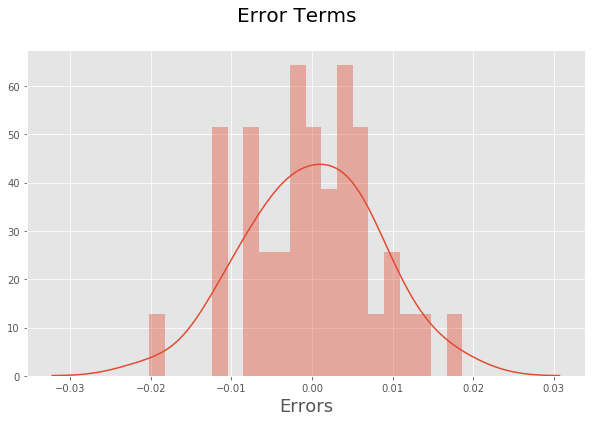

In [290]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train2 - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Model Evaluation

In [291]:
y_test = df2_test.pop('gmv')
X_test = df2_test

In [292]:
X_test.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'sla', 'product_procurement_sla',
       'discount', 'NPS', 'total_premiumness', 'total_holidays', 'is_holiday',
       'total_special_sale_days', 'is_special_sale_day', 'total_pay_days',
       'is_pay_day', 'BoomBox', 'DJController', 'Dock', 'DockingStation',
       'FMRadio', 'HiFiSystem', 'HomeAudioSpeaker', 'SlingBox', 'SoundMixer',
       'VoiceRecorder'],
      dtype='object')

In [293]:
X_test.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,...,BoomBox,DJController,Dock,DockingStation,FMRadio,HiFiSystem,HomeAudioSpeaker,SlingBox,SoundMixer,VoiceRecorder
6,36,9,2015,0.244605,0.290300,0.663463,0.328685,0.275383,0.283422,0.141059,...,1.000000,0.0,1.000000,0.000000,0.833648,0.666667,0.416162,0.0,0.0,0.375000
36,66,4,2016,0.990932,0.356995,0.729638,0.222751,0.668837,0.773385,0.229379,...,0.447761,0.0,0.437500,0.526316,0.720227,0.454545,0.446061,0.0,0.0,0.894231
37,67,4,2016,0.912173,0.207337,0.674933,0.128442,0.684842,0.797143,0.230402,...,0.388060,0.0,0.666667,0.684211,0.725898,0.878788,0.379394,1.0,0.0,0.894231
28,58,2,2016,0.547775,0.324276,0.172513,0.988332,0.911965,1.000000,0.312876,...,0.492537,0.0,0.645833,0.210526,0.897921,0.515152,1.000000,0.0,0.0,0.730769
43,73,5,2016,0.240274,0.000000,0.813115,1.000000,1.000000,0.980171,0.745088,...,0.358209,0.0,0.020833,0.842105,0.551985,0.333333,0.381414,0.0,0.5,1.000000


In [294]:
X_test = X_test[X_train_lm2_3.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test

,const,BoomBox,HomeAudioSpeaker,VoiceRecorder
6,1.0,1.000000,0.416162,0.375000
36,1.0,0.447761,0.446061,0.894231
37,1.0,0.388060,0.379394,0.894231
28,1.0,0.492537,1.000000,0.730769
43,1.0,0.358209,0.381414,1.000000
49,1.0,0.462687,0.194343,0.240385
5,1.0,0.000000,0.000000,0.000000
33,1.0,0.582090,0.871515,0.798077
20,1.0,0.402985,0.960000,0.394231
42,1.0,0.402985,0.426263,0.932692


In [295]:
# Making predictions using the final model
y_pred = lr3.predict(X_test)

Text(0, 0.5, 'y_pred')

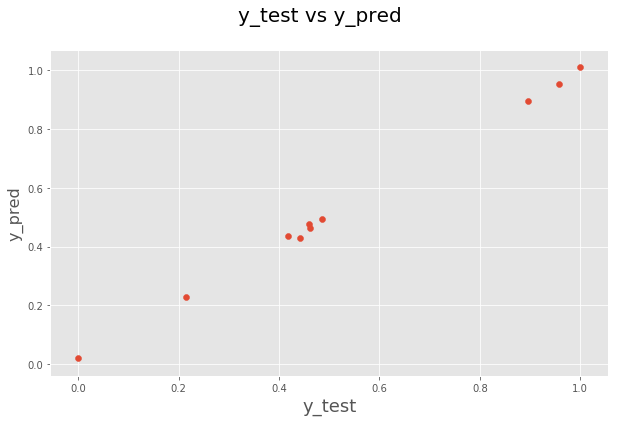

In [296]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

### Elasticity - Home Audio - Basic Linear model

In [297]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr3.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm2_3, y_train2, coefficients_df)

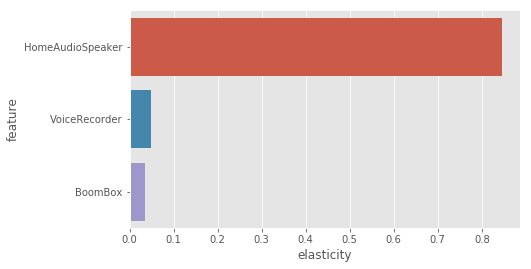

In [298]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### Building the Multiplicative models

#### I. Camera Accessory - Multiplicative model

In [299]:
# taking the camera accessory dataset
final_camera_data.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,...,CameraTripod,ExtensionTube,Filter,Flash,FlashShoeAdapter,Lens,ReflectorUmbrella,Softbox,Strap,Telescope
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,...,13.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,...,433.0,0.0,226.0,17.0,0.0,366.0,0.0,0.0,13.0,16.0
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,...,491.0,0.0,188.0,23.0,0.0,382.0,0.0,0.0,24.0,22.0
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,...,457.0,0.0,194.0,18.0,0.0,423.0,0.0,0.0,23.0,30.0
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,...,363.0,0.0,112.0,26.0,0.0,233.0,0.0,0.0,23.0,13.0


**Begin by replacing '0' with '0.0000001' to avaoid NAN values when we take log of values in dataset**

In [300]:
final_camera_data.replace(0.0, 0.000001).head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,...,CameraTripod,ExtensionTube,Filter,Flash,FlashShoeAdapter,Lens,ReflectorUmbrella,Softbox,Strap,Telescope
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,...,13.0,0.000001,0.000001,0.000001,0.000001,2.0,0.000001,0.000001,0.000001,0.000001
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,...,433.0,0.000001,226.000000,17.000000,0.000001,366.0,0.000001,0.000001,13.000000,16.000000
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,...,491.0,0.000001,188.000000,23.000000,0.000001,382.0,0.000001,0.000001,24.000000,22.000000
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,...,457.0,0.000001,194.000000,18.000000,0.000001,423.0,0.000001,0.000001,23.000000,30.000000
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,...,363.0,0.000001,112.000000,26.000000,0.000001,233.0,0.000001,0.000001,23.000000,13.000000


**Taking log and dropping the uncotrollable features for the company**

In [301]:
df = np.log(final_camera_data.replace(0.0, 0.000001).drop(['selling_price','units','product_mrp','total_transactions'], axis = 1))

In [302]:
#Test-train split
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)

In [303]:
# scaling 
scaler = MinMaxScaler()

In [304]:
# checking the features in the dataset
df.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_premiumness',
       'total_holidays', 'is_holiday', 'total_special_sale_days',
       'is_special_sale_day', 'total_pay_days', 'is_pay_day', 'Binoculars',
       'CameraAccessory', 'CameraBag', 'CameraBattery', 'CameraBatteryCharger',
       'CameraBatteryGrip', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing',
       'CameraMicrophone', 'CameraMount', 'CameraRemoteControl',
       'CameraTripod', 'ExtensionTube', 'Filter', 'Flash', 'FlashShoeAdapter',
       'Lens', 'ReflectorUmbrella', 'Softbox', 'Strap', 'Telescope'],
      dtype='object')

In [305]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars=['adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holidays',
       'total_special_sale_days',
       'total_pay_days',
       'Binoculars', 'CameraAccessory', 'CameraBag', 'CameraBattery',
       'CameraBatteryCharger', 'CameraBatteryGrip', 'CameraEyeCup',
       'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone', 'CameraMount',
       'CameraRemoteControl', 'CameraTripod', 'ExtensionTube', 'Filter',
       'Flash', 'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella', 'Softbox',
       'Strap', 'Telescope']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [306]:
# assigning x_traim amd y_train values
y_train = df_train.pop('gmv')
X_train = df_train

In [307]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [308]:
# selecting the top 20 features given by rfe
col = X_train.columns[rfe.support_]
col

Index(['order_week', 'adStock_TV', 'adStock_Digital',
       'adStock_Content Marketing', 'adStock_Online marketing', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'sla', 'discount',
       'total_premiumness', 'Binoculars', 'CameraBag', 'CameraBattery',
       'CameraBatteryCharger', 'CameraBatteryGrip', 'CameraTripod', 'Flash',
       'Lens', 'Telescope'],
      dtype='object')

In [309]:
# neglecting the features other than top 20 features given by rfe
X_train.columns[~rfe.support_]

Index(['Month', 'Year', 'adStock_Sponsorship', 'adStock_ Affiliates',
       'product_procurement_sla', 'NPS', 'total_holidays', 'is_holiday',
       'total_special_sale_days', 'is_special_sale_day', 'total_pay_days',
       'is_pay_day', 'CameraAccessory', 'CameraEyeCup', 'CameraFilmRolls',
       'CameraHousing', 'CameraMicrophone', 'CameraMount',
       'CameraRemoteControl', 'ExtensionTube', 'Filter', 'FlashShoeAdapter',
       'ReflectorUmbrella', 'Softbox', 'Strap'],
      dtype='object')

In [310]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [311]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     4682.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.82e-32
Time:                        19:14:58   Log-Likelihood:                 188.50
No. Observations:                  41   AIC:                            -335.0
Df Residuals:                      20   BIC:                            -299.0
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,10241.62
7,adStock_Radio,3860.97
8,adStock_Other,3686.64
14,CameraBattery,1716.17
13,CameraBag,1705.36
15,CameraBatteryCharger,819.46
11,total_premiumness,674.36
12,Binoculars,664.75
17,CameraTripod,518.87
18,Flash,220.27


In [312]:
# Let's drop feature units with highest p-value 
X_train_new= X_train_rfe.drop(["adStock_Content Marketing"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new)
   
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     5116.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.78e-34
Time:                        19:14:58   Log-Likelihood:                 188.27
No. Observations:                  41   AIC:                            -336.5
Df Residuals:                      21   BIC:                            -302.3
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,8908.34
6,adStock_Radio,2077.60
7,adStock_Other,1978.67
12,CameraBag,1680.98
13,CameraBattery,1606.31
14,CameraBatteryCharger,819.38
11,Binoculars,649.76
10,total_premiumness,620.95
16,CameraTripod,516.64
17,Flash,207.26


In [313]:
# Let's drop featuree with highest p-value
X_train_new1 = X_train_new.drop(["Binoculars"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new1)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     5430.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           5.66e-36
Time:                        19:14:58   Log-Likelihood:                 187.43
No. Observations:                  41   AIC:                            -336.9
Df Residuals:                      22   BIC:                            -304.3
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,8426.62
6,adStock_Radio,1627.13
12,CameraBattery,1604.70
7,adStock_Other,1557.36
11,CameraBag,1149.31
13,CameraBatteryCharger,812.49
10,total_premiumness,600.64
15,CameraTripod,507.53
16,Flash,202.60
17,Lens,187.87


In [314]:
# Let's drop feature  with highest p-value
X_train_new2 = X_train_new1.drop(["adStock_Radio"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new2)
   
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     5506.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.95e-37
Time:                        19:14:58   Log-Likelihood:                 185.63
No. Observations:                  41   AIC:                            -335.3
Df Residuals:                      23   BIC:                            -304.4
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,7362.60
11,CameraBattery,1603.96
10,CameraBag,1125.96
12,CameraBatteryCharger,804.00
9,total_premiumness,599.85
14,CameraTripod,504.47
15,Flash,196.42
16,Lens,185.08
17,Telescope,151.54
4,adStock_Online marketing,109.85


In [315]:
# Let's remove feature with highest p-value
X_train_new3 = X_train_new2.drop(["adStock_Other"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new3)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     5932.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           3.43e-39
Time:                        19:14:58   Log-Likelihood:                 185.04
No. Observations:                  41   AIC:                            -336.1
Df Residuals:                      24   BIC:                            -307.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,6985.99
10,CameraBattery,1594.26
9,CameraBag,1117.30
11,CameraBatteryCharger,797.53
8,total_premiumness,554.66
13,CameraTripod,423.34
14,Flash,196.42
15,Lens,156.65
16,Telescope,151.14
4,adStock_Online marketing,108.68


In [316]:
# drop feature  with higest p-value
X_train_new4 = X_train_new3.drop(["sla"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new4)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     5903.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.63e-40
Time:                        19:14:58   Log-Likelihood:                 182.79
No. Observations:                  41   AIC:                            -333.6
Df Residuals:                      25   BIC:                            -306.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,5119.21
9,CameraBattery,1482.30
8,CameraBag,1021.26
10,CameraBatteryCharger,707.85
12,CameraTripod,411.34
7,total_premiumness,400.45
13,Flash,177.81
14,Lens,145.72
15,Telescope,112.76
4,adStock_Online marketing,108.22


In [317]:
# dropping the feature with highest p-value
X_train_new5 = X_train_new4.drop(["Telescope"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new5)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     5900.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           8.03e-42
Time:                        19:14:58   Log-Likelihood:                 180.56
No. Observations:                  41   AIC:                            -331.1
Df Residuals:                      26   BIC:                            -305.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,5045.53
9,CameraBattery,1270.93
8,CameraBag,907.21
10,CameraBatteryCharger,693.95
12,CameraTripod,409.56
7,total_premiumness,400.03
13,Flash,135.07
14,Lens,134.34
4,adStock_Online marketing,100.37
11,CameraBatteryGrip,69.34


In [318]:
# dropping the feature with highest p-value
X_train_new6 = X_train_new5.drop(["Lens"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new6)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     6227.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.10e-43
Time:                        19:14:58   Log-Likelihood:                 179.37
No. Observations:                  41   AIC:                            -330.7
Df Residuals:                      27   BIC:                            -306.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,4038.91
9,CameraBattery,1165.07
10,CameraBatteryCharger,532.70
8,CameraBag,455.15
12,CameraTripod,398.95
7,total_premiumness,143.21
13,Flash,123.61
4,adStock_Online marketing,96.95
11,CameraBatteryGrip,57.41
2,adStock_TV,39.82


In [319]:
# dropping the feature with highest p-value
X_train_new7= X_train_new6.drop(["CameraBattery"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new7)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     6267.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.14e-44
Time:                        19:14:58   Log-Likelihood:                 177.12
No. Observations:                  41   AIC:                            -328.2
Df Residuals:                      28   BIC:                            -306.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,4014.05
9,CameraBatteryCharger,348.86
11,CameraTripod,334.90
8,CameraBag,315.26
7,total_premiumness,137.58
12,Flash,121.71
4,adStock_Online marketing,82.05
10,CameraBatteryGrip,57.41
2,adStock_TV,36.34
1,order_week,26.40


In [320]:
# dropping the feature with highest p-value
X_train_new8= X_train_new7.drop(["Flash"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new8)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     6518.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           4.35e-46
Time:                        19:14:58   Log-Likelihood:                 175.42
No. Observations:                  41   AIC:                            -326.8
Df Residuals:                      29   BIC:                            -306.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,3372.30
9,CameraBatteryCharger,342.47
11,CameraTripod,320.75
8,CameraBag,296.17
7,total_premiumness,97.03
4,adStock_Online marketing,79.24
10,CameraBatteryGrip,38.83
2,adStock_TV,36.20
1,order_week,23.56
5,adStock_SEM,22.95


In [321]:
# dropping the feature with highest p-value
X_train_new9= X_train_new8.drop(["CameraBatteryGrip"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new9)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     6994.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.18e-47
Time:                        19:14:58   Log-Likelihood:                 174.21
No. Observations:                  41   AIC:                            -326.4
Df Residuals:                      30   BIC:                            -307.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,3252.62
9,CameraBatteryCharger,341.31
10,CameraTripod,300.63
8,CameraBag,269.44
4,adStock_Online marketing,68.63
2,adStock_TV,33.19
1,order_week,23.35
5,adStock_SEM,20.71
7,total_premiumness,16.85
3,adStock_Digital,14.41


In [322]:
# dropping the feature with highest p-value
X_train_new10= X_train_new9.drop(["CameraBag"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new10)
   
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     6598.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.66e-48
Time:                        19:14:59   Log-Likelihood:                 170.19
No. Observations:                  41   AIC:                            -320.4
Df Residuals:                      31   BIC:                            -303.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,3116.34
8,CameraBatteryCharger,255.33
9,CameraTripod,242.56
4,adStock_Online marketing,67.21
2,adStock_TV,28.05
1,order_week,22.35
5,adStock_SEM,20.71
7,total_premiumness,16.77
3,adStock_Digital,14.41
6,discount,5.23


In [323]:
# dropping the feature with highest p-value
X_train_new11= X_train_new10.drop(["adStock_TV"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new11)
   
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     7045.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.12e-49
Time:                        19:14:59   Log-Likelihood:                 168.47
No. Observations:                  41   AIC:                            -318.9
Df Residuals:                      32   BIC:                            -303.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,3101.82
7,CameraBatteryCharger,255.33
8,CameraTripod,242.53
1,order_week,22.02
3,adStock_Online marketing,21.97
6,total_premiumness,16.74
4,adStock_SEM,11.81
2,adStock_Digital,7.74
5,discount,5.23


In [324]:
# dropping the feature with highest p-value
X_train_new12= X_train_new11.drop(["order_week"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new12)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     6066.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.08e-49
Time:                        19:14:59   Log-Likelihood:                 162.04
No. Observations:                  41   AIC:                            -308.1
Df Residuals:                      33   BIC:                            -294.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
6,CameraBatteryCharger,79.64
0,const,53.51
7,CameraTripod,48.69
5,total_premiumness,14.90
3,adStock_SEM,9.47
1,adStock_Digital,7.06
2,adStock_Online marketing,4.36
4,discount,1.43


In [325]:
# # dropping the feature with highest vif
X_train_new13= X_train_new12.drop(["CameraBatteryCharger"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new13)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     6437.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.93e-50
Time:                        19:14:59   Log-Likelihood:                 159.48
No. Observations:                  41   AIC:                            -305.0
Df Residuals:                      34   BIC:                            -293.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,51.14
3,adStock_SEM,8.79
1,adStock_Digital,7.05
5,total_premiumness,6.19
6,CameraTripod,5.01
2,adStock_Online marketing,4.30
4,discount,1.43


In [326]:
# dropping the feature with highest p-value
X_train_new14= X_train_new13.drop(["adStock_Online marketing"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new14)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     6807.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           3.09e-51
Time:                        19:14:59   Log-Likelihood:                 156.30
No. Observations:                  41   AIC:                            -300.6
Df Residuals:                      35   BIC:                            -290.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1185      0.00

,Features,VIF
0,const,49.74
4,total_premiumness,5.59
2,adStock_SEM,5.00
5,CameraTripod,4.98
1,adStock_Digital,4.68
3,discount,1.42


In [327]:
# dropping the feature with highest vif
X_train_new15= X_train_new14.drop(["adStock_Digital"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new15)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     7883.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.02e-52
Time:                        19:14:59   Log-Likelihood:                 154.16
No. Observations:                  41   AIC:                            -298.3
Df Residuals:                      36   BIC:                            -289.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1240      0.00

,Features,VIF
0,const,40.16
3,total_premiumness,4.91
4,CameraTripod,4.71
2,discount,1.21
1,adStock_SEM,1.16


In [328]:
# dropping the feature with highest vif
X_train_new16= X_train_new15.drop(["adStock_SEM"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train_new16)
  
lr1 = sm.OLS(y_train, X_train_lm1).fit()

lr1.params
print(lr1.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1 .values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.042e+04
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           3.49e-54
Time:                        19:14:59   Log-Likelihood:                 153.41
No. Observations:                  41   AIC:                            -298.8
Df Residuals:                      37   BIC:                            -292.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1249      0.00

,Features,VIF
0,const,39.34
2,total_premiumness,4.84
3,CameraTripod,4.68
1,discount,1.21


##### Selecting the above model as the first model as all the p-values & VIFs are in the acceptable range

In [329]:
# dropping the feature with highest p-value
X_train_new17= X_train_new16.drop(["total_premiumness"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train_new17)

lr2 = sm.OLS(y_train, X_train_lm2).fit()

lr2.params
print(lr2.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2 .values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     88.74
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           4.80e-15
Time:                        19:14:59   Log-Likelihood:                 50.818
No. Observations:                  41   AIC:                            -95.64
Df Residuals:                      38   BIC:                            -90.49
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0715      0.071     -1.011   

,Features,VIF
0,const,38.75
1,discount,1.17
2,CameraTripod,1.17


##### Selecting the above model as the second model as all the p-values & VIFs are in the acceptable range

In [330]:
# k-fold Cross Validation - Adjusted R-squared
lm = LinearRegression()
#Checking performance of top 2 models finding Adjusted R-squared
x_trains = [X_train_lm1, X_train_lm2]
for i in range(0,len(x_trains)):
    x_test = x_trains[i]
    scores = cross_val_score(lm, x_test, y_train , scoring='r2', cv=5)
    print("lr model",i+1,"r2_score", scores.mean())

lr model 1 r2_score 0.9757094192634053
lr model 2 r2_score -0.21295527198031983


In [331]:
import numpy as np
from sklearn import metrics

# k-fold Cross Validation - MSE
lm = LinearRegression()
#Checking performance of top 4 models finding Adjusted R-squared
x_trains = [X_train_lm1, X_train_lm2]
for i in range(0,len(x_trains)):
    x_test = x_trains[i]
    scores = cross_val_score(lm, x_test, y_train , scoring='neg_mean_squared_error', cv=5)
    print("lr model",i+1,"MSE", -scores.mean())

lr model 1 MSE 0.0001647293308378221
lr model 2 MSE 0.059486415355590086


#### As we see linear model 1 performs much better than the second one, therefore we choose that as the best among the multiplicative models for Camera Category

### Residual Analysis


In [332]:
y_train_price = lr1.predict(X_train_lm1)

Text(0.5, 0, 'Errors')

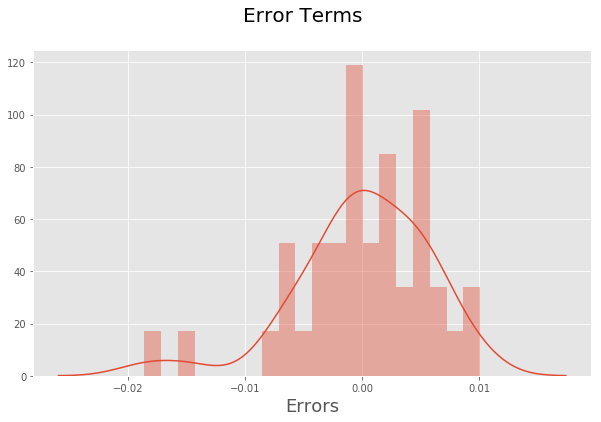

In [333]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Model Evaluation

In [334]:
y_test = df_test.pop('gmv')
X_test = df_test

In [335]:
X_test.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'sla', 'product_procurement_sla',
       'discount', 'NPS', 'total_premiumness', 'total_holidays', 'is_holiday',
       'total_special_sale_days', 'is_special_sale_day', 'total_pay_days',
       'is_pay_day', 'Binoculars', 'CameraAccessory', 'CameraBag',
       'CameraBattery', 'CameraBatteryCharger', 'CameraBatteryGrip',
       'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone',
       'CameraMount', 'CameraRemoteControl', 'CameraTripod', 'ExtensionTube',
       'Filter', 'Flash', 'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella',
       'Softbox', 'Strap', 'Telescope'],
      dtype='object')

In [336]:
X_test.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,...,CameraTripod,ExtensionTube,Filter,Flash,FlashShoeAdapter,Lens,ReflectorUmbrella,Softbox,Strap,Telescope
6,3.496508,2.079442,7.608374,0.000000,0.528047,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
32,4.094345,0.693147,7.608871,0.848092,0.712667,0.562074,0.963253,0.968376,0.993137,0.467760,...,0.995349,0.000000,0.981238,0.982579,0.0,0.976999,0.0,0.000000,0.984941,0.956799
38,4.189655,1.386294,7.608871,0.998315,0.434195,0.858298,0.816250,0.912312,0.942289,0.352485,...,0.949417,0.940597,0.983239,0.978389,0.0,0.974892,0.0,0.952225,0.981384,0.977422
35,4.143135,1.098612,7.608871,1.000000,0.704939,0.855724,0.903255,0.915779,0.940687,0.378158,...,0.964899,1.000000,1.000000,0.980577,0.0,0.981170,1.0,0.000000,0.998661,0.983685
33,4.110874,0.693147,7.608871,0.840296,0.757672,0.575356,0.959803,0.966262,0.990927,0.475426,...,0.993964,0.966883,0.977960,0.994027,0.0,0.970778,0.0,0.952225,0.998661,0.978733


In [337]:
X_test = X_test[X_train_lm1.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test

,const,discount,total_premiumness,CameraTripod
6,1.0,1.000000,0.000000,0.000000
32,1.0,0.073731,8.686092,0.995349
38,1.0,0.166549,8.539150,0.949417
35,1.0,0.175447,8.581482,0.964899
33,1.0,0.258246,8.585786,0.993964
51,1.0,0.161667,7.491088,0.671571
5,1.0,0.171340,0.000000,0.000000
26,1.0,0.154162,8.508354,1.000000
25,1.0,0.000000,8.239857,0.976496
45,1.0,0.297622,8.488382,0.907066


In [338]:
# Making predictions using the final model
y_pred = lr1.predict(X_test)

Text(0, 0.5, 'y_pred')

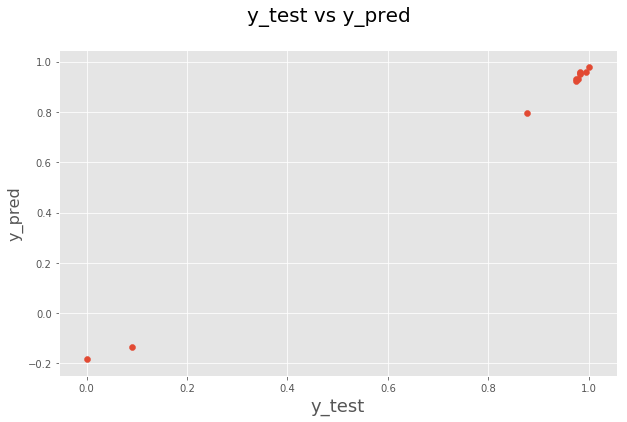

In [339]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

### Elasticity Analysis

In [340]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr1.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm1, y_train, coefficients_df)

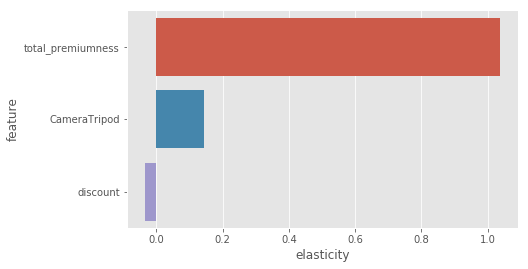

In [341]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### II. Gaming Accessory - Multiplicative model

In [342]:
# replacing '0.0' with '0.0000001' and taking log of the dataset to avaoid the nana values for log 0
df = np.log(final_gaming_data.replace(0.0, 0.000001).drop(['selling_price','units','product_mrp','total_transactions'], axis = 1))

In [343]:
df.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,...,GamingChargingStation,GamingHeadset,GamingKeyboard,GamingMemoryCard,GamingMouse,GamingMousePad,GamingSpeaker,JoystickGamingWheel,MotionController,TVOutCableAccessory
0,3.295837,1.945910,7.608374,-2.921877,-0.456885,0.617112,-8.363510,-1.103164,-1.989137,0.227872,...,-13.815511,0.693147,0.000000,-13.815511,1.386294,0.000000,-13.815511,-13.815511,-13.815511,-13.815511
1,3.332205,1.945910,7.608374,-2.516412,-0.051419,1.022577,-7.958044,-0.697699,-1.583672,0.633337,...,-13.815511,5.176150,6.070738,3.583519,6.878326,4.007333,-13.815511,2.397895,2.772589,4.290459
2,3.367296,1.945910,7.608374,-2.362261,0.102731,1.176728,-7.803894,-0.543549,-1.429521,0.787488,...,-13.815511,5.187386,5.111988,3.295837,5.883322,3.871201,-13.815511,2.079442,2.397895,4.521789
3,3.401197,1.945910,7.608374,-2.293268,0.171724,1.245721,-7.734901,-0.474556,-1.360528,0.856481,...,-13.815511,5.645447,5.159055,3.332205,6.107023,4.204693,-13.815511,2.484907,2.397895,4.532599
4,3.433987,2.079442,7.608374,-2.955022,-0.090807,0.694922,-8.420842,-1.068883,-1.919477,0.591010,...,-13.815511,6.049733,4.356709,2.397895,5.476464,3.663562,0.000000,2.944439,2.079442,4.369448


In [344]:
#Test-train split
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.20, random_state = 100)

In [345]:
# initialising scaler
scaler = MinMaxScaler()

In [346]:
# checking the columns
df.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'NPS', 'discount', 'total_premiumness',
       'total_holidays', 'is_holiday', 'total_special_sale_days',
       'is_special_sale_day', 'total_pay_days', 'is_pay_day', 'CoolingPad',
       'GameControlMount', 'GamePad', 'GamingAccessoryKit', 'GamingAdapter',
       'GamingChargingStation', 'GamingHeadset', 'GamingKeyboard',
       'GamingMemoryCard', 'GamingMouse', 'GamingMousePad', 'GamingSpeaker',
       'JoystickGamingWheel', 'MotionController', 'TVOutCableAccessory'],
      dtype='object')

In [347]:
# Apply scaler() to all the columns except the categorical features
num_vars=['adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holidays',
       'total_special_sale_days',
       'total_pay_days',
       'CoolingPad', 'GameControlMount', 'GamePad', 'GamingAccessoryKit',
       'GamingAdapter', 'GamingChargingStation', 'GamingHeadset',
       'GamingKeyboard', 'GamingMemoryCard', 'GamingMouse', 'GamingMousePad',
       'GamingSpeaker', 'JoystickGamingWheel', 'MotionController',
       'TVOutCableAccessory']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [348]:
# assigning the values for x_train and y_train
y_train = df_train.pop('gmv')
X_train = df_train

In [349]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [350]:
# selecting the top 20 features given by rfe
col = X_train.columns[rfe.support_]
col

Index(['Year', 'adStock_TV', 'adStock_Sponsorship',
       'adStock_Content Marketing', 'adStock_Online marketing',
       'adStock_ Affiliates', 'adStock_Radio', 'NPS', 'discount', 'GamePad',
       'GamingAccessoryKit', 'GamingAdapter', 'GamingHeadset',
       'GamingKeyboard', 'GamingMemoryCard', 'GamingMouse', 'GamingMousePad',
       'JoystickGamingWheel', 'MotionController', 'TVOutCableAccessory'],
      dtype='object')

In [351]:
# neglecting the features not selected in top 20 by rfe
X_train.columns[~rfe.support_]

Index(['order_week', 'Month', 'adStock_Digital', 'adStock_SEM',
       'adStock_Other', 'sla', 'product_procurement_sla', 'total_premiumness',
       'total_holidays', 'is_holiday', 'total_special_sale_days',
       'is_special_sale_day', 'total_pay_days', 'is_pay_day', 'CoolingPad',
       'GameControlMount', 'GamingChargingStation', 'GamingSpeaker'],
      dtype='object')

In [352]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [353]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2420.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           6.11e-31
Time:                        19:15:00   Log-Likelihood:                 172.67
No. Observations:                  42   AIC:                            -303.3
Df Residuals:                      21   BIC:                            -266.8
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,1.970380e+11
5,adStock_Online marketing,2.080142e+04
6,adStock_ Affiliates,1.892141e+04
12,GamingAdapter,4.814400e+02
14,GamingKeyboard,4.554700e+02
11,GamingAccessoryKit,4.462100e+02
17,GamingMousePad,3.897700e+02
20,TVOutCableAccessory,3.774500e+02
4,adStock_Content Marketing,2.366900e+02
16,GamingMouse,2.097900e+02


In [354]:
# Let's drop feature  with highest p-value
X_train_new= X_train_rfe.drop(["TVOutCableAccessory"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2594.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.58e-32
Time:                        19:15:00   Log-Likelihood:                 172.07
No. Observations:                  42   AIC:                            -304.1
Df Residuals:                      22   BIC:                            -269.4
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,1.882658e+11
5,adStock_Online marketing,2.047966e+04
6,adStock_ Affiliates,1.852108e+04
14,GamingKeyboard,4.486300e+02
11,GamingAccessoryKit,4.458100e+02
17,GamingMousePad,3.838100e+02
12,GamingAdapter,3.402900e+02
4,adStock_Content Marketing,2.361500e+02
16,GamingMouse,2.069900e+02
13,GamingHeadset,2.029200e+02


In [355]:
# Let's drop with highest p-value
X_train_new1 = X_train_new.drop(["GamingMousePad"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new1)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2720.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           5.19e-34
Time:                        19:15:00   Log-Likelihood:                 170.99
No. Observations:                  42   AIC:                            -304.0
Df Residuals:                      23   BIC:                            -271.0
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,1.822951e+11
5,adStock_Online marketing,1.907664e+04
6,adStock_ Affiliates,1.710203e+04
14,GamingKeyboard,3.824500e+02
12,GamingAdapter,3.384100e+02
11,GamingAccessoryKit,2.578500e+02
4,adStock_Content Marketing,2.333900e+02
16,GamingMouse,2.047000e+02
13,GamingHeadset,2.028400e+02
1,Year,1.933800e+02


In [356]:
# Let's drop feature with highest p-value
X_train_new2 = X_train_new1.drop(["NPS"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new2)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2606.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           5.08e-35
Time:                        19:15:00   Log-Likelihood:                 168.01
No. Observations:                  42   AIC:                            -300.0
Df Residuals:                      24   BIC:                            -268.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,1.225753e+11
5,adStock_Online marketing,1.893538e+04
6,adStock_ Affiliates,1.696291e+04
13,GamingKeyboard,3.823000e+02
11,GamingAdapter,3.372500e+02
10,GamingAccessoryKit,2.554100e+02
4,adStock_Content Marketing,2.129900e+02
15,GamingMouse,2.019900e+02
12,GamingHeadset,1.968600e+02
16,JoystickGamingWheel,1.310500e+02


In [357]:
# Let's remove feature  with highest p-value
X_train_new3 = X_train_new2.drop(["adStock_Content Marketing"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new3)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2682.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.29e-36
Time:                        19:15:00   Log-Likelihood:                 166.48
No. Observations:                  42   AIC:                            -299.0
Df Residuals:                      25   BIC:                            -269.4
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,1.224386e+11
5,adStock_ Affiliates,3.550390e+03
4,adStock_Online marketing,3.450790e+03
10,GamingAdapter,2.891000e+02
9,GamingAccessoryKit,2.457700e+02
12,GamingKeyboard,2.263300e+02
14,GamingMouse,1.456800e+02
11,GamingHeadset,1.312700e+02
1,Year,1.298700e+02
6,adStock_Radio,1.182500e+02


In [358]:
# Let's drop feature  with higest p-value
X_train_new4 = X_train_new3.drop(["GamingKeyboard"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new4)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2761.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.08e-37
Time:                        19:15:01   Log-Likelihood:                 164.91
No. Observations:                  42   AIC:                            -297.8
Df Residuals:                      26   BIC:                            -270.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,1.045440e+11
5,adStock_ Affiliates,3.535390e+03
4,adStock_Online marketing,3.450340e+03
10,GamingAdapter,2.890900e+02
9,GamingAccessoryKit,2.314500e+02
1,Year,1.109000e+02
6,adStock_Radio,1.064500e+02
13,GamingMouse,9.601000e+01
11,GamingHeadset,9.392000e+01
15,MotionController,9.186000e+01


In [359]:
# dropping the feature with highest p-value
X_train_new5 = X_train_new4.drop(["adStock_TV"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new5)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2846.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           5.32e-39
Time:                        19:15:01   Log-Likelihood:                 163.30
No. Observations:                  42   AIC:                            -296.6
Df Residuals:                      27   BIC:                            -270.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,1.023429e+11
3,adStock_Online marketing,2.732640e+03
4,adStock_ Affiliates,2.567450e+03
9,GamingAdapter,2.831200e+02
8,GamingAccessoryKit,2.235000e+02
1,Year,1.085600e+02
5,adStock_Radio,1.053300e+02
10,GamingHeadset,9.300000e+01
12,GamingMouse,9.149000e+01
14,MotionController,8.242000e+01


In [360]:
# dropping the feature with highest p-value
X_train_new6 = X_train_new5.drop(["adStock_ Affiliates"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new6)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2820.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           4.89e-40
Time:                        19:15:01   Log-Likelihood:                 160.79
No. Observations:                  42   AIC:                            -293.6
Df Residuals:                      28   BIC:                            -269.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,7.441137e+10
7,GamingAccessoryKit,2.235000e+02
8,GamingAdapter,1.499900e+02
9,GamingHeadset,9.246000e+01
11,GamingMouse,9.038000e+01
4,adStock_Radio,7.983000e+01
1,Year,7.893000e+01
6,GamePad,6.570000e+01
13,MotionController,6.310000e+01
12,JoystickGamingWheel,5.049000e+01


In [361]:
# dropping the feature with highest p-value
X_train_new7= X_train_new6.drop(["Year"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new7)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2971.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.10e-41
Time:                        19:15:01   Log-Likelihood:                 159.47
No. Observations:                  42   AIC:                            -292.9
Df Residuals:                      29   BIC:                            -270.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,932.32
6,GamingAccessoryKit,223.48
7,GamingAdapter,142.78
8,GamingHeadset,90.92
10,GamingMouse,89.96
12,MotionController,63.07
5,GamePad,56.00
11,JoystickGamingWheel,49.42
9,GamingMemoryCard,37.86
2,adStock_Online marketing,14.76


In [362]:
# dropping the feature with highest p-value
X_train_new8= X_train_new7.drop(["adStock_Sponsorship"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new8)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3189.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           7.44e-43
Time:                        19:15:01   Log-Likelihood:                 158.42
No. Observations:                  42   AIC:                            -292.8
Df Residuals:                      30   BIC:                            -272.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,917.56
5,GamingAccessoryKit,221.67
6,GamingAdapter,142.02
7,GamingHeadset,89.44
9,GamingMouse,88.84
11,MotionController,62.68
4,GamePad,55.44
10,JoystickGamingWheel,40.03
8,GamingMemoryCard,29.56
3,discount,6.11


In [363]:
# dropping the feature with highest p-value
X_train_new9= X_train_new8.drop(["adStock_Radio"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new9)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3570.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.51e-44
Time:                        19:15:01   Log-Likelihood:                 158.11
No. Observations:                  42   AIC:                            -294.2
Df Residuals:                      31   BIC:                            -275.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,864.85
4,GamingAccessoryKit,219.76
5,GamingAdapter,142.02
8,GamingMouse,86.86
6,GamingHeadset,85.54
10,MotionController,61.96
3,GamePad,52.79
9,JoystickGamingWheel,37.10
7,GamingMemoryCard,29.31
2,discount,6.06


In [364]:
# dropping the feature with highest p-value
X_train_new10= X_train_new9.drop(["MotionController"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new10)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3783.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           8.09e-46
Time:                        19:15:01   Log-Likelihood:                 156.44
No. Observations:                  42   AIC:                            -292.9
Df Residuals:                      32   BIC:                            -275.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,845.84
4,GamingAccessoryKit,217.43
5,GamingAdapter,94.79
8,GamingMouse,85.14
6,GamingHeadset,82.56
3,GamePad,47.08
9,JoystickGamingWheel,37.03
7,GamingMemoryCard,29.28
2,discount,6.02
1,adStock_Online marketing,4.59


In [365]:
# dropping the feature with highest p-value

X_train_new11= X_train_new10.drop(["GamingAdapter"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new11)
   
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4252.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.98e-47
Time:                        19:15:01   Log-Likelihood:                 155.78
No. Observations:                  42   AIC:                            -293.6
Df Residuals:                      33   BIC:                            -277.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,789.69
4,GamingAccessoryKit,202.06
7,GamingMouse,79.69
5,GamingHeadset,79.26
3,GamePad,39.52
6,GamingMemoryCard,19.35
8,JoystickGamingWheel,17.15
2,discount,5.80
1,adStock_Online marketing,4.39


In [366]:
# dropping the feature with highest p-value
X_train_new12= X_train_new11.drop(["GamingMemoryCard"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new12)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4493.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.69e-48
Time:                        19:15:01   Log-Likelihood:                 153.51
No. Observations:                  42   AIC:                            -291.0
Df Residuals:                      34   BIC:                            -277.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,701.24
4,GamingAccessoryKit,187.18
5,GamingHeadset,74.49
6,GamingMouse,73.60
3,GamePad,34.81
7,JoystickGamingWheel,14.48
2,discount,5.75
1,adStock_Online marketing,4.36


In [367]:
# dropping the feature with highest vif
X_train_new13= X_train_new12.drop(["discount"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new13)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4625.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           3.23e-49
Time:                        19:15:01   Log-Likelihood:                 150.27
No. Observations:                  42   AIC:                            -286.5
Df Residuals:                      35   BIC:                            -274.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,381.80
3,GamingAccessoryKit,40.76
2,GamePad,34.81
4,GamingHeadset,27.09
5,GamingMouse,22.89
6,JoystickGamingWheel,14.37
1,adStock_Online marketing,3.93


In [368]:
# dropping the feature with highest p-value
X_train_new14= X_train_new13.drop(["adStock_Online marketing"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new14)
     
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     4578.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.14e-49
Time:                        19:15:01   Log-Likelihood:                 145.64
No. Observations:                  42   AIC:                            -279.3
Df Residuals:                      36   BIC:                            -268.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.2682    

,Features,VIF
0,const,260.88
2,GamingAccessoryKit,34.49
1,GamePad,31.88
3,GamingHeadset,17.45
4,GamingMouse,15.90
5,JoystickGamingWheel,13.96


In [369]:
# dropping the feature on the basis of highest p-value
X_train_new15= X_train_new14.drop(["GamePad"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new15)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1165.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.33e-38
Time:                        19:15:01   Log-Likelihood:                 111.79
No. Observations:                  42   AIC:                            -213.6
Df Residuals:                      37   BIC:                            -204.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.2904    

,Features,VIF
0,const,258.73
1,GamingAccessoryKit,31.97
2,GamingHeadset,15.81
3,GamingMouse,15.77
4,JoystickGamingWheel,7.04


In [370]:
# dropping the feature on the basis of highest vif
X_train_new16= X_train_new15.drop(["GamingAccessoryKit"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new16)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1539.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.06e-39
Time:                        19:15:01   Log-Likelihood:                 111.03
No. Observations:                  42   AIC:                            -214.1
Df Residuals:                      38   BIC:                            -207.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.2472    

,Features,VIF
0,const,81.08
3,JoystickGamingWheel,6.35
1,GamingHeadset,3.35
2,GamingMouse,3.08


In [371]:
# k-fold Cross Validation - Adjusted R-squared
lm = LinearRegression()
#Checking performance of top model finding Adjusted R-squared
x_trains = [X_train_lm]
for i in range(0,len(x_trains)):
    x_test = x_trains[i]
    scores = cross_val_score(lm, x_test, y_train , scoring='r2', cv=5)
    print("lr model",i+1,"r2_score", scores.mean())

lr model 1 r2_score 0.7922398469737189


In [372]:
# k-fold Cross Validation - MSE
lm = LinearRegression()
#Checking performance of top 4 models finding Adjusted R-squared
x_trains = [X_train_lm]
for i in range(0,len(x_trains)):
    x_test = x_trains[i]
    scores = cross_val_score(lm, x_test, y_train , scoring='neg_mean_squared_error', cv=5)
    print("lr model",i+1,"MSE", -scores.mean())

lr model 1 MSE 0.005621550835212574


### Elasticity

In [373]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm, y_train, coefficients_df)

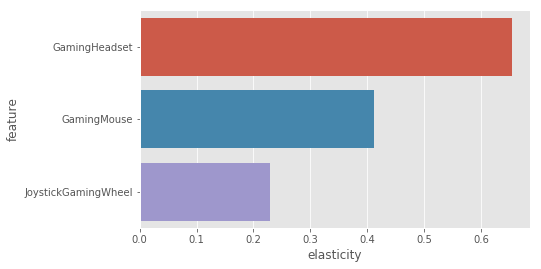

In [374]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### Residual Analysis


In [375]:
y_train_price = lr.predict(X_train_lm)

Text(0.5, 0, 'Errors')

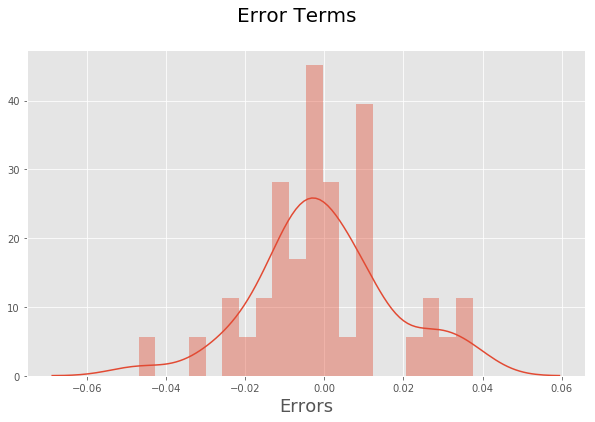

In [376]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Model Evaluation

In [377]:
# y_test = df_test.pop('gmv')
X_test = df_test

In [378]:
X_test = X_test[X_train_lm.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test.head()

,const,GamingHeadset,GamingMouse,JoystickGamingWheel
25,1.0,0.980153,0.976396,0.902053
48,1.0,0.914589,0.968585,1.000000
52,1.0,0.806907,0.913212,0.965255
37,1.0,0.869851,0.947593,0.913023
6,1.0,0.000000,0.000000,0.000000


In [379]:
# Making predictions using the model
y_pred = lr.predict(X_test)

Text(0, 0.5, 'y_pred')

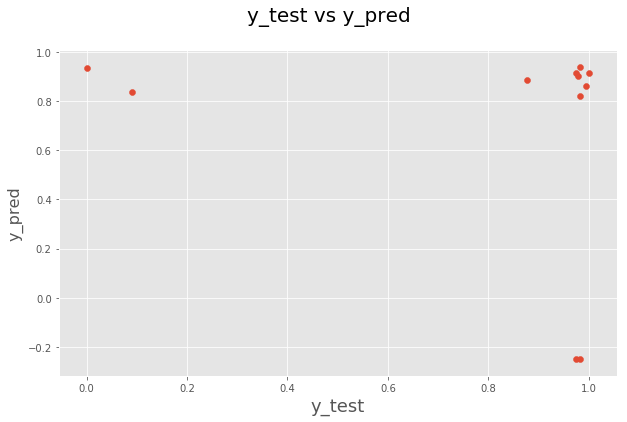

In [380]:
# Plotting y_test and y_pred to understand the spread
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

### III. Home Audio - Multiplicative model

In [381]:
#Creating df with removal of features uncontrollable by the company, also, replacing 0.0 with lowest value to handle infinity given by log
df = np.log(final_home_audio_data.replace(0.0, 0.000001).drop(['selling_price','units','product_mrp','total_transactions'], axis = 1))

In [382]:
#Checking the dataset
df.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,...,BoomBox,DJController,Dock,DockingStation,FMRadio,HiFiSystem,HomeAudioSpeaker,SlingBox,SoundMixer,VoiceRecorder
0,3.295837,1.945910,7.608374,-2.921877,-0.456885,0.617112,-8.363510,-1.103164,-1.989137,0.227872,...,1.386294,-13.815511,-13.815511,-13.815511,0.693147,-13.815511,3.258097,-13.815511,-13.815511,-13.815511
1,3.332205,1.945910,7.608374,-2.516412,-0.051419,1.022577,-7.958044,-0.697699,-1.583672,0.633337,...,4.094345,-13.815511,3.401197,0.000000,6.169611,2.564949,7.155396,-13.815511,-13.815511,3.218876
2,3.367296,1.945910,7.608374,-2.362261,0.102731,1.176728,-7.803894,-0.543549,-1.429521,0.787488,...,4.043051,-13.815511,3.912023,0.000000,6.276643,3.295837,7.320527,-13.815511,-13.815511,3.258097
3,3.401197,1.945910,7.608374,-2.293268,0.171724,1.245721,-7.734901,-0.474556,-1.360528,0.856481,...,4.174387,-13.815511,4.025352,-13.815511,6.232448,2.995732,7.194437,-13.815511,-13.815511,3.091042
4,3.433987,2.079442,7.608374,-2.955022,-0.090807,0.694922,-8.420842,-1.068883,-1.919477,0.591010,...,3.610918,-13.815511,3.784190,-13.815511,5.918894,2.397895,6.844815,-13.815511,-13.815511,2.772589


In [383]:
#Test-train split
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)

In [384]:
scaler = MinMaxScaler()

In [385]:
#Checking columns
df.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_premiumness',
       'total_holidays', 'is_holiday', 'total_special_sale_days',
       'is_special_sale_day', 'total_pay_days', 'is_pay_day', 'BoomBox',
       'DJController', 'Dock', 'DockingStation', 'FMRadio', 'HiFiSystem',
       'HomeAudioSpeaker', 'SlingBox', 'SoundMixer', 'VoiceRecorder'],
      dtype='object')

In [386]:
# Apply scaler() to all the columns except the categorical ones
num_vars=['adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holidays',
       'total_special_sale_days',
       'total_pay_days', 'BoomBox',
       'DJController', 'Dock', 'DockingStation', 'FMRadio', 'HiFiSystem',
       'HomeAudioSpeaker', 'SlingBox', 'SoundMixer', 'VoiceRecorder']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [387]:
y_train = df_train.pop('gmv')
X_train = df_train

In [388]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [389]:
#Extracting selected columns by RFE into a list
col = X_train.columns[rfe.support_]
col

Index(['Year', 'adStock_TV', 'adStock_Digital', 'adStock_Sponsorship',
       'adStock_Content Marketing', 'adStock_Online marketing',
       'adStock_ Affiliates', 'adStock_SEM', 'adStock_Radio', 'adStock_Other',
       'sla', 'NPS', 'BoomBox', 'Dock', 'DockingStation', 'FMRadio',
       'HiFiSystem', 'HomeAudioSpeaker', 'SoundMixer', 'VoiceRecorder'],
      dtype='object')

In [390]:
#Columns not supported by RFE
X_train.columns[~rfe.support_]

Index(['order_week', 'Month', 'product_procurement_sla', 'discount',
       'total_premiumness', 'total_holidays', 'is_holiday',
       'total_special_sale_days', 'is_special_sale_day', 'total_pay_days',
       'is_pay_day', 'DJController', 'SlingBox'],
      dtype='object')

In [391]:
# Creating dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [392]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2749.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           8.77e-29
Time:                        19:15:03   Log-Likelihood:                 182.68
No. Observations:                  40   AIC:                            -323.4
Df Residuals:                      19   BIC:                            -287.9
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,3.174567e+11
6,adStock_Online marketing,1.851995e+04
7,adStock_ Affiliates,1.557983e+04
10,adStock_Other,2.940140e+03
9,adStock_Radio,2.868780e+03
1,Year,3.366700e+02
5,adStock_Content Marketing,3.217500e+02
20,VoiceRecorder,1.943300e+02
2,adStock_TV,1.409600e+02
14,Dock,1.391100e+02


In [393]:
# Let's drop feature with highest p-value
X_train_new= X_train_rfe.drop(["adStock_Content Marketing"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3045.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.55e-30
Time:                        19:15:03   Log-Likelihood:                 182.67
No. Observations:                  40   AIC:                            -325.3
Df Residuals:                      20   BIC:                            -291.6
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,3.082335e+11
6,adStock_ Affiliates,4.275460e+03
5,adStock_Online marketing,4.009960e+03
9,adStock_Other,2.575540e+03
8,adStock_Radio,2.328760e+03
1,Year,3.268900e+02
19,VoiceRecorder,1.839900e+02
13,Dock,1.368400e+02
2,adStock_TV,1.099400e+02
16,HiFiSystem,1.075600e+02


In [394]:
# Let's drop feature with highest p-value
X_train_new1 = X_train_new.drop(["DockingStation"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new1)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3309.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           3.20e-32
Time:                        19:15:03   Log-Likelihood:                 182.28
No. Observations:                  40   AIC:                            -326.6
Df Residuals:                      21   BIC:                            -294.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,3.080754e+11
6,adStock_ Affiliates,4.224390e+03
5,adStock_Online marketing,3.937830e+03
9,adStock_Other,2.575490e+03
8,adStock_Radio,2.326980e+03
1,Year,3.267200e+02
18,VoiceRecorder,1.622500e+02
13,Dock,1.128000e+02
2,adStock_TV,1.089800e+02
15,HiFiSystem,1.075600e+02


In [395]:
# Let's drop feature with highest p-value
X_train_new2 = X_train_new1.drop(["VoiceRecorder"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new2)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3564.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           7.11e-34
Time:                        19:15:03   Log-Likelihood:                 181.69
No. Observations:                  40   AIC:                            -327.4
Df Residuals:                      22   BIC:                            -297.0
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,2.212419e+11
6,adStock_ Affiliates,4.053250e+03
5,adStock_Online marketing,3.842800e+03
8,adStock_Radio,2.139960e+03
9,adStock_Other,2.125410e+03
1,Year,2.346300e+02
2,adStock_TV,9.643000e+01
15,HiFiSystem,7.232000e+01
13,Dock,6.337000e+01
14,FMRadio,4.389000e+01


In [396]:
# Let's remove feature with highest p-value
X_train_new3 = X_train_new2.drop(["BoomBox"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new3)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3874.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.41e-35
Time:                        19:15:03   Log-Likelihood:                 181.26
No. Observations:                  40   AIC:                            -328.5
Df Residuals:                      23   BIC:                            -299.8
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,2.140494e+11
6,adStock_ Affiliates,3.603920e+03
5,adStock_Online marketing,3.451380e+03
8,adStock_Radio,2.134890e+03
9,adStock_Other,2.091200e+03
1,Year,2.270100e+02
2,adStock_TV,9.536000e+01
14,HiFiSystem,7.138000e+01
12,Dock,6.335000e+01
13,FMRadio,4.236000e+01


In [397]:
# Let's drop feature with higest p-value
X_train_new4 = X_train_new3.drop(["Dock"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new4)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4210.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.79e-37
Time:                        19:15:03   Log-Likelihood:                 180.78
No. Observations:                  40   AIC:                            -329.6
Df Residuals:                      24   BIC:                            -302.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,2.054000e+11
6,adStock_ Affiliates,3.290470e+03
5,adStock_Online marketing,3.196010e+03
8,adStock_Radio,2.130160e+03
9,adStock_Other,2.089570e+03
1,Year,2.178300e+02
2,adStock_TV,8.774000e+01
12,FMRadio,3.933000e+01
13,HiFiSystem,2.961000e+01
7,adStock_SEM,2.227000e+01


In [398]:
# Let's drop feature with higest p-value
X_train_new5 = X_train_new4.drop(["adStock_Online marketing"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new5)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4170.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.76e-38
Time:                        19:15:03   Log-Likelihood:                 178.39
No. Observations:                  40   AIC:                            -326.8
Df Residuals:                      25   BIC:                            -301.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1162.1527    

,Features,VIF
0,const,2.013457e+11
7,adStock_Radio,2.130000e+03
8,adStock_Other,2.089500e+03
1,Year,2.135300e+02
2,adStock_TV,6.519000e+01
5,adStock_ Affiliates,4.857000e+01
11,FMRadio,3.767000e+01
12,HiFiSystem,2.538000e+01
6,adStock_SEM,2.217000e+01
3,adStock_Digital,1.780000e+01


In [399]:
# Let's drop feature with higest p-value
X_train_new6 = X_train_new5.drop(["HiFiSystem"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new6)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4170.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.09e-39
Time:                        19:15:03   Log-Likelihood:                 176.13
No. Observations:                  40   AIC:                            -324.3
Df Residuals:                      26   BIC:                            -300.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1334.4135    

,Features,VIF
0,const,1.697774e+11
8,adStock_Other,1.679240e+03
7,adStock_Radio,1.481730e+03
1,Year,1.800500e+02
2,adStock_TV,5.892000e+01
5,adStock_ Affiliates,4.663000e+01
11,FMRadio,2.691000e+01
6,adStock_SEM,1.985000e+01
10,NPS,1.429000e+01
3,adStock_Digital,1.258000e+01


In [400]:
# Let's drop feature with higest p-value
X_train_new7= X_train_new6.drop(["adStock_Radio"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new7)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4274.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           5.43e-41
Time:                        19:15:03   Log-Likelihood:                 174.27
No. Observations:                  40   AIC:                            -322.5
Df Residuals:                      27   BIC:                            -300.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1322.7674    

,Features,VIF
0,const,1.696207e+11
1,Year,1.798800e+02
7,adStock_Other,1.576400e+02
5,adStock_ Affiliates,4.173000e+01
2,adStock_TV,3.742000e+01
10,FMRadio,2.527000e+01
6,adStock_SEM,1.888000e+01
11,HomeAudioSpeaker,1.178000e+01
9,NPS,1.177000e+01
3,adStock_Digital,1.130000e+01


In [401]:
# Let's drop feature with higest p-value
X_train_new8= X_train_new7.drop(["NPS"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new8)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4660.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.27e-42
Time:                        19:15:03   Log-Likelihood:                 173.53
No. Observations:                  40   AIC:                            -323.1
Df Residuals:                      28   BIC:                            -302.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1467.3019    

,Features,VIF
0,const,1.118587e+11
1,Year,1.186200e+02
7,adStock_Other,1.179600e+02
5,adStock_ Affiliates,3.969000e+01
2,adStock_TV,3.725000e+01
9,FMRadio,2.458000e+01
6,adStock_SEM,1.749000e+01
10,HomeAudioSpeaker,1.172000e+01
3,adStock_Digital,1.086000e+01
8,sla,8.620000e+00


In [402]:
# Let's drop feature with higest VIF

X_train_new9= X_train_new8.drop(["Year"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new9)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1812.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           9.72e-38
Time:                        19:15:03   Log-Likelihood:                 152.05
No. Observations:                  40   AIC:                            -282.1
Df Residuals:                      29   BIC:                            -263.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0073    

,Features,VIF
0,const,44.69
4,adStock_ Affiliates,34.08
1,adStock_TV,30.96
8,FMRadio,23.67
5,adStock_SEM,13.81
9,HomeAudioSpeaker,10.98
2,adStock_Digital,8.85
7,sla,8.41
3,adStock_Sponsorship,6.57
6,adStock_Other,3.01


In [403]:
# Let's drop feature with higest p-value
X_train_new10= X_train_new9.drop(["adStock_SEM"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new10)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2072.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.22e-39
Time:                        19:15:03   Log-Likelihood:                 151.94
No. Observations:                  40   AIC:                            -283.9
Df Residuals:                      30   BIC:                            -267.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0061    

,Features,VIF
0,const,35.63
1,adStock_TV,22.47
7,FMRadio,20.56
4,adStock_ Affiliates,19.28
8,HomeAudioSpeaker,10.19
6,sla,7.20
3,adStock_Sponsorship,4.78
5,adStock_Other,3.00
2,adStock_Digital,2.33
9,SoundMixer,2.22


In [404]:
# Let's drop feature with higest p-value
X_train_new11= X_train_new10.drop(["adStock_Sponsorship"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new11)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2405.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           4.46e-41
Time:                        19:15:03   Log-Likelihood:                 151.91
No. Observations:                  40   AIC:                            -285.8
Df Residuals:                      31   BIC:                            -270.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0062    

,Features,VIF
0,const,35.50
3,adStock_ Affiliates,18.69
1,adStock_TV,18.19
6,FMRadio,17.61
7,HomeAudioSpeaker,9.55
5,sla,6.00
4,adStock_Other,2.36
2,adStock_Digital,2.07
8,SoundMixer,1.80


In [405]:
# Let's drop feature with higest p-value
X_train_new12= X_train_new11.drop(["adStock_TV"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new12)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2812.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           9.19e-43
Time:                        19:15:03   Log-Likelihood:                 151.74
No. Observations:                  40   AIC:                            -287.5
Df Residuals:                      32   BIC:                            -274.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0061    

,Features,VIF
0,const,35.44
5,FMRadio,15.67
6,HomeAudioSpeaker,7.85
4,sla,5.88
3,adStock_Other,2.35
2,adStock_ Affiliates,2.32
1,adStock_Digital,1.93
7,SoundMixer,1.27


In [406]:
# Let's drop feature with higest p-value
X_train_new13= X_train_new12.drop(["adStock_Digital"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new13)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3324.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.02e-44
Time:                        19:15:03   Log-Likelihood:                 151.39
No. Observations:                  40   AIC:                            -288.8
Df Residuals:                      33   BIC:                            -276.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0055    

,Features,VIF
0,const,34.78
4,FMRadio,15.67
5,HomeAudioSpeaker,7.72
3,sla,5.87
1,adStock_ Affiliates,2.28
2,adStock_Other,1.49
6,SoundMixer,1.26


In [407]:
# Let's drop feature with higest p-value
X_train_new14= X_train_new13.drop(["adStock_Other"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new14)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3821.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.02e-45
Time:                        19:15:03   Log-Likelihood:                 149.93
No. Observations:                  40   AIC:                            -287.9
Df Residuals:                      34   BIC:                            -277.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0069    

,Features,VIF
0,const,33.96
3,FMRadio,15.65
4,HomeAudioSpeaker,7.67
2,sla,5.50
1,adStock_ Affiliates,2.24
5,SoundMixer,1.20


In [408]:
# Let's drop feature with higest VIF
X_train_new15= X_train_new14.drop(["adStock_ Affiliates"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new15)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     4608.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           4.23e-47
Time:                        19:15:03   Log-Likelihood:                 148.64
No. Observations:                  40   AIC:                            -287.3
Df Residuals:                      35   BIC:                            -278.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0066      0.006  

,Features,VIF
0,const,33.91
2,FMRadio,12.51
3,HomeAudioSpeaker,7.67
1,sla,3.35
4,SoundMixer,1.15


In [409]:
# Let's drop feature with higest p-value
X_train_new16= X_train_new15.drop(["FMRadio"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new16)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2701.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.05e-42
Time:                        19:15:04   Log-Likelihood:                 131.69
No. Observations:                  40   AIC:                            -255.4
Df Residuals:                      36   BIC:                            -248.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0186      0.008  

,Features,VIF
0,const,30.76
1,sla,1.48
2,HomeAudioSpeaker,1.38
3,SoundMixer,1.08


##### Selecting this model as the final model as the VIFs & the p-values are in acceptable range

In [410]:
# k-fold Cross validation
lm = LinearRegression()
scores = cross_val_score(lm, X_train_lm, y_train, scoring='r2', cv=10)
scores.mean()

0.904274791706268

In [411]:
# k-fold Cross validation
lm = LinearRegression()
scores = cross_val_score(lm, X_train_lm, y_train, scoring='neg_mean_squared_error', cv=10)
-scores.mean()

0.000249637442552072

### Residual Analysis


In [412]:
y_train_price = lr.predict(X_train_lm)

Text(0.5, 0, 'Errors')

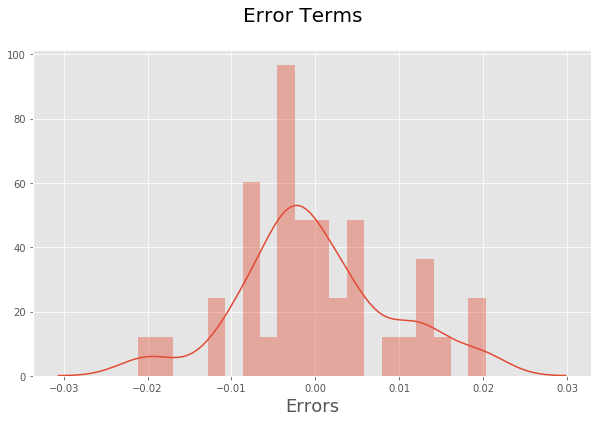

In [413]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Elasticity

In [414]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm, y_train, coefficients_df)

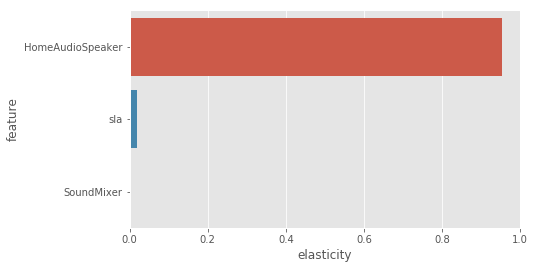

In [415]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### Model Evaluation

In [416]:
X_test = df_test
y_test = df_test.pop('gmv')

In [417]:
X_test = X_test[X_train_lm.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test

,const,sla,HomeAudioSpeaker,SoundMixer
6,1.0,0.429915,0.887885,0.000000
36,1.0,0.390431,0.896755,0.000000
37,1.0,0.473084,0.876060,0.000000
28,1.0,0.255891,1.000000,0.000000
43,1.0,0.291969,0.876738,0.954404
49,1.0,0.000000,0.790585,0.000000
5,1.0,1.000000,0.000000,0.000000
33,1.0,0.363384,0.982409,0.000000
20,1.0,0.268393,0.994778,0.000000
42,1.0,0.302368,0.890951,1.000000


In [418]:
# Making predictions using the fourth model
y_pred = lr.predict(X_test)

Text(0, 0.5, 'y_pred')

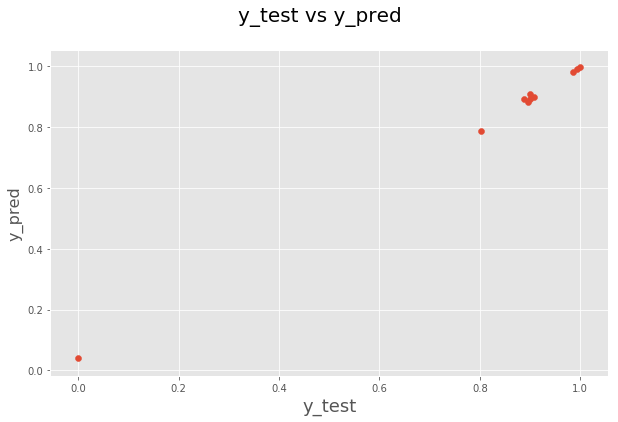

In [419]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

## Koyk Model building

**Function to create lagged GMV for each of the three categories for creating this model**

In [420]:
def createKyockKPI(df):
    df['gmv_lag'] = df['gmv'].shift(1)
    return df.fillna(0)

### I. Camera Accessory - Kyock's Model

In [421]:
# adding lag variable in the camera data set
df = createKyockKPI(final_camera_data)
df.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,...,ExtensionTube,Filter,Flash,FlashShoeAdapter,Lens,ReflectorUmbrella,Softbox,Strap,Telescope,gmv_lag
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,...,0.0,226.0,17.0,0.0,366.0,0.0,0.0,13.0,16.0,15375.0
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,...,0.0,188.0,23.0,0.0,382.0,0.0,0.0,24.0,22.0,2019042.0
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,...,0.0,194.0,18.0,0.0,423.0,0.0,0.0,23.0,30.0,2249245.0
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,...,0.0,112.0,26.0,0.0,233.0,0.0,0.0,23.0,13.0,2105858.0


In [422]:
df.shape

(52, 51)

In [423]:
#Dropping the features which cannot be handled by the company
df = df.drop(['selling_price','units','product_mrp','total_transactions'], axis = 1)

In [424]:
df.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,...,ExtensionTube,Filter,Flash,FlashShoeAdapter,Lens,ReflectorUmbrella,Softbox,Strap,Telescope,gmv_lag
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,...,0.0,226.0,17.0,0.0,366.0,0.0,0.0,13.0,16.0,15375.0
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,...,0.0,188.0,23.0,0.0,382.0,0.0,0.0,24.0,22.0,2019042.0
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,...,0.0,194.0,18.0,0.0,423.0,0.0,0.0,23.0,30.0,2249245.0
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,...,0.0,112.0,26.0,0.0,233.0,0.0,0.0,23.0,13.0,2105858.0


In [425]:
#Test-train split
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)

In [426]:
scaler = MinMaxScaler()

In [427]:
df.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_premiumness',
       'total_holidays', 'is_holiday', 'total_special_sale_days',
       'is_special_sale_day', 'total_pay_days', 'is_pay_day', 'Binoculars',
       'CameraAccessory', 'CameraBag', 'CameraBattery', 'CameraBatteryCharger',
       'CameraBatteryGrip', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing',
       'CameraMicrophone', 'CameraMount', 'CameraRemoteControl',
       'CameraTripod', 'ExtensionTube', 'Filter', 'Flash', 'FlashShoeAdapter',
       'Lens', 'ReflectorUmbrella', 'Softbox', 'Strap', 'Telescope',
       'gmv_lag'],
      dtype='object')

In [428]:
# Apply scaler() to all the columns except the categoriacal variables
num_vars=['adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holidays',
       'total_special_sale_days', 
       'total_pay_days',
       'Binoculars', 'CameraAccessory', 'CameraBag', 'CameraBattery',
       'CameraBatteryCharger', 'CameraBatteryGrip', 'CameraEyeCup',
       'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone', 'CameraMount',
       'CameraRemoteControl', 'CameraTripod', 'ExtensionTube', 'Filter',
       'Flash', 'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella', 'Softbox',
       'Strap', 'Telescope', 'gmv_lag']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [429]:
y_train = df_train.pop('gmv')
X_train = df_train

In [430]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [431]:
# selecting the features given by rfe
col = X_train.columns[rfe.support_]
col

Index(['adStock_TV', 'adStock_Digital', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'sla', 'product_procurement_sla',
       'discount', 'NPS', 'Binoculars', 'CameraBattery', 'CameraMicrophone',
       'CameraTripod', 'Filter', 'Flash', 'ReflectorUmbrella', 'Strap'],
      dtype='object')

In [432]:
# negelecting features not selected by rfe
X_train.columns[~rfe.support_]

Index(['order_week', 'Month', 'Year', 'adStock_Sponsorship',
       'total_premiumness', 'total_holidays', 'is_holiday',
       'total_special_sale_days', 'is_special_sale_day', 'total_pay_days',
       'is_pay_day', 'CameraAccessory', 'CameraBag', 'CameraBatteryCharger',
       'CameraBatteryGrip', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing',
       'CameraMount', 'CameraRemoteControl', 'ExtensionTube',
       'FlashShoeAdapter', 'Lens', 'Softbox', 'Telescope', 'gmv_lag'],
      dtype='object')

In [433]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [434]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     222.1
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.91e-19
Time:                        19:15:10   Log-Likelihood:                 127.76
No. Observations:                  41   AIC:                            -213.5
Df Residuals:                      20   BIC:                            -177.5
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
6,adStock_SEM,6782.18
2,adStock_Digital,5000.14
4,adStock_Online marketing,4531.15
5,adStock_ Affiliates,4063.24
7,adStock_Radio,2288.20
8,adStock_Other,2231.61
0,const,778.15
1,adStock_TV,343.16
3,adStock_Content Marketing,185.06
11,discount,26.04


In [435]:
# Let's drop feature  with highest p-value 
X_train_new= X_train_rfe.drop(["adStock_Content Marketing"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     242.7
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.04e-20
Time:                        19:15:10   Log-Likelihood:                 127.52
No. Observations:                  41   AIC:                            -215.0
Df Residuals:                      21   BIC:                            -180.8
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
5,adStock_SEM,6741.69
2,adStock_Digital,4788.79
3,adStock_Online marketing,3088.98
4,adStock_ Affiliates,2974.58
6,adStock_Radio,2281.21
7,adStock_Other,2208.32
0,const,720.04
1,adStock_TV,342.53
10,discount,25.64
17,Flash,19.79


In [436]:
# # Let's drop feature  with highest p-value 
X_train_new1 = X_train_new.drop(["CameraMicrophone"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new1)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     252.8
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.33e-21
Time:                        19:15:10   Log-Likelihood:                 126.30
No. Observations:                  41   AIC:                            -214.6
Df Residuals:                      22   BIC:                            -182.0
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
5,adStock_SEM,3885.26
2,adStock_Digital,2844.05
6,adStock_Radio,1663.72
3,adStock_Online marketing,1601.27
7,adStock_Other,1591.23
4,adStock_ Affiliates,1455.38
0,const,718.95
1,adStock_TV,188.32
10,discount,18.01
16,Flash,14.21


In [437]:
# Let's drop feature  with highest p-value
X_train_new2 = X_train_new1.drop(["NPS"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new2)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     272.0
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.88e-22
Time:                        19:15:10   Log-Likelihood:                 125.73
No. Observations:                  41   AIC:                            -215.5
Df Residuals:                      23   BIC:                            -184.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
5,adStock_SEM,2505.59
2,adStock_Digital,1781.50
3,adStock_Online marketing,1554.50
4,adStock_ Affiliates,1380.63
6,adStock_Radio,1081.10
7,adStock_Other,1038.03
0,const,706.68
1,adStock_TV,139.53
10,discount,17.41
15,Flash,13.68


In [438]:
# Let's drop feature  with highest p-value 
X_train_new3 = X_train_new2.drop(["product_procurement_sla"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new3)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     268.9
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           4.13e-23
Time:                        19:15:10   Log-Likelihood:                 123.38
No. Observations:                  41   AIC:                            -212.8
Df Residuals:                      24   BIC:                            -183.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
5,adStock_SEM,1396.50
3,adStock_Online marketing,1048.26
2,adStock_Digital,987.43
4,adStock_ Affiliates,896.60
6,adStock_Radio,712.08
7,adStock_Other,685.43
0,const,168.22
1,adStock_TV,85.32
9,discount,15.38
14,Flash,13.67


In [439]:
# Let's drop feature  with highest p-value 
X_train_new4 = X_train_new3.drop(["sla"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new4)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     251.1
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.00e-23
Time:                        19:15:10   Log-Likelihood:                 119.84
No. Observations:                  41   AIC:                            -207.7
Df Residuals:                      25   BIC:                            -180.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
5,adStock_SEM,1358.01
3,adStock_Online marketing,1020.66
2,adStock_Digital,961.44
4,adStock_ Affiliates,857.96
6,adStock_Radio,668.87
7,adStock_Other,642.32
1,adStock_TV,80.00
0,const,59.18
13,Flash,9.94
9,Binoculars,8.26


In [440]:
# Let's drop feature  with highest p-value 
X_train_new5 = X_train_new4.drop(["discount"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new5)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     261.7
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.75e-24
Time:                        19:15:10   Log-Likelihood:                 118.48
No. Observations:                  41   AIC:                            -207.0
Df Residuals:                      26   BIC:                            -181.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
5,adStock_SEM,1198.32
3,adStock_Online marketing,959.26
2,adStock_Digital,851.16
4,adStock_ Affiliates,783.40
6,adStock_Radio,553.62
7,adStock_Other,525.12
1,adStock_TV,64.91
0,const,57.64
8,Binoculars,8.06
12,Flash,7.02


In [441]:
# Let's drop feature  with highest  vif
X_train_new6 = X_train_new5.drop(["adStock_Online marketing"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new6)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     157.5
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           5.98e-22
Time:                        19:15:10   Log-Likelihood:                 105.91
No. Observations:                  41   AIC:                            -183.8
Df Residuals:                      27   BIC:                            -159.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0857    

,Features,VIF
5,adStock_Radio,503.49
6,adStock_Other,469.41
4,adStock_SEM,468.94
2,adStock_Digital,386.73
1,adStock_TV,50.26
0,const,36.78
3,adStock_ Affiliates,14.63
7,Binoculars,7.35
13,Strap,6.20
11,Flash,6.05


In [442]:
# Let's drop feature  with highest p-value 
X_train_new7= X_train_new6.drop(["ReflectorUmbrella"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new7)
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     176.5
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           4.53e-23
Time:                        19:15:10   Log-Likelihood:                 105.85
No. Observations:                  41   AIC:                            -185.7
Df Residuals:                      28   BIC:                            -163.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0866    

,Features,VIF
5,adStock_Radio,491.74
4,adStock_SEM,465.60
6,adStock_Other,458.09
2,adStock_Digital,383.84
1,adStock_TV,50.19
0,const,35.86
3,adStock_ Affiliates,14.57
7,Binoculars,7.35
12,Strap,6.20
11,Flash,5.69


In [443]:
# Let's drop feature  with highest p-value 
X_train_new8= X_train_new7.drop(["adStock_ Affiliates"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new8)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     196.5
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           3.82e-24
Time:                        19:15:10   Log-Likelihood:                 105.56
No. Observations:                  41   AIC:                            -187.1
Df Residuals:                      29   BIC:                            -166.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0859      0.020     

,Features,VIF
3,adStock_SEM,458.83
2,adStock_Digital,379.26
4,adStock_Radio,361.50
5,adStock_Other,344.79
0,const,35.78
1,adStock_TV,26.75
6,Binoculars,6.70
11,Strap,6.19
10,Flash,5.64
9,Filter,5.05


In [444]:
# Let's drop feature  with highest p-value 
X_train_new9= X_train_new8.drop(["adStock_SEM"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new9)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     142.8
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.80e-22
Time:                        19:15:10   Log-Likelihood:                 96.513
No. Observations:                  41   AIC:                            -171.0
Df Residuals:                      30   BIC:                            -152.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0193      0.015     

,Features,VIF
4,adStock_Other,30.82
3,adStock_Radio,29.95
0,const,12.19
5,Binoculars,6.05
9,Flash,5.61
10,Strap,5.55
8,Filter,4.91
6,CameraBattery,4.49
1,adStock_TV,3.22
7,CameraTripod,2.77


In [445]:
# Let's drop feature  with highest p-value 
X_train_new10= X_train_new9.drop(["adStock_Digital"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new10)
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     155.9
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.91e-23
Time:                        19:15:10   Log-Likelihood:                 95.496
No. Observations:                  41   AIC:                            -171.0
Df Residuals:                      31   BIC:                            -153.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0196      0.015      1.325

,Features,VIF
3,adStock_Other,30.51
2,adStock_Radio,29.82
0,const,12.19
4,Binoculars,5.80
9,Strap,5.55
8,Flash,5.25
7,Filter,4.72
5,CameraBattery,4.36
1,adStock_TV,2.93
6,CameraTripod,2.73


In [446]:
# Let's drop feature  with highest p-value 
X_train_new11= X_train_new10.drop(["adStock_TV"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new11)
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     175.8
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           3.26e-24
Time:                        19:15:10   Log-Likelihood:                 94.918
No. Observations:                  41   AIC:                            -171.8
Df Residuals:                      32   BIC:                            -156.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0234      0.014      1.647

,Features,VIF
1,adStock_Radio,14.72
2,adStock_Other,13.40
0,const,11.28
7,Flash,5.25
8,Strap,5.06
3,Binoculars,5.01
6,Filter,4.70
4,CameraBattery,3.81
5,CameraTripod,2.37


In [447]:
## Let's drop feature on the vif values to get less drop in adj. r2 value
X_train_new12= X_train_new11.drop(["adStock_Other"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new12)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     204.1
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.78e-25
Time:                        19:15:10   Log-Likelihood:                 94.609
No. Observations:                  41   AIC:                            -173.2
Df Residuals:                      33   BIC:                            -159.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0228      0.014      1.626

,Features,VIF
0,const,11.25
6,Flash,5.25
7,Strap,4.90
2,Binoculars,4.74
5,Filter,4.69
3,CameraBattery,3.39
4,CameraTripod,2.36
1,adStock_Radio,1.52


In [448]:
# dropping feature on the basis of highest p-value
X_train_new13= X_train_new12.drop(["Flash"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new13)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     219.1
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.10e-25
Time:                        19:15:10   Log-Likelihood:                 92.344
No. Observations:                  41   AIC:                            -170.7
Df Residuals:                      34   BIC:                            -158.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0113      0.013      0.851

,Features,VIF
0,const,9.28
5,Filter,4.67
2,Binoculars,4.25
3,CameraBattery,3.27
6,Strap,2.31
4,CameraTripod,2.22
1,adStock_Radio,1.30


In [449]:
X_train_new14= X_train_new13
 # Add a constant
X_train_lm1 = sm.add_constant(X_train_new14)
    
lr1 = sm.OLS(y_train, X_train_lm1).fit()

lr1.params
print(lr1.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1 .values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     219.1
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.10e-25
Time:                        19:15:10   Log-Likelihood:                 92.344
No. Observations:                  41   AIC:                            -170.7
Df Residuals:                      34   BIC:                            -158.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0113      0.013      0.851

,Features,VIF
0,const,9.28
5,Filter,4.67
2,Binoculars,4.25
3,CameraBattery,3.27
6,Strap,2.31
4,CameraTripod,2.22
1,adStock_Radio,1.30


In [450]:
# dropping the value based on the vif's to check less drop in adj. r2 value
X_train_new15= X_train_new14.drop(["Filter"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train_new15)
    
lr2 = sm.OLS(y_train, X_train_lm2).fit()

lr2.params
print(lr2.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2 .values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     135.0
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           7.57e-22
Time:                        19:15:10   Log-Likelihood:                 78.601
No. Observations:                  41   AIC:                            -145.2
Df Residuals:                      35   BIC:                            -134.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.018      0.059

,Features,VIF
0,const,9.11
2,Binoculars,2.94
3,CameraBattery,2.73
5,Strap,2.12
4,CameraTripod,1.99
1,adStock_Radio,1.25


In [451]:
# dropping the feature on the basis of high p-value
X_train_new16= X_train_new15.drop(["Strap"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train_new16)
    
lr2 = sm.OLS(y_train, X_train_lm2).fit()

lr2.params
print(lr2.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2 .values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     141.8
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.66e-21
Time:                        19:15:10   Log-Likelihood:                 74.679
No. Observations:                  41   AIC:                            -139.4
Df Residuals:                      36   BIC:                            -130.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0141      0.019      0.744

,Features,VIF
0,const,8.47
2,Binoculars,2.69
3,CameraBattery,2.26
4,CameraTripod,1.76
1,adStock_Radio,1.07


In [452]:
# k-fold Cross Validation - Adjusted R-squared
lm = LinearRegression()
#Checking performance of top 4 models finding Adjusted R-squared
x_trains = [X_train_lm1, X_train_lm2]
for i in range(0,len(x_trains)):
    x_test = x_trains[i]
    scores = cross_val_score(lm, x_test, y_train , scoring='r2', cv=5)
    print("lr model",i+1,"r2_score", scores.mean())

lr model 1 r2_score 0.8941438032086765
lr model 2 r2_score 0.7267735211571387


In [453]:
# k-fold Cross Validation - MSE
lm = LinearRegression()
#Checking performance of top 4 models finding Adjusted R-squared
x_trains = [X_train_lm1, X_train_lm2]
for i in range(0,len(x_trains)):
    x_test = x_trains[i]
    scores = cross_val_score(lm, x_test, y_train , scoring='neg_mean_squared_error', cv=5)
    print("lr model",i+1,"MSE", -scores.mean())

lr model 1 MSE 0.0019727170865584598
lr model 2 MSE 0.00303963502573904


#### As we see linear model 1 performs much better having lowest MSE than the other two models, therefore we choose that as the best among the multiplicative models for Camera Category

### Residual Analysis


In [454]:
y_train_price = lr1.predict(X_train_lm1)

Text(0.5, 0, 'Errors')

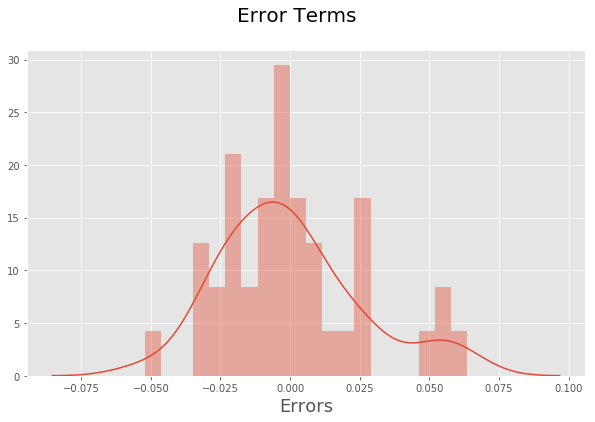

In [455]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Model Evaluation

In [456]:
y_test = df_test.pop('gmv')
X_test = df_test

In [457]:
X_test.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'sla', 'product_procurement_sla',
       'discount', 'NPS', 'total_premiumness', 'total_holidays', 'is_holiday',
       'total_special_sale_days', 'is_special_sale_day', 'total_pay_days',
       'is_pay_day', 'Binoculars', 'CameraAccessory', 'CameraBag',
       'CameraBattery', 'CameraBatteryCharger', 'CameraBatteryGrip',
       'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone',
       'CameraMount', 'CameraRemoteControl', 'CameraTripod', 'ExtensionTube',
       'Filter', 'Flash', 'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella',
       'Softbox', 'Strap', 'Telescope', 'gmv_lag'],
      dtype='object')

In [458]:
X_test.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,...,ExtensionTube,Filter,Flash,FlashShoeAdapter,Lens,ReflectorUmbrella,Softbox,Strap,Telescope,gmv_lag
6,33,8,2015,0.000000,0.387803,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
32,60,2,2016,0.440584,0.588921,0.211609,0.718614,0.866206,0.972552,0.329271,...,0.0,0.692308,0.686877,0.0,0.626277,0.0,0.0,0.767442,0.460317,0.694230
38,66,4,2016,0.990971,0.300736,0.617353,0.191557,0.671023,0.790947,0.230894,...,0.4,0.720000,0.627544,0.0,0.600000,0.0,0.5,0.720930,0.666667,0.757333
35,63,3,2016,1.000000,0.579623,0.611897,0.418960,0.681721,0.785803,0.251681,...,1.0,1.000000,0.657861,0.0,0.681752,1.0,0.0,0.976744,0.746032,0.802749
33,61,2,2016,0.422372,0.644730,0.222695,0.696666,0.857921,0.963873,0.336290,...,0.6,0.649231,0.879168,0.0,0.551825,0.0,0.5,0.976744,0.682540,1.000000


In [459]:
X_test = X_test[X_train_lm1.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test

,const,adStock_Radio,Binoculars,CameraBattery,CameraTripod,Filter,Strap
6,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
32,1.0,0.218750,0.876866,1.000000,0.969427,0.692308,0.767442
38,1.0,0.241667,0.925373,0.746073,0.713376,0.720000,0.720930
35,1.0,0.386667,0.910448,0.749346,0.791083,1.000000,0.976744
33,1.0,0.093750,0.985075,0.545812,0.960510,0.649231,0.976744
51,1.0,0.012731,0.417910,0.165576,0.110828,0.335385,0.465116
5,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
26,1.0,1.000000,0.858209,0.363874,1.000000,0.695385,0.604651
25,1.0,0.000000,0.861940,0.419503,0.854777,0.784615,0.651163
45,1.0,0.763889,1.000000,0.496073,0.537580,0.640000,1.000000


In [460]:
# Making predictions using the final model
y_pred = lr1.predict(X_test)

Text(0, 0.5, 'y_pred')

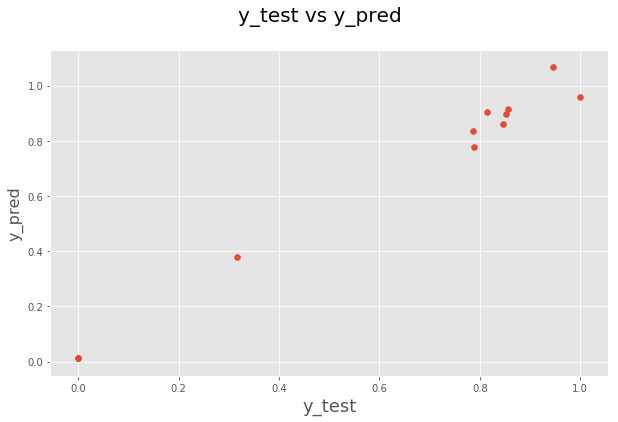

In [461]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

### Elasticity Analysis

In [462]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr1.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm1, y_train, coefficients_df)

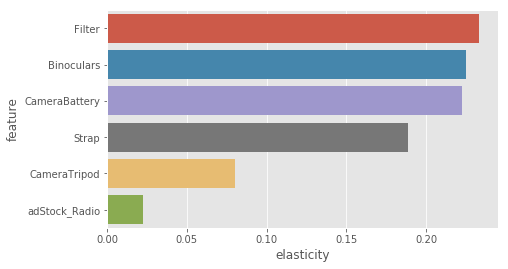

In [463]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### II. Gaming Accessory - Kyock's model

In [464]:
# Creating the lagged KPI i.e. lagged_GMV for Kyock Model
df = createKyockKPI(final_gaming_data)

In [465]:
# Keeping only those features which can be controlled by the company 
df = df.drop(['selling_price','units','product_mrp','total_transactions'], axis = 1)

In [466]:
df.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,...,GamingHeadset,GamingKeyboard,GamingMemoryCard,GamingMouse,GamingMousePad,GamingSpeaker,JoystickGamingWheel,MotionController,TVOutCableAccessory,gmv_lag
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,...,2.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.000000e+00
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,...,177.0,433.0,36.0,971.0,55.0,0.0,11.0,16.0,73.0,2.234400e+04
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,...,179.0,166.0,27.0,359.0,48.0,0.0,8.0,11.0,92.0,1.931187e+06
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,...,283.0,174.0,28.0,449.0,67.0,0.0,12.0,11.0,93.0,1.614474e+06
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,...,424.0,78.0,11.0,239.0,39.0,1.0,19.0,8.0,79.0,1.748798e+06


In [467]:
#Test-train split
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.20, random_state = 100)

In [468]:
scaler = MinMaxScaler()

In [469]:
df.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'NPS', 'discount', 'total_premiumness',
       'total_holidays', 'is_holiday', 'total_special_sale_days',
       'is_special_sale_day', 'total_pay_days', 'is_pay_day', 'CoolingPad',
       'GameControlMount', 'GamePad', 'GamingAccessoryKit', 'GamingAdapter',
       'GamingChargingStation', 'GamingHeadset', 'GamingKeyboard',
       'GamingMemoryCard', 'GamingMouse', 'GamingMousePad', 'GamingSpeaker',
       'JoystickGamingWheel', 'MotionController', 'TVOutCableAccessory',
       'gmv_lag'],
      dtype='object')

In [470]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars=['adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holidays',
       'total_special_sale_days', 
       'total_pay_days',
       'CoolingPad', 'GameControlMount', 'GamePad', 'GamingAccessoryKit',
       'GamingAdapter', 'GamingChargingStation', 'GamingHeadset',
       'GamingKeyboard', 'GamingMemoryCard', 'GamingMouse', 'GamingMousePad',
       'GamingSpeaker', 'JoystickGamingWheel', 'MotionController',
       'TVOutCableAccessory', 'gmv_lag']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [471]:
y_train = df_train.pop('gmv')
X_train = df_train

In [472]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [473]:
#Columns which are supported by RFE
col = X_train.columns[rfe.support_]
col

Index(['Year', 'adStock_TV', 'adStock_Digital', 'adStock_Content Marketing',
       'adStock_ Affiliates', 'adStock_SEM', 'adStock_Radio', 'adStock_Other',
       'NPS', 'total_holidays', 'is_holiday', 'GamingAccessoryKit',
       'GamingAdapter', 'GamingHeadset', 'GamingKeyboard', 'GamingMemoryCard',
       'GamingMouse', 'GamingSpeaker', 'JoystickGamingWheel',
       'MotionController'],
      dtype='object')

In [474]:
#Columns which are not supported by RFE
X_train.columns[~rfe.support_]

Index(['order_week', 'Month', 'adStock_Sponsorship',
       'adStock_Online marketing', 'sla', 'product_procurement_sla',
       'discount', 'total_premiumness', 'total_special_sale_days',
       'is_special_sale_day', 'total_pay_days', 'is_pay_day', 'CoolingPad',
       'GameControlMount', 'GamePad', 'GamingChargingStation',
       'GamingMousePad', 'TVOutCableAccessory', 'gmv_lag'],
      dtype='object')

In [475]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [476]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     114.3
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           4.35e-17
Time:                        19:15:16   Log-Likelihood:                 114.93
No. Observations:                  42   AIC:                            -187.9
Df Residuals:                      21   BIC:                            -151.4
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,8.925740e+08
6,adStock_SEM,7.454440e+03
3,adStock_Digital,4.475930e+03
7,adStock_Radio,3.753880e+03
8,adStock_Other,3.657300e+03
2,adStock_TV,4.854200e+02
4,adStock_Content Marketing,2.843000e+02
5,adStock_ Affiliates,8.000000e+01
1,Year,5.488000e+01
19,JoystickGamingWheel,2.863000e+01


In [477]:
# Let's drop feature with highest p-value
X_train_new= X_train_rfe.drop(["JoystickGamingWheel"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     115.4
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           9.74e-18
Time:                        19:15:16   Log-Likelihood:                 113.11
No. Observations:                  42   AIC:                            -186.2
Df Residuals:                      22   BIC:                            -151.5
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,2.868306e+08
6,adStock_SEM,6.218360e+03
3,adStock_Digital,3.569970e+03
7,adStock_Radio,3.373580e+03
8,adStock_Other,3.348650e+03
2,adStock_TV,4.030900e+02
4,adStock_Content Marketing,2.820900e+02
5,adStock_ Affiliates,7.941000e+01
10,total_holidays,2.108000e+01
11,is_holiday,2.054000e+01


In [478]:
# Let's drop feature with highest p-value
X_train_new1 = X_train_new.drop(["GamingAdapter"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new1)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     120.7
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.55e-18
Time:                        19:15:16   Log-Likelihood:                 111.98
No. Observations:                  42   AIC:                            -186.0
Df Residuals:                      23   BIC:                            -152.9
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,2.823193e+08
6,adStock_SEM,6.015710e+03
3,adStock_Digital,3.515650e+03
7,adStock_Radio,3.351380e+03
8,adStock_Other,3.313910e+03
2,adStock_TV,4.022400e+02
4,adStock_Content Marketing,2.466000e+02
5,adStock_ Affiliates,7.857000e+01
10,total_holidays,2.107000e+01
11,is_holiday,2.047000e+01


In [479]:
# Let's drop feature with highest p-value
X_train_new2 = X_train_new1.drop(["GamingKeyboard"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new2)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     125.9
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.58e-19
Time:                        19:15:16   Log-Likelihood:                 110.79
No. Observations:                  42   AIC:                            -185.6
Df Residuals:                      24   BIC:                            -154.3
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,2.751940e+08
6,adStock_SEM,5.236440e+03
3,adStock_Digital,2.947290e+03
7,adStock_Radio,2.831630e+03
8,adStock_Other,2.818960e+03
2,adStock_TV,3.418600e+02
4,adStock_Content Marketing,2.445300e+02
5,adStock_ Affiliates,6.654000e+01
10,total_holidays,2.063000e+01
11,is_holiday,1.989000e+01


In [480]:
# Let's remove feature with highest VIF
X_train_new3 = X_train_new2.drop(["adStock_SEM"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new3)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     63.38
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           3.12e-16
Time:                        19:15:16   Log-Likelihood:                 94.526
No. Observations:                  42   AIC:                            -155.1
Df Residuals:                      25   BIC:                            -125.5
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,1.154553e+08
6,adStock_Radio,2.095000e+02
7,adStock_Other,1.733900e+02
4,adStock_Content Marketing,8.423000e+01
3,adStock_Digital,7.034000e+01
2,adStock_TV,3.567000e+01
5,adStock_ Affiliates,3.075000e+01
9,total_holidays,1.726000e+01
10,is_holiday,1.645000e+01
12,GamingHeadset,1.036000e+01


In [481]:
# Let's drop feature with higest p-value
X_train_new4 = X_train_new3.drop(["Year"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new4)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     70.19
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           3.71e-17
Time:                        19:15:17   Log-Likelihood:                 94.489
No. Observations:                  42   AIC:                            -157.0
Df Residuals:                      26   BIC:                            -129.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
5,adStock_Radio,198.18
6,adStock_Other,169.71
3,adStock_Content Marketing,82.73
2,adStock_Digital,70.11
0,const,68.75
1,adStock_TV,31.27
4,adStock_ Affiliates,30.69
9,is_holiday,13.03
8,total_holidays,13.02
11,GamingHeadset,8.19


In [482]:
# Let's drop feature with highest p-value
X_train_new5 = X_train_new4.drop(["total_holidays"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new5)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     78.01
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           4.13e-18
Time:                        19:15:17   Log-Likelihood:                 94.468
No. Observations:                  42   AIC:                            -158.9
Df Residuals:                      27   BIC:                            -132.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
5,adStock_Radio,198.15
6,adStock_Other,169.70
3,adStock_Content Marketing,82.53
2,adStock_Digital,69.97
0,const,67.27
1,adStock_TV,31.23
4,adStock_ Affiliates,30.54
10,GamingHeadset,8.12
7,NPS,7.42
9,GamingAccessoryKit,5.43


In [483]:
# Let's drop feature with highest p-value
X_train_new6 = X_train_new5.drop(["adStock_Digital"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new6)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     85.56
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           5.49e-19
Time:                        19:15:17   Log-Likelihood:                 94.096
No. Observations:                  42   AIC:                            -160.2
Df Residuals:                      28   BIC:                            -135.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
4,adStock_Radio,145.19
5,adStock_Other,136.70
0,const,58.98
3,adStock_ Affiliates,29.88
1,adStock_TV,28.90
9,GamingHeadset,6.64
6,NPS,4.56
8,GamingAccessoryKit,4.14
11,GamingMouse,3.40
10,GamingMemoryCard,2.97


In [484]:
# Let's drop feature with highest p-value
X_train_new7= X_train_new6.drop(["adStock_Other"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new7)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     94.76
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           6.52e-20
Time:                        19:15:17   Log-Likelihood:                 93.831
No. Observations:                  42   AIC:                            -161.7
Df Residuals:                      29   BIC:                            -139.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,58.58
3,adStock_ Affiliates,8.42
5,NPS,4.55
1,adStock_TV,4.17
7,GamingAccessoryKit,3.93
8,GamingHeadset,3.87
10,GamingMouse,2.81
9,GamingMemoryCard,2.61
4,adStock_Radio,2.54
2,adStock_Content Marketing,2.52


In [485]:
# Let's drop feature with highest p-value
X_train_new8= X_train_new7.drop(["GamingMemoryCard"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new8)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     104.2
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           8.86e-21
Time:                        19:15:17   Log-Likelihood:                 93.306
No. Observations:                  42   AIC:                            -162.6
Df Residuals:                      30   BIC:                            -141.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,49.58
3,adStock_ Affiliates,8.41
1,adStock_TV,4.08
5,NPS,3.95
7,GamingAccessoryKit,3.92
8,GamingHeadset,3.76
9,GamingMouse,2.80
2,adStock_Content Marketing,2.44
11,MotionController,2.17
10,GamingSpeaker,1.90


In [486]:
# Let's drop feature with highest p-value
X_train_new9= X_train_new8.drop(["is_holiday"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new9)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     112.5
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.70e-21
Time:                        19:15:17   Log-Likelihood:                 92.253
No. Observations:                  42   AIC:                            -162.5
Df Residuals:                      31   BIC:                            -143.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,49.01
3,adStock_ Affiliates,8.38
1,adStock_TV,4.04
5,NPS,3.94
6,GamingAccessoryKit,3.91
7,GamingHeadset,3.74
8,GamingMouse,2.77
2,adStock_Content Marketing,2.42
10,MotionController,2.10
9,GamingSpeaker,1.90


In [487]:
# Let's drop feature with highest p-value
X_train_new10= X_train_new9.drop(["adStock_Content Marketing"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new10)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     119.6
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           4.69e-22
Time:                        19:15:17   Log-Likelihood:                 90.700
No. Observations:                  42   AIC:                            -161.4
Df Residuals:                      32   BIC:                            -144.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0732    

,Features,VIF
0,const,43.49
2,adStock_ Affiliates,8.07
1,adStock_TV,4.03
5,GamingAccessoryKit,3.72
6,GamingHeadset,3.63
4,NPS,3.27
7,GamingMouse,2.13
9,MotionController,2.10
8,GamingSpeaker,1.89
3,adStock_Radio,1.70


In [488]:
# Let's drop feature with highest p-value
X_train_new11= X_train_new10.drop(["NPS"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new11)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     131.9
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           8.57e-23
Time:                        19:15:17   Log-Likelihood:                 89.667
No. Observations:                  42   AIC:                            -161.3
Df Residuals:                      33   BIC:                            -145.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0363    

,Features,VIF
0,const,8.98
2,adStock_ Affiliates,5.48
1,adStock_TV,3.96
4,GamingAccessoryKit,3.26
5,GamingHeadset,3.16
8,MotionController,2.10
6,GamingMouse,2.05
7,GamingSpeaker,1.83
3,adStock_Radio,1.70


In [489]:
# Let's drop feature with highest p-value
X_train_new12= X_train_new11.drop(["adStock_TV"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new12)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     140.7
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           3.34e-23
Time:                        19:15:17   Log-Likelihood:                 87.650
No. Observations:                  42   AIC:                            -159.3
Df Residuals:                      34   BIC:                            -145.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0389    

,Features,VIF
0,const,8.90
3,GamingAccessoryKit,3.05
4,GamingHeadset,3.04
1,adStock_ Affiliates,2.76
5,GamingMouse,1.98
7,MotionController,1.83
2,adStock_Radio,1.67
6,GamingSpeaker,1.62


In [490]:
# Let's drop feature with highest p-value
X_train_new13= X_train_new12.drop(["adStock_ Affiliates"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train_new13)
    
lr1 = sm.OLS(y_train, X_train_lm1).fit()

lr1.params
print(lr1.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1 .values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     163.1
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           4.43e-24
Time:                        19:15:17   Log-Likelihood:                 86.935
No. Observations:                  42   AIC:                            -159.9
Df Residuals:                      35   BIC:                            -147.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0347      0

,Features,VIF
0,const,8.32
3,GamingHeadset,2.68
2,GamingAccessoryKit,2.21
4,GamingMouse,1.96
5,GamingSpeaker,1.62
6,MotionController,1.57
1,adStock_Radio,1.49


In [491]:
# Let's drop feature with highest p-value
X_train_new14= X_train_new13.drop(["GamingSpeaker"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train_new14)
    
lr1 = sm.OLS(y_train, X_train_lm1).fit()

lr1.params
print(lr1.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1 .values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     183.3
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.50e-24
Time:                        19:15:17   Log-Likelihood:                 85.034
No. Observations:                  42   AIC:                            -158.1
Df Residuals:                      36   BIC:                            -147.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0299      0

,Features,VIF
0,const,8.07
3,GamingHeadset,2.55
2,GamingAccessoryKit,2.19
4,GamingMouse,1.90
5,MotionController,1.44
1,adStock_Radio,1.26


#### Selecting the first model as this one as the VIFs & p-values are in the acceptable range

In [492]:
# Dropping the feature so that the adjusted r-square doesn't drop much with one less feature
X_train_new15= X_train_new14.drop(["MotionController"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train_new15)
    
lr2 = sm.OLS(y_train, X_train_lm2).fit()

lr2.params
print(lr2.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2 .values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     188.4
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           4.68e-24
Time:                        19:15:17   Log-Likelihood:                 80.551
No. Observations:                  42   AIC:                            -151.1
Df Residuals:                      37   BIC:                            -142.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0356      0

,Features,VIF
0,const,7.94
3,GamingHeadset,2.55
4,GamingMouse,1.90
2,GamingAccessoryKit,1.77
1,adStock_Radio,1.25


#### Selecting the second model as this one as the VIFs & p-values are in the acceptable range

In [493]:
# Dropping the feature so that the adjusted r-square doesn't drop much with one less feature
X_train_new16= X_train_new15.drop(["adStock_Radio"], axis = 1)
 # Add a constant
X_train_lm3 = sm.add_constant(X_train_new16)
    # Create a first fitted model
lr3 = sm.OLS(y_train, X_train_lm3).fit()

lr3.params
print(lr3.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm3 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm3 .values, i) for i in range(X_train_lm3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     191.7
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           5.48e-23
Time:                        19:15:17   Log-Likelihood:                 74.654
No. Observations:                  42   AIC:                            -141.3
Df Residuals:                      38   BIC:                            -134.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0446      0

,Features,VIF
0,const,7.74
2,GamingHeadset,2.06
3,GamingMouse,1.81
1,GamingAccessoryKit,1.73


#### Selecting the third model as this one as the VIFs & p-values are in the acceptable range

In [494]:
# k-fold Cross Validation - Adjusted R-squared
lm = LinearRegression()
#Checking performance of top 4 models finding Adjusted R-squared
x_trains = [X_train_lm1,X_train_lm2,X_train_lm3]
for i in range(0,len(x_trains)):
    x_test = x_trains[i]
    scores = cross_val_score(lm, x_test, y_train , scoring='r2', cv=5)
    print("lr model",i+1,"r2_score", scores.mean())

lr model 1 r2_score 0.9115547380081738
lr model 2 r2_score 0.8888565166366238
lr model 3 r2_score 0.846761575609181


In [495]:
# k-fold Cross Validation - MSE
lm = LinearRegression()
#Checking performance of top 4 models finding Adjusted R-squared
x_trains = [X_train_lm1,X_train_lm2,X_train_lm3]
for i in range(0,len(x_trains)):
    x_test = x_trains[i]
    scores = cross_val_score(lm, x_test, y_train , scoring='neg_mean_squared_error', cv=5)
    print("lr model",i+1,"r2_score", -scores.mean())

lr model 1 r2_score 0.0023506874795198697
lr model 2 r2_score 0.0030856638000180217
lr model 3 r2_score 0.005042400903674025


##### Based upon the cross validation score, model 1 seems the best among the 3 with minimum MSE.

### Residual Analysis


In [496]:
y_train_price = lr1.predict(X_train_lm1)

Text(0.5, 0, 'Errors')

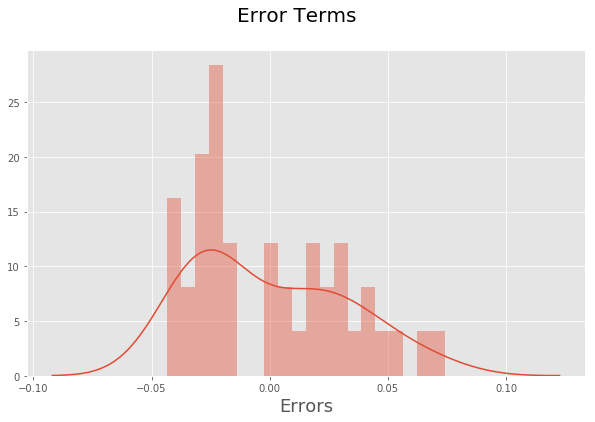

In [497]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Model Evaluation

In [498]:
# y_test = df_test.pop('gmv')
X_test = df_test

In [499]:
X_test = X_test[X_train_lm1.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test.head()

,const,adStock_Radio,GamingAccessoryKit,GamingHeadset,GamingMouse,MotionController
25,1.0,0.000000,0.931193,0.856222,0.605735,0.823529
48,1.0,0.420988,1.000000,0.512686,0.513142,0.352941
52,1.0,0.013580,0.472477,0.220701,0.158303,0.647059
37,1.0,0.481185,0.972477,0.361257,0.328554,0.529412
6,1.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [500]:
# Making predictions using the fourth model
y_pred = lr1.predict(X_test)

Text(0, 0.5, 'y_pred')

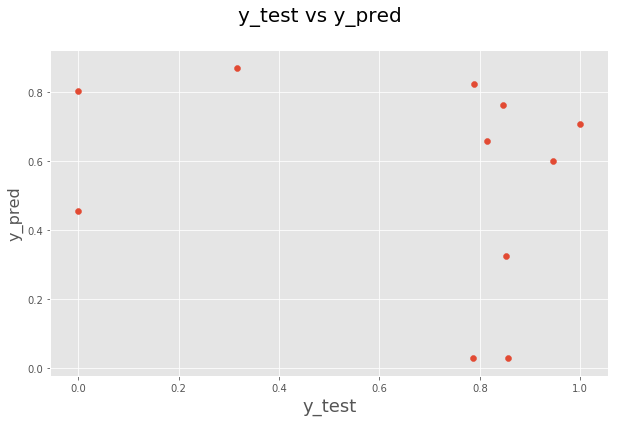

In [501]:
## Plotting y_test and y_pred to understand the spread
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

### Elasticity analysis

In [502]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr1.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm1, y_train, coefficients_df)

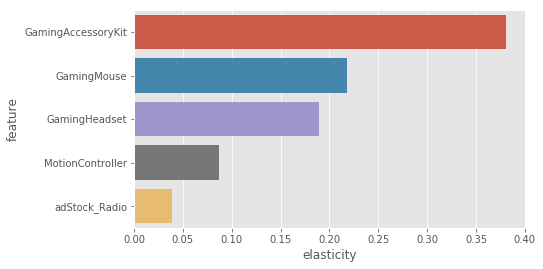

In [503]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### III. Home Audio - Kyock's  model

In [504]:
# creating dataset with lag gmv feature
df = createKyockKPI(final_home_audio_data)
df.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,...,DJController,Dock,DockingStation,FMRadio,HiFiSystem,HomeAudioSpeaker,SlingBox,SoundMixer,VoiceRecorder,gmv_lag
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,...,0.0,0.0,0.0,2.0,0.0,26.0,0.0,0.0,0.0,0.000000e+00
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,...,0.0,30.0,1.0,478.0,13.0,1281.0,0.0,0.0,25.0,7.366000e+04
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,...,0.0,50.0,1.0,532.0,27.0,1511.0,0.0,0.0,26.0,3.394594e+06
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,...,0.0,56.0,0.0,509.0,20.0,1332.0,0.0,0.0,22.0,4.012062e+06
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,...,0.0,44.0,0.0,372.0,11.0,939.0,0.0,0.0,16.0,3.560271e+06


In [505]:
# dropping the uncrollable feature
df=df.drop(['selling_price','units','product_mrp','total_transactions'], axis = 1)

In [506]:
df.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_premiumness',
       'total_holidays', 'is_holiday', 'total_special_sale_days',
       'is_special_sale_day', 'total_pay_days', 'is_pay_day', 'BoomBox',
       'DJController', 'Dock', 'DockingStation', 'FMRadio', 'HiFiSystem',
       'HomeAudioSpeaker', 'SlingBox', 'SoundMixer', 'VoiceRecorder',
       'gmv_lag'],
      dtype='object')

In [507]:
#Test-train split
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)

In [508]:
scaler = MinMaxScaler()

In [509]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars=['adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holidays',
       'total_special_sale_days',
       'total_pay_days', 'BoomBox',
       'DJController', 'Dock', 'DockingStation', 'FMRadio', 'HiFiSystem',
       'HomeAudioSpeaker', 'SlingBox', 'SoundMixer', 'VoiceRecorder',
       'gmv_lag']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [510]:
y_train = df_train.pop('gmv')
X_train = df_train

In [511]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [512]:
#selecting the top 20 feature given by rfe
col = X_train.columns[rfe.support_]
col

Index(['adStock_TV', 'adStock_Digital', 'adStock_Sponsorship',
       'adStock_Content Marketing', 'adStock_Online marketing',
       'adStock_ Affiliates', 'adStock_SEM', 'adStock_Radio', 'adStock_Other',
       'product_procurement_sla', 'discount', 'NPS', 'BoomBox', 'DJController',
       'Dock', 'FMRadio', 'HomeAudioSpeaker', 'SoundMixer', 'VoiceRecorder',
       'gmv_lag'],
      dtype='object')

In [513]:
# neglecting the feature not selected by rfe
X_train.columns[~rfe.support_]

Index(['order_week', 'Month', 'Year', 'sla', 'total_premiumness',
       'total_holidays', 'is_holiday', 'total_special_sale_days',
       'is_special_sale_day', 'total_pay_days', 'is_pay_day', 'DockingStation',
       'HiFiSystem', 'SlingBox'],
      dtype='object')

In [514]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [515]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1337.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           8.18e-26
Time:                        19:15:23   Log-Likelihood:                 165.90
No. Observations:                  40   AIC:                            -289.8
Df Residuals:                      19   BIC:                            -254.3
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
7,adStock_SEM,3450.43
9,adStock_Other,2704.36
6,adStock_ Affiliates,2606.14
8,adStock_Radio,2313.55
5,adStock_Online marketing,2202.25
2,adStock_Digital,2049.95
4,adStock_Content Marketing,597.49
1,adStock_TV,474.22
0,const,291.11
3,adStock_Sponsorship,223.73


In [516]:
# Let's drop feature  with highest p-value
X_train_new= X_train_rfe.drop(["adStock_ Affiliates"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1471.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.23e-27
Time:                        19:15:23   Log-Likelihood:                 165.76
No. Observations:                  40   AIC:                            -291.5
Df Residuals:                      20   BIC:                            -257.7
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
6,adStock_SEM,2984.64
8,adStock_Other,2236.52
7,adStock_Radio,2049.33
2,adStock_Digital,1959.15
4,adStock_Content Marketing,455.23
0,const,265.52
1,adStock_TV,239.26
5,adStock_Online marketing,145.06
3,adStock_Sponsorship,57.97
11,NPS,35.76


In [517]:
# Let's drop feature with highest p-value
X_train_new1 = X_train_new.drop(["adStock_Online marketing"], axis = 1)
 # Add a constantDockingStation
X_train_lm = sm.add_constant(X_train_new1)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1597.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           6.66e-29
Time:                        19:15:23   Log-Likelihood:                 165.35
No. Observations:                  40   AIC:                            -292.7
Df Residuals:                      21   BIC:                            -260.6
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
5,adStock_SEM,1746.43
2,adStock_Digital,1636.52
6,adStock_Radio,792.07
7,adStock_Other,678.96
0,const,139.17
4,adStock_Content Marketing,124.30
1,adStock_TV,32.40
3,adStock_Sponsorship,26.94
10,NPS,22.61
14,FMRadio,9.25


In [518]:
# Let's drop feature with highest p-value
X_train_new2 = X_train_new1.drop(["NPS"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new2)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1742.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.85e-30
Time:                        19:15:23   Log-Likelihood:                 165.01
No. Observations:                  40   AIC:                            -294.0
Df Residuals:                      22   BIC:                            -263.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
5,adStock_SEM,910.92
2,adStock_Digital,622.35
6,adStock_Radio,421.53
7,adStock_Other,387.76
0,const,113.78
4,adStock_Content Marketing,65.09
1,adStock_TV,28.26
3,adStock_Sponsorship,20.67
14,HomeAudioSpeaker,8.28
13,FMRadio,7.38


In [519]:
# Let's remove feature  with highest p-value
X_train_new3 = X_train_new2.drop(["Dock"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new3)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1861.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           6.43e-32
Time:                        19:15:23   Log-Likelihood:                 164.23
No. Observations:                  40   AIC:                            -294.5
Df Residuals:                      23   BIC:                            -265.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
5,adStock_SEM,881.08
2,adStock_Digital,603.20
6,adStock_Radio,410.72
7,adStock_Other,378.69
0,const,113.76
4,adStock_Content Marketing,65.06
1,adStock_TV,27.33
3,adStock_Sponsorship,20.51
13,HomeAudioSpeaker,7.87
9,discount,5.75


In [520]:
# Let's drop feature with higest p-value
X_train_new4 = X_train_new3.drop(["SoundMixer"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new4)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1833.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           5.97e-33
Time:                        19:15:23   Log-Likelihood:                 161.78
No. Observations:                  40   AIC:                            -291.6
Df Residuals:                      24   BIC:                            -264.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
5,adStock_SEM,861.76
2,adStock_Digital,592.05
6,adStock_Radio,404.27
7,adStock_Other,371.71
0,const,107.90
4,adStock_Content Marketing,64.28
1,adStock_TV,24.92
3,adStock_Sponsorship,19.94
13,HomeAudioSpeaker,7.35
12,FMRadio,5.65


In [521]:
X_train_new5 = X_train_new4.drop(["discount"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new5)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1687.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.42e-33
Time:                        19:15:23   Log-Likelihood:                 157.93
No. Observations:                  40   AIC:                            -285.9
Df Residuals:                      25   BIC:                            -260.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
5,adStock_SEM,861.74
2,adStock_Digital,579.57
6,adStock_Radio,404.09
7,adStock_Other,369.67
0,const,106.14
4,adStock_Content Marketing,54.78
1,adStock_TV,23.36
3,adStock_Sponsorship,19.52
11,FMRadio,5.40
9,BoomBox,5.02


In [522]:
X_train_new6 = X_train_new5.drop(["product_procurement_sla"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new6)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1873.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           3.55e-35
Time:                        19:15:23   Log-Likelihood:                 157.76
No. Observations:                  40   AIC:                            -287.5
Df Residuals:                      26   BIC:                            -263.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
5,adStock_SEM,853.38
2,adStock_Digital,571.78
6,adStock_Radio,386.94
7,adStock_Other,352.81
0,const,62.65
4,adStock_Content Marketing,53.92
1,adStock_TV,21.73
3,adStock_Sponsorship,19.30
10,FMRadio,5.25
8,BoomBox,4.89


In [523]:
# dropping the feature with highest p-value
X_train_new7= X_train_new6.drop(["adStock_Content Marketing"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new7)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1923.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.58e-36
Time:                        19:15:23   Log-Likelihood:                 155.93
No. Observations:                  40   AIC:                            -285.9
Df Residuals:                      27   BIC:                            -263.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0250    

,Features,VIF
4,adStock_SEM,800.13
2,adStock_Digital,571.26
5,adStock_Radio,386.93
6,adStock_Other,349.83
0,const,62.24
1,adStock_TV,21.09
3,adStock_Sponsorship,17.56
9,FMRadio,5.18
7,BoomBox,4.85
10,HomeAudioSpeaker,3.44


In [524]:
# dropping the feature with highest p-value
X_train_new8= X_train_new7.drop(["adStock_TV"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new8)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1977.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.05e-37
Time:                        19:15:23   Log-Likelihood:                 154.01
No. Observations:                  40   AIC:                            -284.0
Df Residuals:                      28   BIC:                            -263.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0147    

,Features,VIF
3,adStock_SEM,191.52
1,adStock_Digital,129.84
4,adStock_Radio,56.70
5,adStock_Other,43.99
0,const,17.88
2,adStock_Sponsorship,13.81
8,FMRadio,5.14
6,BoomBox,4.84
9,HomeAudioSpeaker,3.41
10,VoiceRecorder,2.08


In [525]:
# dropping the feature with highest vif
X_train_new9= X_train_new8.drop(["adStock_Other"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new9)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2104.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.12e-38
Time:                        19:15:23   Log-Likelihood:                 152.66
No. Observations:                  40   AIC:                            -283.3
Df Residuals:                      29   BIC:                            -264.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0126    

,Features,VIF
3,adStock_SEM,63.53
1,adStock_Digital,46.38
0,const,15.47
2,adStock_Sponsorship,7.05
7,FMRadio,4.61
5,BoomBox,3.20
8,HomeAudioSpeaker,3.13
4,adStock_Radio,2.09
9,VoiceRecorder,1.70
10,gmv_lag,1.45


In [526]:
# dropping the feature with highest p-value
X_train_new10= X_train_new9.drop(["DJController"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new10)
  
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2058.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.44e-39
Time:                        19:15:23   Log-Likelihood:                 149.44
No. Observations:                  40   AIC:                            -278.9
Df Residuals:                      30   BIC:                            -262.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0139    

,Features,VIF
3,adStock_SEM,62.67
1,adStock_Digital,45.61
0,const,15.08
2,adStock_Sponsorship,7.04
6,FMRadio,4.59
5,BoomBox,3.18
7,HomeAudioSpeaker,3.11
4,adStock_Radio,2.06
8,VoiceRecorder,1.69
9,gmv_lag,1.44


In [527]:
# dropping the feature with hioghest p-value
X_train_new11= X_train_new10.drop(["gmv_lag"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new11)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1982.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           8.82e-40
Time:                        19:15:23   Log-Likelihood:                 145.68
No. Observations:                  40   AIC:                            -273.4
Df Residuals:                      31   BIC:                            -258.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0195    

,Features,VIF
3,adStock_SEM,62.63
1,adStock_Digital,45.17
0,const,10.56
2,adStock_Sponsorship,6.97
6,FMRadio,4.56
7,HomeAudioSpeaker,3.11
5,BoomBox,2.92
4,adStock_Radio,1.96
8,VoiceRecorder,1.66


In [528]:
# dropping the feature with highest p-value
X_train_new12= X_train_new11.drop(["adStock_Radio"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new12)
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2085.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.10e-40
Time:                        19:15:23   Log-Likelihood:                 143.39
No. Observations:                  40   AIC:                            -270.8
Df Residuals:                      32   BIC:                            -257.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0174    

,Features,VIF
3,adStock_SEM,46.65
1,adStock_Digital,34.11
0,const,9.61
2,adStock_Sponsorship,5.72
5,FMRadio,4.52
6,HomeAudioSpeaker,3.06
4,BoomBox,2.92
7,VoiceRecorder,1.54


In [529]:
# dropping the feature with highest p-value
X_train_new13= X_train_new12.drop(["adStock_Digital"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new13)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2397.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           4.39e-42
Time:                        19:15:23   Log-Likelihood:                 142.48
No. Observations:                  40   AIC:                            -271.0
Df Residuals:                      33   BIC:                            -259.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0174    

,Features,VIF
0,const,9.61
2,adStock_SEM,5.47
1,adStock_Sponsorship,4.49
4,FMRadio,4.22
3,BoomBox,2.74
5,HomeAudioSpeaker,2.59
6,VoiceRecorder,1.53


In [530]:
# deleting the features with highest p-values
X_train_new14= X_train_new13.drop(["adStock_SEM"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train_new14)
    
lr1 = sm.OLS(y_train, X_train_lm1).fit()

lr1.params
print(lr1.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1 .values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2866.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.34e-43
Time:                        19:15:23   Log-Likelihood:                 141.81
No. Observations:                  40   AIC:                            -271.6
Df Residuals:                      34   BIC:                            -261.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0164    

,Features,VIF
0,const,9.08
3,FMRadio,3.88
2,BoomBox,2.48
4,HomeAudioSpeaker,2.41
1,adStock_Sponsorship,1.53
5,VoiceRecorder,1.22


In [531]:
# dropping feature with highest p-value
X_train_new15= X_train_new14.drop(["adStock_Sponsorship"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train_new15)
  
lr2 = sm.OLS(y_train, X_train_lm1).fit()

lr2.params
print(lr2.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1 .values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3622.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           2.83e-45
Time:                        19:15:23   Log-Likelihood:                 141.46
No. Observations:                  40   AIC:                            -272.9
Df Residuals:                      35   BIC:                            -264.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0163      0.004  

,Features,VIF
0,const,9.06
2,FMRadio,3.53
1,BoomBox,2.40
3,HomeAudioSpeaker,2.38
4,VoiceRecorder,1.22


In [532]:
# dropping feature with highest p-value
X_train_new16= X_train_new15.drop(["BoomBox"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train_new16)
    
lr2 = sm.OLS(y_train, X_train_lm2).fit()

lr2.params
print(lr2.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2 .values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4538.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           1.86e-46
Time:                        19:15:23   Log-Likelihood:                 139.65
No. Observations:                  40   AIC:                            -271.3
Df Residuals:                      36   BIC:                            -264.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0174      0.004  

,Features,VIF
0,const,8.83
2,HomeAudioSpeaker,2.38
1,FMRadio,2.36
3,VoiceRecorder,1.01


In [533]:
# k-fold Cross Validation - Adjusted R-squared
lm = LinearRegression()
#Checking performance of top 4 models finding Adjusted R-squared
x_trains = [X_train_lm1,X_train_lm2]
for i in range(0,len(x_trains)):
    x_test = x_trains[i]
    scores = cross_val_score(lm, x_test, y_train , scoring='r2', cv=5)
    print("lr model",i+1,"r2_score", scores.mean())

lr model 1 r2_score 0.9833287891121156
lr model 2 r2_score 0.9851866316465335


In [534]:
# k-fold Cross Validation - MSE
lm = LinearRegression()
#Checking performance of top 4 models finding Adjusted R-squared
x_trains = [X_train_lm1,X_train_lm2]
for i in range(0,len(x_trains)):
    x_test = x_trains[i]
    scores = cross_val_score(lm, x_test, y_train , scoring='neg_mean_squared_error', cv=5)
    print("lr model",i+1,"MSE", -scores.mean())

lr model 1 MSE 9.617788085916355e-05
lr model 2 MSE 8.162359848278281e-05


#### The best model is model 2 with the minimum number of features but maximum variance of the model being explained. Also, the MSE is the least of the 2nd model

### Residual Analysis


In [535]:
y_train_price = lr2.predict(X_train_lm3)

Text(0.5, 0, 'Errors')

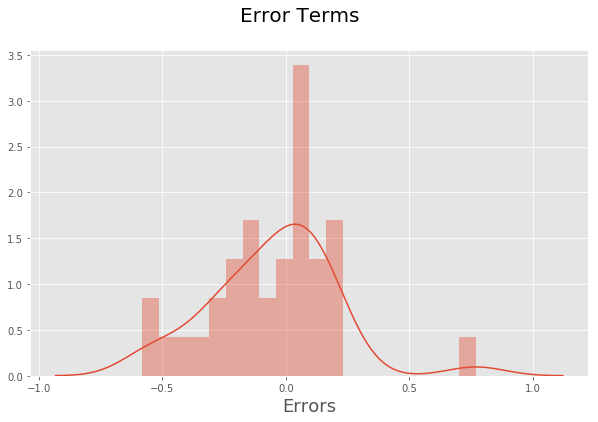

In [536]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Model Evaluation

In [537]:
# y_test = df_test.pop('gmv')
X_test = df_test
y_test = df_test.pop('gmv')

In [542]:
X_test = X_test[X_train_lm2.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test

,const,FMRadio,HomeAudioSpeaker,VoiceRecorder
6,1.0,0.833648,0.416162,0.375000
36,1.0,0.720227,0.446061,0.894231
37,1.0,0.725898,0.379394,0.894231
28,1.0,0.897921,1.000000,0.730769
43,1.0,0.551985,0.381414,1.000000
49,1.0,0.164461,0.194343,0.240385
5,1.0,0.000000,0.000000,0.000000
33,1.0,1.000000,0.871515,0.798077
20,1.0,0.843100,0.960000,0.394231
42,1.0,0.642722,0.426263,0.932692


In [539]:
# Making predictions using the fourth model
y_pred = lr2.predict(X_test)

Text(0, 0.5, 'y_pred')

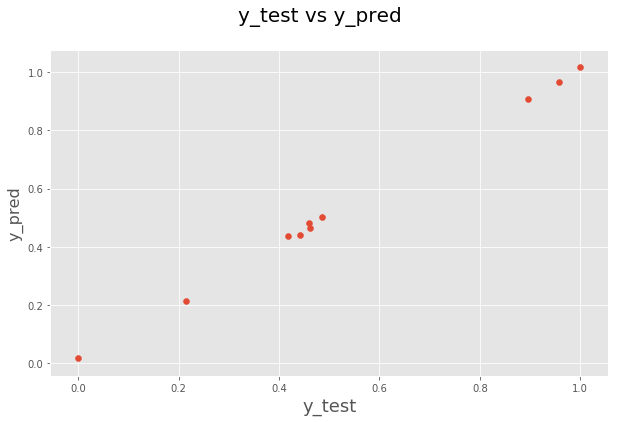

In [540]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

### Elasticity

In [544]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr2.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm2, y_train, coefficients_df)

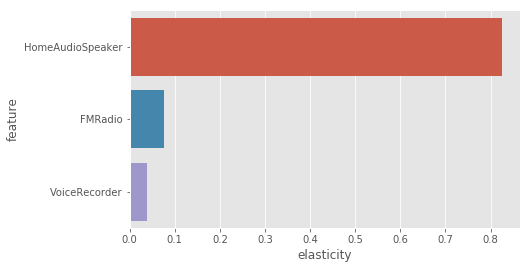

In [545]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### Building the Distributed Lag Models

### Distributed Lag Model - Data Preparation

In [ ]:
#Creating function to create Lagged KPIs for the Distributed Lag Model
def createKPiForDistributedLag(df):
    df['adStock_TV_lag1'] = df['adStock_TV'].shift(1)
    df['adStock_TV_lag2'] = df['adStock_TV'].shift(2)
    df['adStock_TV_lag3'] = df['adStock_TV'].shift(3)
    
    df['adStock_Digital_lag1'] = df['adStock_Digital'].shift(1)
    df['adStock_Digital_lag2'] = df['adStock_Digital'].shift(2)
    df['adStock_Digital_lag3'] = df['adStock_Digital'].shift(3)
    
    df['adStock_Sponsorship_lag1'] = df['adStock_Sponsorship'].shift(1)
    df['adStock_Sponsorship_lag2'] = df['adStock_Sponsorship'].shift(2)
    df['adStock_Sponsorship_lag3'] = df['adStock_Sponsorship'].shift(3)
    
    df['adStock_Content Marketing_lag1'] = df['adStock_Content Marketing'].shift(1)
    df['adStock_Content Marketing_lag2'] = df['adStock_Content Marketing'].shift(2)
    df['adStock_Content Marketing_lag3'] = df['adStock_Content Marketing'].shift(3)
    
    df['adStock_Online marketing_lag1'] = df['adStock_Online marketing'].shift(1)    
    df['adStock_Online marketing_lag2'] = df['adStock_Online marketing'].shift(2)    
    df['adStock_Online marketing_lag3'] = df['adStock_Online marketing'].shift(3)    
    
    df['adStock_ Affiliates_lag1'] = df['adStock_ Affiliates'].shift(1)
    df['adStock_ Affiliates_lag2'] = df['adStock_ Affiliates'].shift(2)
    df['adStock_ Affiliates_lag3'] = df['adStock_ Affiliates'].shift(3)
    
    df['adStock_SEM_lag1'] = df['adStock_SEM'].shift(1)   
    df['adStock_SEM_lag2'] = df['adStock_SEM'].shift(2)
    df['adStock_SEM_lag3'] = df['adStock_SEM'].shift(3)
    
    df['adStock_Other_lag1'] = df['adStock_Other'].shift(1)   
    df['adStock_Other_lag2'] = df['adStock_Other'].shift(2)
    df['adStock_Other_lag3'] = df['adStock_Other'].shift(3)
    
    df['gmv_lag1'] = df['gmv'].shift(1)   
    df['gmv_lag2'] = df['gmv'].shift(2)
    df['gmv_lag3'] = df['gmv'].shift(3)
    
    df['sla_lag1'] = df['sla'].shift(1)   
    df['sla_lag2'] = df['sla'].shift(2)
    df['sla_lag3'] = df['sla'].shift(3)
    
    df['product_procurement_sla_lag1'] = df['product_procurement_sla'].shift(1)   
    df['product_procurement_sla_lag2'] = df['product_procurement_sla'].shift(2)
    df['product_procurement_sla_lag3'] = df['product_procurement_sla'].shift(3)
    
    df['discount_lag1'] = df['discount'].shift(1)   
    df['discount_lag2'] = df['discount'].shift(2)
    df['discount_lag3'] = df['discount'].shift(3)
    
    df['NPS_lag1'] = df['NPS'].shift(1)   
    df['NPS_lag2'] = df['NPS'].shift(2)
    df['NPS_lag3'] = df['NPS'].shift(3)
    
        
    return df.fillna(0)

### I. Camera Accessory - Distributed Lag Model

In [ ]:
#Creating Lagged KPIs
df = createKPiForDistributedLag(final_camera_data)
df.head()

In [ ]:
df.shape

In [ ]:
#Dropping the features which cannot be handled by the company
df = df.drop(['selling_price','units','product_mrp','total_transactions'], axis = 1)

In [ ]:
df.head()

In [ ]:
#Test-train split
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
df.columns

In [ ]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars=['adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holidays',
       'total_special_sale_days',
       'total_pay_days',
       'Binoculars', 'CameraAccessory', 'CameraBag', 'CameraBattery',
       'CameraBatteryCharger', 'CameraBatteryGrip', 'CameraEyeCup',
       'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone', 'CameraMount',
       'CameraRemoteControl', 'CameraTripod', 'ExtensionTube', 'Filter',
       'Flash', 'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella', 'Softbox',
       'Strap', 'Telescope', 'adStock_TV_lag1', 'adStock_TV_lag2',
       'adStock_TV_lag3', 'adStock_Digital_lag1', 'adStock_Digital_lag2',
       'adStock_Digital_lag3', 'adStock_Sponsorship_lag1',
       'adStock_Sponsorship_lag2', 'adStock_Sponsorship_lag3',
       'adStock_Content Marketing_lag1', 'adStock_Content Marketing_lag2',
       'adStock_Content Marketing_lag3', 'adStock_Online marketing_lag1',
       'adStock_Online marketing_lag2', 'adStock_Online marketing_lag3',
       'adStock_ Affiliates_lag1', 'adStock_ Affiliates_lag2',
       'adStock_ Affiliates_lag3', 'adStock_SEM_lag1', 'adStock_SEM_lag2',
       'adStock_SEM_lag3', 'adStock_Other_lag1', 'adStock_Other_lag2',
       'adStock_Other_lag3', 'gmv_lag1', 'gmv_lag2', 'gmv_lag3', 'sla_lag1',
       'sla_lag2', 'sla_lag3', 'product_procurement_sla_lag1',
       'product_procurement_sla_lag2', 'product_procurement_sla_lag3',
       'discount_lag1', 'discount_lag2', 'discount_lag3', 'NPS_lag1',
       'NPS_lag2', 'NPS_lag3']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [ ]:
y_train = df_train.pop('gmv')
X_train = df_train

In [ ]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [ ]:
col = X_train.columns[rfe.support_]
col

In [ ]:
X_train.columns[~rfe.support_]

In [ ]:
# Creating dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [ ]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Let's drop feature with highest p-value
X_train_new= X_train_rfe.drop(["adStock_Content Marketing_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Let's drop with highest p-value
X_train_new1 = X_train_new.drop(["adStock_SEM_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new1)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Let's drop feature Flash with highest VIF
X_train_new2 = X_train_new1.drop(["adStock_Other_lag2"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new2)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Let's remove feature with highest p-value
X_train_new3 = X_train_new2.drop(["FlashShoeAdapter"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new3)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Let's drop the feature with highest p-value
X_train_new4 = X_train_new3.drop(["CameraBag"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new4)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
X_train_new5 = X_train_new4.drop(["Softbox"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new5)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Dropping the feature with highest VIF value
X_train_new6 = X_train_new5.drop(["total_special_sale_days"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new6)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Dropping the feature with highest p-value
X_train_new7= X_train_new6.drop(["is_special_sale_day"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new7)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Dropping the feature with highest VIF
X_train_new8= X_train_new7.drop(["adStock_Other_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new8)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Dropping the feature with highest p-value
X_train_new10= X_train_new8
 # Add a constant
X_train_lm1 = sm.add_constant(X_train_new10)
    
lr = sm.OLS(y_train, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

##### Selecting this as the first model as all the p-values & VIFs are in the acceptable range

In [ ]:
#Let's try to drop another feature so that still the maximum variance is being capture by the model
X_train_new11= X_train_new10.drop(["Flash"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train_new11)
    
lr2 = sm.OLS(y_train, X_train_lm2).fit()

lr2.params
print(lr2.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2 .values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

##### Selecting this as the second model as all the p-values & VIFs are in the acceptable range

In [ ]:
#Let's try to drop another feature so that still the maximum variance is being capture by the model
X_train_new12= X_train_new11.drop(["sla_lag3"], axis = 1)
 # Add a constant
X_train_lm3 = sm.add_constant(X_train_new12)
    # Create a first fitted model
lr3 = sm.OLS(y_train, X_train_lm3).fit()

lr3.params
print(lr3.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm3 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm3 .values, i) for i in range(X_train_lm3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# k-fold Cross Validation - Adjusted R-squared
lm = LinearRegression()
#Checking performance of top 4 models finding Adjusted R-squared
x_trains = [X_train_lm1, X_train_lm2, X_train_lm3]
for i in range(0,len(x_trains)):
    x_test = x_trains[i]
    scores = cross_val_score(lm, x_test, y_train , scoring='r2', cv=5)
    print("lr model",i+1,"r2_score", scores.mean())

In [ ]:
# k-fold Cross Validation - MSE
lm = LinearRegression()
#Checking performance of top 4 models finding Adjusted R-squared
x_trains = [X_train_lm1, X_train_lm2, X_train_lm3]
for i in range(0,len(x_trains)):
    x_test = x_trains[i]
    scores = cross_val_score(lm, x_test, y_train , scoring='neg_mean_squared_error', cv=5)
    print("lr model",i+1,"MSE", -scores.mean())

#### As we see linear model 1 performs much better having lowest MSE than the other two models, therefore we choose that as the best among the multiplicative models for Camera Category

### Residual Analysis


In [ ]:
y_train_price = lr.predict(X_train_lm1)

In [ ]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Model Evaluation

In [ ]:
y_test = df_test.pop('gmv')
X_test = df_test

In [ ]:
X_test.columns

In [ ]:
X_test.head()

In [ ]:
X_test = X_test[X_train_lm1.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test

In [ ]:
# Making predictions using the final model
y_pred = lr.predict(X_test)

In [ ]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

### Elasticity

In [ ]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm1, y_train, coefficients_df)

In [ ]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### II. Gaming Accessory - Distributed Lag model

In [ ]:
# Creating the lagged KPIs for distributed lag model
df = createKPiForDistributedLag(final_gaming_data)

In [ ]:
# dropping the uncontrollable features
df = df.drop(['selling_price','units','product_mrp','total_transactions'], axis = 1)

In [ ]:
df.head()

In [ ]:
#Test-train split
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.20, random_state = 100)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
df.columns

In [ ]:
# Apply scaler() to all the columns except the categorical variables
num_vars=['adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holidays',
        'total_special_sale_days',
       'total_pay_days',
       'CoolingPad', 'GameControlMount', 'GamePad', 'GamingAccessoryKit',
       'GamingAdapter', 'GamingChargingStation', 'GamingHeadset',
       'GamingKeyboard', 'GamingMemoryCard', 'GamingMouse', 'GamingMousePad',
       'GamingSpeaker', 'JoystickGamingWheel', 'MotionController',
       'TVOutCableAccessory', 'adStock_TV_lag1', 'adStock_TV_lag2',
       'adStock_TV_lag3', 'adStock_Digital_lag1', 'adStock_Digital_lag2',
       'adStock_Digital_lag3', 'adStock_Sponsorship_lag1',
       'adStock_Sponsorship_lag2', 'adStock_Sponsorship_lag3',
       'adStock_Content Marketing_lag1', 'adStock_Content Marketing_lag2',
       'adStock_Content Marketing_lag3', 'adStock_Online marketing_lag1',
       'adStock_Online marketing_lag2', 'adStock_Online marketing_lag3',
       'adStock_ Affiliates_lag1', 'adStock_ Affiliates_lag2',
       'adStock_ Affiliates_lag3', 'adStock_SEM_lag1', 'adStock_SEM_lag2',
       'adStock_SEM_lag3', 'adStock_Other_lag1', 'adStock_Other_lag2',
       'adStock_Other_lag3', 'gmv_lag1', 'gmv_lag2', 'gmv_lag3', 'sla_lag1',
       'sla_lag2', 'sla_lag3', 'product_procurement_sla_lag1',
       'product_procurement_sla_lag2', 'product_procurement_sla_lag3',
       'discount_lag1', 'discount_lag2', 'discount_lag3', 'NPS_lag1',
       'NPS_lag2', 'NPS_lag3']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [ ]:
y_train = df_train.pop('gmv')
X_train = df_train

In [ ]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [ ]:
# selecting the top 20 features by rfe
col = X_train.columns[rfe.support_]
col

In [ ]:
X_train.columns[~rfe.support_]

In [ ]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [ ]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Let's drop feature GamingAccessoryKit with highest p-value
X_train_new= X_train_rfe.drop(["sla_lag2"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Let's drop Year with highest p-value
X_train_new1 = X_train_new.drop(["product_procurement_sla_lag2"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new1)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Let's drop feature Flash with highest p-value
X_train_new2 = X_train_new1.drop(["adStock_Sponsorship_lag2"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new2)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Let's remove feature with highest p-value
X_train_new3 = X_train_new2.drop(["adStock_ Affiliates"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new3)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Let's drop feature  with higest p-value
X_train_new4 = X_train_new3.drop(["adStock_SEM_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new4)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# dropping the feature with highest p-values
X_train_new5 = X_train_new4.drop(["adStock_Other_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new5)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# dropping the feature with highest p -value
X_train_new6 = X_train_new5.drop(["adStock_SEM_lag1"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new6)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# dropping the feature with highest vif
X_train_new7= X_train_new6.drop(["adStock_Content Marketing_lag2"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new7)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# dropping the feature with highest p-value
X_train_new8= X_train_new7.drop(["GamingAccessoryKit"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new8)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# dropping the feature with highest p-value
X_train_new9= X_train_new8.drop(["product_procurement_sla_lag1"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new9)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# dropping the features with higest p-value
X_train_new10= X_train_new9
 # Add a constant
X_train_lm1 = sm.add_constant(X_train_new10)
    
lr1 = sm.OLS(y_train, X_train_lm1).fit()

lr1.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

### Selecting this as our first model based on p-value and vif values

In [ ]:
# dropping the features to see the min drop in adj. r2 values
X_train_new11= X_train_new10.drop(["GamingChargingStation"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train_new11)
    
lr2 = sm.OLS(y_train, X_train_lm2).fit()

lr2.params
print(lr2.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2 .values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

### Selecting this as our second model based on p-value and vif values

In [ ]:
# dropping the features to see the min drop in adj. r2 values
X_train_new12= X_train_new11.drop(["GamingMemoryCard"], axis = 1)
 # Add a constant
X_train_lm3 = sm.add_constant(X_train_new12)
    
lr3 = sm.OLS(y_train, X_train_lm3).fit()

lr3.params
print(lr3.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm3 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm3 .values, i) for i in range(X_train_lm3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

### Selecting this as our third model based on p-value and vif values

In [ ]:
# k-fold Cross Validation - Adjusted R-squared
lm = LinearRegression()
#Checking performance of top 4 models finding Adjusted R-squared
x_trains = [X_train_lm1,X_train_lm2,X_train_lm3]
for i in range(0,len(x_trains)):
    x_test = x_trains[i]
    scores = cross_val_score(lm, x_test, y_train , scoring='r2', cv=5)
    print("lr model",i+1,"r2_score", scores.mean())

In [ ]:
# k-fold Cross Validation - MSE
lm = LinearRegression()
#Checking performance of top 4 models finding Adjusted R-squared
x_trains = [X_train_lm1,X_train_lm2,X_train_lm3]
for i in range(0,len(x_trains)):
    x_test = x_trains[i]
    scores = cross_val_score(lm, x_test, y_train , scoring='neg_mean_squared_error', cv=5)
    print("lr model",i+1,"r2_score", -scores.mean())

### Residual Analysis


In [ ]:
y_train_price = lr2.predict(X_train_lm2)

In [ ]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Model Evaluation

In [ ]:
# y_test = df_test.pop('gmv')
X_test = df_test

In [ ]:
X_test = X_test[X_train_lm2.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test.head()

In [ ]:
# Making predictions using the fourth model
y_pred = lr2.predict(X_test)

In [ ]:
## Plotting y_test and y_pred to understand the spread
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

### Elasticity

In [ ]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr2.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm2, y_train, coefficients_df)

In [ ]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### III. Home Audio - Distributed lag  model

In [ ]:
# creating lag features
df = createKPiForDistributedLag(final_home_audio_data)
df.head()

In [ ]:
# dropping the uncontrollable features
df=df.drop(['selling_price','units','product_mrp','total_transactions'], axis = 1)

In [ ]:
df.columns

In [ ]:
#Test-train split
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars=['adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holidays',
        'total_special_sale_days', 
       'total_pay_days', 'BoomBox',
       'DJController', 'Dock', 'DockingStation', 'FMRadio', 'HiFiSystem',
       'HomeAudioSpeaker', 'SlingBox', 'SoundMixer', 'VoiceRecorder',
       'adStock_TV_lag1', 'adStock_TV_lag2', 'adStock_TV_lag3',
       'adStock_Digital_lag1', 'adStock_Digital_lag2', 'adStock_Digital_lag3',
       'adStock_Sponsorship_lag1', 'adStock_Sponsorship_lag2',
       'adStock_Sponsorship_lag3', 'adStock_Content Marketing_lag1',
       'adStock_Content Marketing_lag2', 'adStock_Content Marketing_lag3',
       'adStock_Online marketing_lag1', 'adStock_Online marketing_lag2',
       'adStock_Online marketing_lag3', 'adStock_ Affiliates_lag1',
       'adStock_ Affiliates_lag2', 'adStock_ Affiliates_lag3',
       'adStock_SEM_lag1', 'adStock_SEM_lag2', 'adStock_SEM_lag3',
       'adStock_Other_lag1', 'adStock_Other_lag2', 'adStock_Other_lag3',
       'gmv_lag1', 'gmv_lag2', 'gmv_lag3', 'sla_lag1', 'sla_lag2', 'sla_lag3',
       'product_procurement_sla_lag1', 'product_procurement_sla_lag2',
       'product_procurement_sla_lag3', 'discount_lag1', 'discount_lag2',
       'discount_lag3', 'NPS_lag1', 'NPS_lag2', 'NPS_lag3']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [ ]:
y_train = df_train.pop('gmv')
X_train = df_train

In [ ]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [ ]:
# selecting features given by rfe
col = X_train.columns[rfe.support_]
col

In [ ]:
# neglecting the features not selected by rfe
X_train.columns[~rfe.support_]

In [ ]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [ ]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Let's drop feature with highest p-value
X_train_new= X_train_rfe.drop(["SlingBox"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Let's drop feature with highest p-value
X_train_new1 = X_train_new.drop(["product_procurement_sla_lag2"], axis = 1)
 # Add a constantDockingStation
X_train_lm = sm.add_constant(X_train_new1)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Let's drop feature with highest p-value
X_train_new2 = X_train_new1.drop(["adStock_SEM"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new2)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Let's remove feature with highest p-value
X_train_new3 = X_train_new2.drop(["product_procurement_sla_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new3)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Let's drop feature with higest p-value
X_train_new4 = X_train_new3.drop(["discount_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new4)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
#Let's drop feature with highest p-value
X_train_new5 = X_train_new4.drop(["adStock_Digital_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new5)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
#Let's drop feature with highest p-value
X_train_new6 = X_train_new5.drop(["gmv_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new6)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
#Let's drop feature with highest p-value
X_train_new7= X_train_new6.drop(["adStock_Online marketing_lag1"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new7)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
#Let's drop feature with highest p-value
X_train_new8= X_train_new7.drop(["total_holidays"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new8)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
#Let's drop feature with highest p-value
X_train_new9= X_train_new8.drop(["adStock_Other_lag1"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new9)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
#Let's drop feature with highest p-value
X_train_new10= X_train_new9.drop(["adStock_Radio"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new10)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
#Let's drop feature with highest p-value
X_train_new11= X_train_new10.drop(["sla"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new11)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
#Let's drop feature with highest p-value
X_train_new12= X_train_new11.drop(["adStock_Online marketing_lag2"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new12)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
#Let's drop feature with highest p-value
X_train_new13= X_train_new12.drop(["SoundMixer"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_new13)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
#Let's drop feature with highest p-value
X_train_new14= X_train_new13.drop(["discount"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train_new14)
    
lr1 = sm.OLS(y_train, X_train_lm1).fit()

lr1.params
print(lr1.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1 .values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
#Let's drop feature with highest p-value
X_train_new16= X_train_new14.drop(["NPS"], axis = 1)
 # Add a constant
X_train_lm2 = sm.add_constant(X_train_new16)
    
lr3 = sm.OLS(y_train, X_train_lm2).fit()

lr3.params
print(lr3.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2 .values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
#Let's drop feature with highest p-value
X_train_new17= X_train_new16.drop(["BoomBox"], axis = 1)
 # Add a constant
X_train_lm3 = sm.add_constant(X_train_new17)
    
lr2 = sm.OLS(y_train, X_train_lm3).fit()

lr2.params
print(lr2.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm3 .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm3 .values, i) for i in range(X_train_lm3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# k-fold Cross Validation - Adjusted R-squared
lm = LinearRegression()
#Checking performance of top 4 models finding Adjusted R-squared
x_trains = [X_train_lm1,X_train_lm2]
for i in range(0,len(x_trains)):
    x_test = x_trains[i]
    scores = cross_val_score(lm, x_test, y_train , scoring='r2', cv=5)
    print("lr model",i+1,"r2_score", scores.mean())

In [ ]:
# k-fold Cross Validation - MSE
lm = LinearRegression()
#Checking performance of top 4 models finding Adjusted R-squared
x_trains = [X_train_lm1,X_train_lm2]
for i in range(0,len(x_trains)):
    x_test = x_trains[i]
    scores = cross_val_score(lm, x_test, y_train , scoring='neg_mean_squared_error', cv=5)
    print("lr model",i+1,"MSE", -scores.mean())

#### The best model is model 2 with the minimum number of features but maximum variance of the model being explained. As only two features are able to explain the 97% variance of the model

### Residual Analysis


In [ ]:
y_train_price = lr2.predict(X_train_lm3)

In [ ]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Model Evaluation

In [ ]:
# y_test = df_test.pop('gmv')
X_test = df_test
y_test = df_test.pop('gmv')

In [ ]:
X_test = X_test[X_train_lm3.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test

In [ ]:
# Making predictions using the fourth model
y_pred = lr2.predict(X_test)

In [ ]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

### Elasticity Analysis - Home Audio - Distributed Lag Model

In [ ]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr2.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm2, y_train, coefficients_df)

In [ ]:
plt.figure(figsize = (9,5))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))